Script to Discover Pattern in Step Stress

In [1]:
import os
import re

step_shear_data_path = '../../step_shear_data/'
images_base_path = './roles_images/'
images_eps_base_path = './roles_images/eps/'
images_pickle_base_path = './roles_images/pickle/'

expirments_path_dict = dict()
expirments_mbar_dict = dict()

for r, d, f in os.walk(step_shear_data_path):
    if r.endswith('ompositeall'):
        folders = r.split('/')
        
        mbar = folders[-4].split('_')[0]
        
        expirment_number = folders[-2]
        expirment_date = folders[-3]
        
        expirement_tag = 'step_shear_data_' + mbar +'_mbar_' + expirment_date + '_' + expirment_number
        
        expirments_path_dict[expirement_tag] = r
        expirments_mbar_dict[expirement_tag] = mbar

In [2]:
##clustring
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

def standard_df(df):
    pipe_norm = make_pipeline(StandardScaler())
    pipe_norm.fit(df)
    transformed_norm = pipe_norm.transform(df)
    
    return transformed_norm, pipe_norm

def transle_role(role):
    if (role == 0):
        return 'Hub'
    elif (role == 1):
        return 'Individual'
    elif (role == 2):
        return 'Follower'
    elif (role == 3):
        return 'Leader'
    else:
        return 'Normal'

def get_role(row, threshold):    
    if (row[0] >= threshold and row[1] >= threshold):
        return 0
    elif (row[0] <= -threshold and row[1] <= -threshold):
        return 1
    elif (row[0] >= threshold and row[1] < threshold):
        return 2
    elif (row[0] < threshold and row[1] >= threshold):
        return 3
    else:
        return 4

In [3]:
#import base porject to system path

import os
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

def calc_mean_response_curve(cells_intensity):
    avg_intensity = np.zeros((cells_intensity.shape[1]))
    
    min_intensity = np.zeros((cells_intensity.shape[1])) + 1
    max_intensity = np.zeros((cells_intensity.shape[1])) - 1

    for cell_idx,cell_intensity in enumerate(cells_intensity):
        avg_intensity += cell_intensity
        #min_intensity = np.minimum(min_intensity, cell_intensity)
        #max_intensity = np.maximum(max_intensity, cell_intensity)    
    
    std_intensity = np.std(cells_intensity, axis=0)    
    avg_intensity = avg_intensity / cells_intensity.shape[0]
    
    return avg_intensity, hampel(pd.Series(std_intensity), window_size=10, n=3)

from bisect import bisect_left

def find_activation(cells_intensity, threshold=0.10):
    intensity_activation_frame = np.zeros((cells_intensity.shape[0]))    
    for i in range(cells_intensity.shape[0]):
        min_value = np.min(cells_intensity[i])
        max_value = np.max(cells_intensity[i])
        cell_value_threshold = min_value + threshold*(max_value-min_value)
        
        intensity_activation_frame[i] = [idx for idx,value in enumerate(cells_intensity[i]) if abs(value)>abs(cell_value_threshold)][0]
        #print str(min_value) + ' ' + str(max_value) + ' ' + str(cell_value_threshold) + ' ' + str(intensity_activation_frame[i])
    
    return intensity_activation_frame

# Activiation Time analysis per cycle
def calc_activation_time_for_parts(raw_intensity_parts, number_of_parts):
    activation_time_scores = {}
    for part in range(0, number_of_parts):
        activation_time_scores[part] = find_activation(raw_intensity_parts[part])
    
    return activation_time_scores

def plot_peaks_analysis(indexs, mean_normalized_cells_response_curve, std_normalized_cells_response_curve, base_path, eps_base_path):
    import matplotlib
    import matplotlib.pyplot as plt

    import peakutils
    from peakutils.plot import plot as pplot
    import seaborn as sns

    sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 1})


    indexes = list(range(0, mean_normalized_cells_response_curve.shape[0], mean_normalized_cells_response_curve.shape[0]-100))

    print(indexes)

    x = np.linspace(0, len(mean_normalized_cells_response_curve), len(mean_normalized_cells_response_curve))

    x = x * 2

    fig = plt.figure(figsize=(10,6))

    plt.plot(x, mean_normalized_cells_response_curve, lw=2, alpha=1 )
    plt.plot(x[indexes],mean_normalized_cells_response_curve[indexes], marker="o", ls="", ms=5 )

    plt.fill_between(x, 
                     y1=mean_normalized_cells_response_curve - std_normalized_cells_response_curve, 
                     y2=mean_normalized_cells_response_curve + std_normalized_cells_response_curve, 
                     facecolor='Green', alpha=0.3)

    plt.legend(['Mean', 'Cutoff Point', 'Standard Deviation'])

    plt.title('Emergence of Global Synchronization Through Time', fontsize=20)
    plt.xlabel('time(s)', fontsize=20)
    plt.ylabel('mean {\widehat{R(t)}}', fontsize=20)
    plt.xlim(xmin=0)
    plt.ylim(-0.03, 0.03)
    fig.savefig(base_path + 'peaks_analysis.png')
    fig.savefig(eps_base_path + 'peaks_analysis.eps', format='eps')
    plt.clf()
    plt.close(fig)

In [4]:
from module.plothelpers import SeabornFig2Grid as sfg
import matplotlib.gridspec as gridspec
import math
import seaborn as sns

idx = pd.IndexSlice

def plot_2d_dist(df, avg_density, stat_level, base_path, eps_base_path):    
    sns.set(style='whitegrid', font_scale = 2, rc={"lines.linewidth": 1})
    cycles = len(df.index.levels[1])
    
    axis_lim = [-2, 3]
    
    cycle_div_factor = 1
    
    fig = plt.figure(figsize=(15, 15))
    
    gs = gridspec.GridSpec(1, 1)
    
    cut = 0.5
    
    for cycle_index in range(0, cycles, cycle_div_factor):        
        g = sns.jointplot(x="gc_in", y="gc_out", 
                          data=df.loc[idx[:, [cycle_index, cycle_index]], ['gc_in', 'gc_out']], kind="kde",
                         xlim=axis_lim,
                         ylim=axis_lim, cbar=True, shade_lowest=True)\
                    .plot_joint(plt.scatter, c="y", s=30, linewidth=1, marker="+")\
                    .set_axis_labels("receiver score", "transmission score")
        
        g.ax_joint.plot([cut,cut], axis_lim, 'b--', linewidth = 2)
        g.ax_joint.plot(axis_lim ,[cut,cut], 'b--', linewidth = 2)
        g.ax_joint.plot([-cut,-cut], [axis_lim[0],-cut], 'b--', linewidth = 2)
        g.ax_joint.plot([axis_lim[0],-cut] ,[-cut,-cut], 'b--', linewidth = 2)
        g.ax_joint.text(-1,2,'Leader', color="r")
        g.ax_joint.text(1.5,-1,'Follower', color="r")
        g.ax_joint.text(1.5,2,'Hub', color="r")
        g.ax_joint.text(-1.5,-1.5,'Individual', color="r")
        g.ax_joint.text(-1,0,'Normal', color="r")
        
        plt.title("  ( " +  str(cycle_index) + " ) ", x=1.10)
    
        sfg(g, fig, gs[(int)(cycle_index)])
    
    gs.tight_layout(fig, pad=0.4, w_pad=2, h_pad=1.0)
    #gs.update(top=6)

    fig.savefig(base_path + '_' + ("%0.2f" % stat_level) + "_" + ("%0.2f" % avg_density) + '_' + '_2d_dist.png')
    fig.savefig(eps_base_path + '_' + ("%0.2f" % stat_level) + "_" + ("%0.2f" % avg_density) + '_' + '_2d_dist.eps', format='eps')
    
    plt.clf()
    plt.close(fig)

In [5]:
def calc_mean_cc_all_pairs(cells_intensity):
    from scipy.stats import pearsonr
    from itertools import combinations    
    
    cc_score = 0
    num = 0
    
    for i, j in combinations(cells_intensity, 2):
        num += 1        
        cc_score += pearsonr(i, j)[0]
    
    return cc_score / num

In [6]:
from modulev2.analyze_cc import analyze_network_cc
import pandas as pd

    
def plot_cc_as_function_of_distance(base_path, base_pickle_path, neighbor_indices, cells_response_curve_parts, eps_base_path):
    no_filter = np.full(len(neighbor_indices), True)
    
    analyze_result_cc_df_10 = load_object(base_pickle_path + 'analyze_result_cc_df_10')
    
    if analyze_result_cc_df_10 is None:
        analyze_result_cc_df_10 = analyze_network_cc(neighbor_indices, cells_response_curve_parts, no_filter, 10)

        save_object(analyze_result_cc_df_10, base_pickle_path + 'analyze_result_cc_df_10')

    analyze_cell_stats_cc_out = analyze_result_cc_df_10.groupby(['source', 'part', 'topological_distance']).agg('mean').unstack().loc[:, ['cross_correlation']].rename(columns={'cross_correlation':'cc_out'})
    analyze_cell_stats_cc_in = analyze_result_cc_df_10.groupby(['destination', 'part', 'topological_distance']).agg('mean').unstack().loc[:, ['cross_correlation']].rename(columns={'cross_correlation':'cc_in'})

    analyze_cell_stats_cc_df = pd.concat([analyze_cell_stats_cc_in, analyze_cell_stats_cc_out], axis=1, sort=False)
    analyze_cell_stats_cc_df = analyze_cell_stats_cc_df.fillna(0)
    
    fig = plt.figure(figsize=(15,8))
    ax = sns.pointplot(x=list(range(1, 11, 1)), y=analyze_cell_stats_cc_df.loc[:, ['cc_out']].mean().values)
    sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})
    plt.title("Cross-Correlation as function of Length", fontsize=18)
    plt.ylabel("Coeffcient", fontsize=18)
    plt.xlabel("Topolgical Distance", fontsize=18)
    
    fig.savefig(base_path + '_cc_as_function_of_distance.png')
    fig.savefig(eps_base_path + '_cc_as_function_of_distance.eps', format='eps')
    plt.close(fig)

def calc_mean_cc_nn(base_path, neighbor_indices, cells_response_curve_parts, distance):
    no_filter = np.full(len(neighbor_indices), True)
    
    analyze_result_cc_df = None #load_object(base_path + 'analyze_result_cc_df_' + str(distance))
    
    if analyze_result_cc_df is None:
        analyze_result_cc_df = analyze_network_cc(neighbor_indices, cells_response_curve_parts, no_filter, distance)
        
        save_object(analyze_result_cc_df, base_path + 'analyze_result_cc_df_' + str(distance))
    
    analyze_cell_stats_cc_out = analyze_result_cc_df.groupby(['source', 'part']).agg('mean').unstack().loc[:, ['cross_correlation']].rename(columns={'cross_correlation':'cc_out'})
    analyze_cell_stats_cc_in = analyze_result_cc_df.groupby(['destination', 'part']).agg('mean').unstack().loc[:, ['cross_correlation']].rename(columns={'cross_correlation':'cc_in'})

    analyze_cell_stats_cc_df = pd.concat([analyze_cell_stats_cc_in, analyze_cell_stats_cc_out], axis=1, sort=False)
    analyze_cell_stats_cc_df = analyze_cell_stats_cc_df.fillna(0)
    
    return analyze_cell_stats_cc_df.loc[:, ['cc_out']].mean()

In [7]:
import scipy as sp
import scipy.optimize
from hampel import hampel
import pandas as pd

'''
def plot_exp_fit(ax, t, noisy_y, fit_y, fit_parms):
    A, K, C = fit_parms
    
    ax.plot(t, fit_y, 'b-',
      label='Fitted Function:\n $y = %0.3f e^{%0.3f t} + %0.3f$' % (A, -K, C))
    ax.plot(t, noisy_y, 'r+')
    ax.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)
'''

def plot_exp_fit_original(ax, t, noisy_y):
    ax.plot(t, noisy_y, 'r+')

def plot_exp_fit(ax, t, fit_y, fit_parms):
    A, K, C = fit_parms
    
    ax.plot(t, fit_y, 'b-',
      label='Fitted Function:\n $y = %0.3f e^{%0.3f t} + %0.3f$' % (A, -K, C))
    
    ax.legend(fancybox=True, shadow=True)

def func(t, a, b, c):
    return a * np.exp(-b * t) + c

def fit_exp_nonlinear(t, y):
    opt_parms, parm_cov = sp.optimize.curve_fit(func, t, y, p0=[0.05, 1/100, 0])    
    A, K, C = opt_parms
    return A, K, C

def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, -K

def find_exp_coeff(std_raw, base_path, eps_base_path):    
    sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 3})
    
    fig = plt.figure(figsize=(5, 5))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    
    std_normalized_cells_response_curve = pd.Series(std_raw)

    std_argmax = np.argmax(std_normalized_cells_response_curve)

    y = std_normalized_cells_response_curve[std_argmax:]
    t = np.linspace(0, len(std_normalized_cells_response_curve), len(std_normalized_cells_response_curve)) * 2
    t=t[std_argmax:]
    

    # Non-linear Fit
    plot_exp_fit_original(ax1, t, y)
    A = None
    K = None
    C = None
    
    try:
        A, K, C = fit_exp_nonlinear(t, y)
        fit_y = func(t, A, K, C)
        plot_exp_fit(ax1, t, fit_y, (A, K, C))
    except:
        pass
    ax1.set_title('Non-linear Fit')
    
    # Linear Fit (Note that we have to provide the y-offset ("C") value!!
    plot_exp_fit_original(ax2, t, y)
    A1, K1 = fit_exp_linear(t, y)
    fit_y = func(t, A1, K1, 0)
    plot_exp_fit(ax2, t, fit_y, (A1, K1, 0))
    ax2.set_title('Linear Fit')
    
    fig.tight_layout()

    fig.savefig(base_path + '_exp_coeff' + '_.png')
    fig.savefig(eps_base_path + '_exp_coeff' + '_.eps' , format='eps')
    
    plt.show()
    
    plt.clf()
    plt.close(fig)
    
    if A is None:
        A = A1
        K = K1
        C = 0
    
    return A, K, C

In [8]:
def plot_scatter_mbar_color(df, x_feature_name, y_feature_name, prefix='', 
                            save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Set1'):
    import scipy.stats as stats

    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})
    
    df_temp = df.copy(True)
    
    if xlog:
        df_temp['log('+x_feature_name+')'] = np.log(df_temp[x_feature_name])
        x_feature_name = 'log('+x_feature_name+')'
    
    if ylog:
        df_temp['log('+y_feature_name+')'] = np.log(df_temp[y_feature_name])
        y_feature_name = 'log('+y_feature_name+')'

    fig, ax = plt.subplots(figsize=(6,6))
    ax = sns.scatterplot(ax=ax, x=x_feature_name, y=y_feature_name , hue="mbar",
                         data=df_temp, s=100, palette=sns.color_palette(color_set, len(df_temp['mbar'].unique())))
    
    if (ylim is not None):
        ax.set(ylim=ylim)
    
    if (xlim is not None):
        ax.set(xlim=xlim)

    #x_ticks_range = np.arange(0.0, max(df[x_feature_name]), step=0.0015)
    #y_ticks_range = np.arange(0.0, max(df[y_feature_name]), step=0.1)

    #ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
    #ax.set(xlim=(0.0), ylim=(0.0))
    ax.set(xlabel=x_feature_name, ylabel=y_feature_name)

    data_correlation = stats.pearsonr(x=df_temp[x_feature_name], 
                                      y=df_temp[y_feature_name])

    ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(df_temp),
                data_correlation[0], data_correlation[1]), 
                xy=(.1, .2), xycoords=ax.transAxes, fontsize=11)

    #plt.plot(ticks_range, ticks_range, 'r--')

    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

    plt.show()
    
    if save:
        fig.savefig(images_eps_base_path + '_' + prefix + '_' + x_feature_name + '_vs_' + y_feature_name + '.eps', format='eps')
        fig.savefig(images_base_path + '_' + prefix + '_' + x_feature_name + '_vs_' + y_feature_name + '.png')
    plt.clf()
    plt.close(fig)

def filiter_out_mbar(above_equal, data):
    return data[data['mbar'].astype(int) < above_equal]

def filiter_in_mbar(above_equal, data):
    return data[data['mbar'].astype(int) >= above_equal]

In [9]:
import scipy.io
import numpy as np
from module.preprocessing import smooth
from module.preprocessing import first_derive_cells_intensity
from module.stathelper import validate_stationary
from scipy.spatial import ConvexHull
from module.topologicalhelper import area_of_rectangle, bounding_box
from module.topologicalhelper import split_to_small_bounding_boxes, filter_edges_in_bb_by_td, in_rect
from scipy.spatial import Delaunay
from module.topologicalhelper import find_neighbors
from module.helpers import divide_frames_by_indices
from module.serializationhelper import save_object, load_object
from modulev2.analyzetools import analyze_network
from modulev2.analyze_locality import calc_hub_indv_perm_scores
from datetime import datetime

step_stress_statistics_df = load_object(images_pickle_base_path + 'step_stress_statistics_df_PA')
all_step_stress_statistics_df = load_object(images_pickle_base_path + 'all_step_stress_statistics_df_PA')

if step_stress_statistics_df is None:
    import warnings
    
    warnings.simplefilter("ignore")

    if os.path.exists(images_base_path + 'non_stationarity.txt'):
        os.remove(images_base_path + 'non_stationarity.txt')

    if os.path.exists(images_base_path + 'stationarity.txt'):
        os.remove(images_base_path + 'stationarity.txt')

    if os.path.exists(images_base_path + 'step_stress_statistics_df.csv'):
        os.remove(images_base_path + 'step_stress_statistics_df.csv')

    #create pandas datafrmae
    step_stress_statistics_df = pd.DataFrame(columns=['tag', 'stationarity_level', 'density', 'mbar', 
                               'frac_individual', 'frac_hub', 'frac_leader', 'frac_normal', 'frac_follower', 'std',
                               'max_derivative_std', 'min_derivative_std', 'time_max_std', 
                               'auc_from_std_max', 'total_area_from_std_max', 'last_100_mean_std', 'mean_cc', 
                                'nn_mean_cc', 'nn_mean_cc_dist_1', 'hub_indv_perm_scores', 
                                'orginal_hub_ind_count_ratio', 
                                'std_exp_coeff_A', 
                                'std_exp_coeff_K',
                                'std_exp_coeff_C',
                                'mean_std',
                                'max_std_value',
                                'min_std_value',
                                'time_min_std',
                                'auc_from_std_max_nt', 'total_area_from_std_max_nt'])
    
    all_step_stress_statistics_df = pd.DataFrame(columns=[
                                'tag', 
                                'stationarity_level', 
                                'density', 
                                'mbar', 
                                'std',
                                'max_derivative_std', 
                                'min_derivative_std', 
                                'time_max_std', 
                                'auc_from_std_max', 
                                'total_area_from_std_max', 
                                'last_100_mean_std', 
                                'mean_cc', 
                                'nn_mean_cc', 
                                'nn_mean_cc_dist_1',  
                                'std_exp_coeff_A', 
                                'std_exp_coeff_K',
                                'std_exp_coeff_C',
                                'mean_std',
                                'max_std_value',
                                'min_std_value',
                                'time_min_std',
                                'auc_from_std_max_nt', 
                                'total_area_from_std_max_nt'])

    ##enumrate each expirment
    for expirement_tag, expirment_path in expirments_path_dict.items():
        intensity_filename = expirment_path + '/' + 'intensityrel.mat'
        location_filename = expirment_path + '/' + 'location.mat'
        
        print(f'exp: {expirement_tag} date: {datetime.now()}')

        base_path = images_base_path + expirement_tag + '_'
        eps_base_path = images_eps_base_path + expirement_tag + '_'
        base_pickle_path = images_pickle_base_path + expirement_tag + '_'

        ##load intensity_file
        intensity_matlab_file = scipy.io.loadmat(intensity_filename)

        ## Preprocessing - Smooth Signals
        cells_intensity = smooth(intensity_matlab_file['intensity'])

        ## Preprocssing - Numerically Differentiated the Response Curve
        normalized_cells_response_curve = first_derive_cells_intensity(cells_intensity)

        ### Mean Response Curve
        mean_normalized_cells_response_curve, std_normalized_cells_response_curve = \
            calc_mean_response_curve(normalized_cells_response_curve)
        
        ## cross-correlation
        mean_cc = calc_mean_cc_all_pairs(normalized_cells_response_curve)
        
        #armax_std
        std_argmax = np.argmax(std_normalized_cells_response_curve)
        std_argmin = np.argmin(std_normalized_cells_response_curve)
        
        max_std_value = std_normalized_cells_response_curve[std_argmax]
        min_std_value = std_normalized_cells_response_curve[std_argmin]
        
        last_100_mean_std = np.mean(std_normalized_cells_response_curve[-100:])        
        
        mean_std = np.mean(std_normalized_cells_response_curve)

        ##create indexs
        indexes = list(range(0, mean_normalized_cells_response_curve.shape[0], mean_normalized_cells_response_curve.shape[0]-100))

        ##plot peaks analysis
        plot_peaks_analysis(indexes, mean_normalized_cells_response_curve, std_normalized_cells_response_curve, base_path, eps_base_path)

        ### Validate that the time series is stationary
        p_value_results_adf = load_object(base_pickle_path + 'p_value_results_adf')
        p_value_results_kpss = load_object(base_pickle_path + 'p_value_results_kpss')
        
        if (p_value_results_adf is None) or (p_value_results_kpss is None):
            p_value_results_adf, p_value_results_kpss  = validate_stationary(normalized_cells_response_curve)
            save_object(p_value_results_adf, base_pickle_path + 'p_value_results_adf')
            save_object(p_value_results_kpss, base_pickle_path + 'p_value_results_kpss')
            
        kpss_filter = [True if p_value > 0.05 else False for p_value in p_value_results_kpss]
        adf_filter = [True if p_value <= 0.05 else False for p_value in p_value_results_adf]

        kpss_and_adf_filter = np.logical_and(kpss_filter, adf_filter)
        stat_level = np.sum(kpss_and_adf_filter) / float(len(kpss_and_adf_filter))

        ### load centroids data
        location_matlab_file = scipy.io.loadmat(location_filename)
        centroids = location_matlab_file['centroids']

        ##calc density
        hull = ConvexHull(centroids)
        rect_vert = bounding_box(centroids[hull.vertices])
        area = area_of_rectangle(rect_vert[1][0]-rect_vert[0][0], rect_vert[2][1]-rect_vert[1][1])
        area = area/((0.001**2) * (0.656**2)) #convert to mm
        avg_density = centroids.shape[0]*(1/area)
        number_of_cells = centroids.shape[0]
        
        ## Delaunay triangulation
        tri = Delaunay(centroids)
        neighbor_indices = find_neighbors(tri, centroids)
        
        ## Divide the frames by the peaks
        cells_response_curve_parts = divide_frames_by_indices(indexes, normalized_cells_response_curve)
        raw_intensity_parts = divide_frames_by_indices(indexes, cells_intensity)
        
        mean_cc_parts = calc_mean_cc_nn(base_pickle_path, neighbor_indices, cells_response_curve_parts, 2)
        mean_cc_parts_dist1 = calc_mean_cc_nn(base_pickle_path, neighbor_indices, cells_response_curve_parts, 1)
        
        std_exp_coeff_A, std_exp_coeff_K, std_exp_coeff_C = find_exp_coeff(std_normalized_cells_response_curve, base_path, eps_base_path)
        
        all_step_stress_statistics_df = all_step_stress_statistics_df.append({'tag': expirement_tag,
                                                            'stationarity_level': stat_level,
                                                            'number_of_cells': number_of_cells,
                                                            'density': avg_density,
                                                            'mbar': expirments_mbar_dict[expirement_tag],
                                                            'std': std_normalized_cells_response_curve,
                                                            'max_derivative_std': max(std_normalized_cells_response_curve),
                                                            'min_derivative_std': min(std_normalized_cells_response_curve),
                                                            'time_max_std': std_argmax,
                                                            'time_min_std': std_argmin,
                                                            'auc_from_std_max': np.trapz(std_normalized_cells_response_curve[std_argmax:std_argmax + 200]),
                                                            'total_area_from_std_max': std_normalized_cells_response_curve[std_argmax] * 200,
                                                            'auc_from_std_max_nt': np.trapz(std_normalized_cells_response_curve[std_argmax:]),
                                                            'total_area_from_std_max_nt': std_normalized_cells_response_curve[std_argmax] * len(std_normalized_cells_response_curve[std_argmax:]),
                                                            'last_100_mean_std': last_100_mean_std, 
                                                            'mean_cc': mean_cc,
                                                            'nn_mean_cc': mean_cc_parts[0],
                                                            'nn_mean_cc_dist_1': mean_cc_parts_dist1[0],
                                                            'base_pickle_path': base_pickle_path,
                                                            'std_exp_coeff_A': std_exp_coeff_A,
                                                            'std_exp_coeff_K': std_exp_coeff_K,
                                                            'std_exp_coeff_C': std_exp_coeff_C,
                                                            'mean_std': mean_std,
                                                            'max_std_value': max_std_value,
                                                            'min_std_value': min_std_value},
                                                            ignore_index=True)

        if stat_level < 0.85:
            ##write stat_level
            with open(images_base_path + 'non_stationarity.txt', "a") as outF:
                outF.write(expirement_tag + ', ' + ("%0.2f" % stat_level) + ", " + ("%0.2f" % avg_density) + ', ' + expirments_mbar_dict[expirement_tag] + '\n')
            
            continue
        else:
            ##write stat_level
            with open(images_base_path + 'stationarity.txt', "a") as outF:
                outF.write(expirement_tag + ', ' + ("%0.2f" % stat_level) + ", " + ("%0.2f" % avg_density) + ', ' + expirments_mbar_dict[expirement_tag] + '\n')

        ## Serialization Stuff
        analyze_result_df = load_object(base_pickle_path + 'analyze_result_df')
        analyze_cell_stats = load_object(base_pickle_path + 'analyze_cell_stats')
        
        plot_cc_as_function_of_distance(base_path, base_pickle_path, neighbor_indices, cells_response_curve_parts, eps_base_path)

        if analyze_result_df is None:
            analyze_result_df = analyze_network(neighbor_indices, cells_response_curve_parts, kpss_and_adf_filter, 2)

            analyze_result_df['total_neighbours'] = analyze_result_df.groupby(['source', 'part'])['destination'].transform(lambda x: x.count())
            analyze_result_df['critical_value'] = 0.05 / analyze_result_df['total_neighbours']
            analyze_result_df['significant'] = analyze_result_df['granger_causality_pvalue'] < analyze_result_df['critical_value']
            analyze_result_df['significant'] = analyze_result_df['significant'].astype(int)

            save_object(analyze_result_df, base_pickle_path + 'analyze_result_df')

        if analyze_cell_stats is None:
            analyze_cell_stats_gc_out = analyze_result_df.groupby(['source', 'part']).agg('mean').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_out'})
            analyze_cell_stats_gc_in = analyze_result_df.groupby(['destination', 'part']).agg('mean').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_in'})
            
            analyze_cell_stats = pd.concat([analyze_cell_stats_gc_in, analyze_cell_stats_gc_out], axis=1, sort=False)
            analyze_cell_stats = analyze_cell_stats.fillna(0)
            
            #
            #remove for now the activation time
            #
            #activation_time_feature_scores = calc_activation_time_for_parts(raw_intensity_parts, len(cells_response_curve_parts))

            #for part in activation_time_feature_scores:
            #    analyze_cell_stats['activation_time', part] = activation_time_feature_scores[part]


            save_object(analyze_cell_stats, base_pickle_path + 'analyze_cell_stats')

        ##clustring
        analyze_cell_stats_flat = analyze_cell_stats.stack()

        transformed_norm_df, pipe_norm_df = standard_df(analyze_cell_stats_flat[['gc_in','gc_out']].loc[pd.IndexSlice[:, :], :])

        analyze_cell_stats_flat['Manual_0.5'] = np.apply_along_axis(lambda row: get_role(row, 0.5), 1, transformed_norm_df)
        
        print('stat level: ' + str(stat_level))
        
        if (stat_level > 0.60):
            ##plot 2d
            plot_2d_dist(
                pd.DataFrame(transformed_norm_df, index=analyze_cell_stats_flat.index, columns=analyze_cell_stats_flat[['gc_in','gc_out']].columns),
                avg_density,
                stat_level,
                base_path,
                eps_base_path)

        #calc roles vector distribution
        state_matrix = analyze_cell_stats_flat.unstack()['Manual_' + str(0.5)].transpose()
        unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)
        normalize_counts_elements = counts_elements/sum(counts_elements)
        
        orginal_hub_ind_count_ratio = 0
        hub_indv_perm_scores = None

        #len(std_normalized_cells_response_curve[std_argmax:])
        normalize_counts_elements_hub = 0
        normalize_counts_elements_individual = 0
        normalize_counts_elements_follower = 0
        normalize_counts_elements_leader = 0
        normalize_counts_elements_normal = 0
        
        if len(normalize_counts_elements) > 4:
            if stat_level >= 0.85:                
                try:
                    orginal_hub_ind_count_ratio, hub_indv_perm_scores = \
                        calc_hub_indv_perm_scores(analyze_cell_stats_flat, neighbor_indices, 
                                                  pipe_norm_df, kpss_and_adf_filter, 
                                                  centroids, cells_response_curve_parts, get_role, base_pickle_path)
                    faults = sum(i >= orginal_hub_ind_count_ratio for i in hub_indv_perm_scores)
                    print(orginal_hub_ind_count_ratio)
                    print('number of faults: ' + str(faults))
                except IndexError as e:
                    print(e)
                    print('failed to extract hub_indv_perm_scores')

            normalize_counts_elements_hub = normalize_counts_elements[0]
            normalize_counts_elements_individual = normalize_counts_elements[1]
            normalize_counts_elements_follower = normalize_counts_elements[2]
            normalize_counts_elements_leader = normalize_counts_elements[3]
            normalize_counts_elements_normal = normalize_counts_elements[4]
        
        step_stress_statistics_df = step_stress_statistics_df.append({'tag': expirement_tag,
                                                                    'stationarity_level': stat_level,
                                                                    'number_of_cells': number_of_cells,
                                                                    'density': avg_density,
                                                                    'mbar': expirments_mbar_dict[expirement_tag],
                                                                    'gc_signficant_count': analyze_result_df['significant'].sum(),
                                                                    'gc_total_test': analyze_result_df['significant'].count(),
                                                                    'frac_hub': normalize_counts_elements_hub,
                                                                    'frac_individual': normalize_counts_elements_individual,
                                                                    'frac_follower': normalize_counts_elements_follower,
                                                                    'frac_leader': normalize_counts_elements_leader,
                                                                    'frac_normal': normalize_counts_elements_normal,
                                                                    'std': std_normalized_cells_response_curve,
                                                                    'max_derivative_std': max(std_normalized_cells_response_curve),
                                                                    'min_derivative_std': min(std_normalized_cells_response_curve),
                                                                    'time_max_std': std_argmax,
                                                                    'time_min_std': std_argmin,
                                                                    'auc_from_std_max': np.trapz(std_normalized_cells_response_curve[std_argmax:std_argmax + 200]),
                                                                    'total_area_from_std_max': std_normalized_cells_response_curve[std_argmax] * 200,
                                                                    'auc_from_std_max_nt': np.trapz(std_normalized_cells_response_curve[std_argmax:]),
                                                                    'total_area_from_std_max_nt': std_normalized_cells_response_curve[std_argmax] * len(std_normalized_cells_response_curve[std_argmax:]),
                                                                    'last_100_mean_std': last_100_mean_std, 
                                                                    'mean_cc': mean_cc,
                                                                    'nn_mean_cc': mean_cc_parts[0],
                                                                    'nn_mean_cc_dist_1': mean_cc_parts_dist1[0],
                                                                     'base_pickle_path': base_pickle_path,
                                                                     'hub_indv_perm_scores': hub_indv_perm_scores,
                                                                     'orginal_hub_ind_count_ratio': orginal_hub_ind_count_ratio,
                                                                     'std_exp_coeff_A': std_exp_coeff_A,
                                                                     'std_exp_coeff_K': std_exp_coeff_K,
                                                                     'std_exp_coeff_C': std_exp_coeff_C,
                                                                     'mean_std': mean_std,
                                                                     'max_std_value': max_std_value,
                                                                     'min_std_value': min_std_value,
                                                                     'transformed_norm_df': transformed_norm_df,
                                                                     'analyze_cell_stats_flat': analyze_cell_stats_flat},                                                                     
                                                                     ignore_index=True)
    
    #persist data
    save_object(all_step_stress_statistics_df, images_pickle_base_path + 'all_step_stress_statistics_df_PA')    
    save_object(step_stress_statistics_df, images_pickle_base_path + 'step_stress_statistics_df_PA')


In [201]:
def plot_exp_fit(ax, t, fit_y, fit_parms):
    A, K, C = fit_parms
    
    sns.lineplot(x=t, y=fit_y)
    
    #ax.legend(fancybox=True, shadow=True)

def func(t, a, b, c):
    return a * np.exp(-b * t) + c

all_curves = pd.DataFrame()

for index, row in all_step_stress_statistics_df.iterrows():
    A = row['std_exp_coeff_A']
    K = row['std_exp_coeff_K']
    C = row['std_exp_coeff_C']
    std = row['std']
    
    std_argmax = np.argmax(std)

    y = std[std_argmax:]
    t = np.linspace(0, len(std), len(std)) * 2
    t=t[std_argmax:]
    fit_y = func(t, A, K, C)
    step_t_index = 0
    for step_t in t:
        all_curves = all_curves.append({'tag': row['tag'], 
                                        'time': step_t, 
                                        'std': fit_y[step_t_index], 
                                        'k': K,
                                        'a': A,
                                        'c': C}, ignore_index=True)
        step_t_index = step_t_index + 1
        
    #plot_exp_fit(plt, t, fit_y, (A, K, C))

In [202]:
all_curves[all_curves.a <0].tag.unique()

array(['step_shear_data_6_mbar_2016_08_12_Exp_04'], dtype=object)

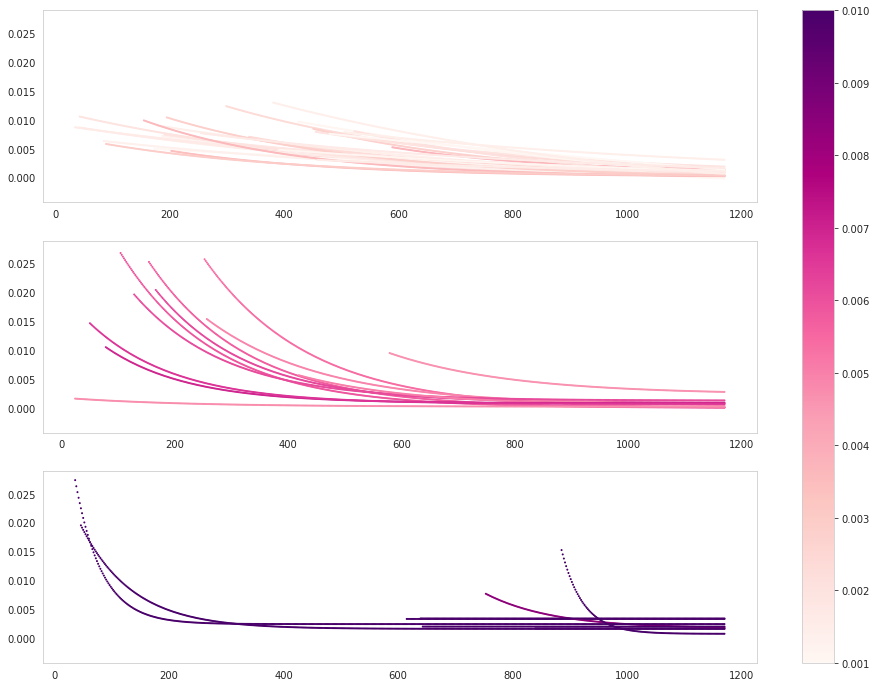

<Figure size 432x288 with 0 Axes>

In [238]:
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig, axs = plt.subplots(3, 1, sharey=True, figsize=(16,12))

plot = axs[0].scatter(data=all_curves[(all_curves.a >=0) &
                                       (all_curves.k < 0.004)], 
                        x='time', 
                        y='std', 
                        s=1, 
                        cmap='RdPu', 
                        c='k', 
                        vmax=0.01,
                        vmin=0.001)

plot = axs[1].scatter(data=all_curves[(all_curves.a >=0) &
                                       (all_curves.k >= 0.004) &
                                       (all_curves.k < 0.008)], 
                        x='time', 
                        y='std', 
                        s=1, 
                        cmap='RdPu', 
                        c='k', 
                        vmax=0.01,
                        vmin=0.001)

plot = axs[2].scatter(data=all_curves[(all_curves.a >=0) &
                                       (all_curves.k >= 0.008)], 
                        x='time', 
                        y='std', 
                        s=1, 
                        cmap='RdPu', 
                        c='k', 
                        vmax=0.01,
                        vmin=0.001)

plt.colorbar(plot, ax=axs.ravel().tolist(), location='right')

fig.savefig(images_eps_base_path + 'k_exp_model' + '.eps', format='eps')
fig.savefig(images_base_path + 'k_exp_model' + '.png')

plt.show()

plt.clf()
plt.close(fig)

In [351]:
all_curves

,a,c,k,std,tag,time
0,0.013876,-0.000318,0.002709,0.006573,step_shear_data_10_mbar_2016_08_02_Exp_01,258.441781
1,0.013876,-0.000318,0.002709,0.006536,step_shear_data_10_mbar_2016_08_02_Exp_01,260.445205
2,0.013876,-0.000318,0.002709,0.006499,step_shear_data_10_mbar_2016_08_02_Exp_01,262.448630
3,0.013876,-0.000318,0.002709,0.006462,step_shear_data_10_mbar_2016_08_02_Exp_01,264.452055
4,0.013876,-0.000318,0.002709,0.006425,step_shear_data_10_mbar_2016_08_02_Exp_01,266.455479
...,...,...,...,...,...,...
20300,-0.005870,0.006236,0.009796,0.006236,step_shear_data_6_mbar_2016_08_12_Exp_04,1161.986301
20301,-0.005870,0.006236,0.009796,0.006236,step_shear_data_6_mbar_2016_08_12_Exp_04,1163.989726
20302,-0.005870,0.006236,0.009796,0.006236,step_shear_data_6_mbar_2016_08_12_Exp_04,1165.993151
20303,-0.005870,0.006236,0.009796,0.006236,step_shear_data_6_mbar_2016_08_12_Exp_04,1167.996575


In [352]:
only_stat_curves = pd.DataFrame()

for index, row in step_stress_statistics_df.iterrows():
    A = row['std_exp_coeff_A']
    K = row['std_exp_coeff_K']
    C = row['std_exp_coeff_C']
    std = row['std']
    
    std_argmax = np.argmax(std)

    y = std[std_argmax:]
    t = np.linspace(0, len(std), len(std)) * 2
    t=t[std_argmax:]
    fit_y = func(t, A, K, C)
    step_t_index = 0
    for step_t in t:
        only_stat_curves = only_stat_curves.append({'tag': row['tag'], 
                                                    'time': step_t, 
                                                    'std': fit_y[step_t_index], 
                                                    'k': K,
                                                    'a': A,
                                                    'c': C}, ignore_index=True)
        step_t_index = step_t_index + 1

In [364]:
step_stress_statistics_df['std_exp_coeff_K']

0     0.002308
1     0.001622
2     0.008461
3     0.005903
4     0.005417
5     0.005769
6     0.006213
7     0.004920
8     0.006140
9     0.001304
10    0.005044
11    0.006949
12    0.001076
13    0.002065
14    0.000306
15    0.002849
16    0.021710
17    0.001400
18    0.001118
19    0.001536
20    0.001645
21    0.001417
22    0.009796
Name: std_exp_coeff_K, dtype: float64

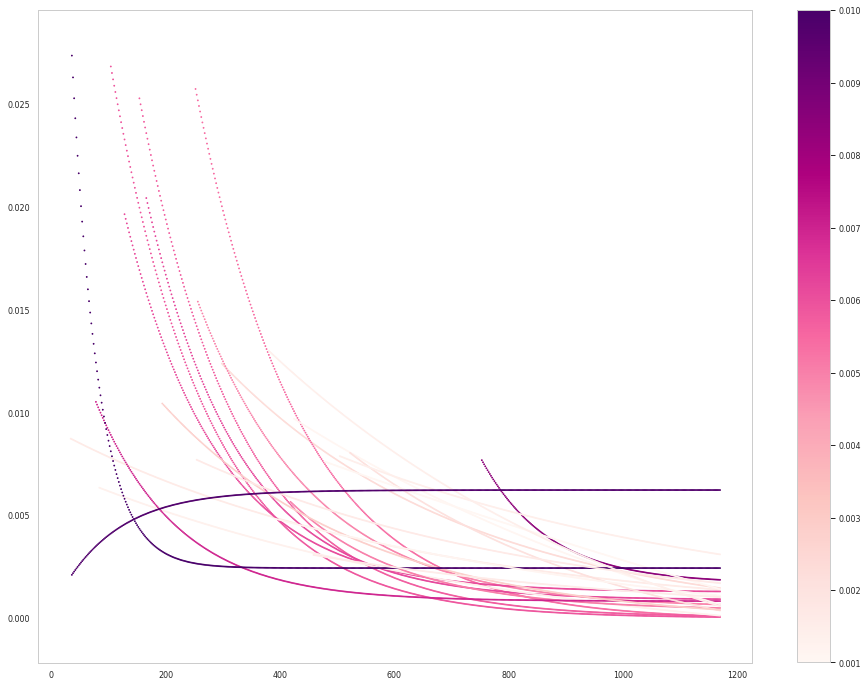

<Figure size 432x288 with 0 Axes>

In [363]:
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16,12))

plot = ax.scatter(data=only_stat_curves, 
                        x='time', 
                        y='std', 
                        s=1, 
                        cmap='RdPu', 
                        c='k', 
                        vmax=0.01,
                        vmin=0.001)


plt.colorbar(plot)

#fig.savefig(images_eps_base_path + 'k_exp_model' + '.eps', format='eps')
#fig.savefig(images_base_path + 'k_exp_model' + '.png')

plt.show()

plt.clf()
plt.close(fig)

## ALL expirments analysis (include non stationarity)

In [309]:
all_step_stress_statistics_df.mbar = all_step_stress_statistics_df.mbar.astype(int)
all_step_stress_statistics_df['sync_rate'] = 1 - (all_step_stress_statistics_df['auc_from_std_max'] / all_step_stress_statistics_df['total_area_from_std_max'])

In [76]:
all_step_stress_statistics_df.groupby(by=['mbar']).count()

,tag,stationarity_level,density,std,max_derivative_std,min_derivative_std,time_max_std,auc_from_std_max,total_area_from_std_max,last_100_mean_std,...,std_exp_coeff_C,mean_std,max_std_value,min_std_value,time_min_std,auc_from_std_max_nt,total_area_from_std_max_nt,base_pickle_path,number_of_cells,sync_rate
mbar,,,,,,,,,,,,,,,,,,,,,
1,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
6,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
10,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
16,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


### stationarity level by mbar

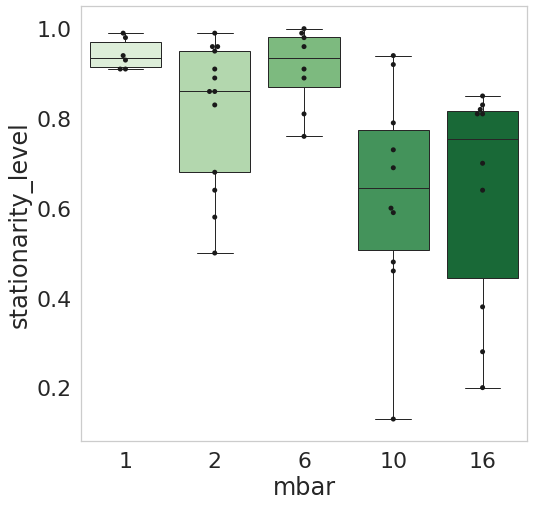

In [125]:
non_stat_table = pd.read_csv(images_base_path + 'non_stationarity.txt', names=['tag', 'stationarity_level', 'density', 'mbar'])
stat_table = pd.read_csv(images_base_path + 'stationarity.txt', names=['tag', 'stationarity_level', 'density', 'mbar'])
full_stat_table = pd.concat([non_stat_table, stat_table]).drop('density', axis=1)

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

plt.figure(figsize=(8,8))

ax = sns.boxplot(x="mbar", y="stationarity_level", data=full_stat_table, palette="Greens", order=[1, 2, 6, 10, 16])
ax = sns.swarmplot(x="mbar", y="stationarity_level", data=full_stat_table, color="0.1", order=[1, 2, 6, 10, 16])


In [457]:
all_step_stress_statistics_df[all_step_stress_statistics_df['stationarity_level'] > 0.85][['tag', 'mbar', 'stationarity_level']]

,tag,mbar,stationarity_level
6,step_shear_data_10_mbar_2016_08_17_Exp_02,10,0.939271
9,step_shear_data_10_mbar_2016_08_17_Exp_05,10,0.921739
11,step_shear_data_16_mbar_2016_08_10_Exp_02,16,0.853162
20,step_shear_data_1_mbar_2016_10_12_Exp_01,1,0.909091
21,step_shear_data_1_mbar_2016_10_12_Exp_02,1,0.990177
22,step_shear_data_1_mbar_2016_10_12_Exp_03,1,0.977740
23,step_shear_data_1_mbar_2016_10_12_Exp_04,1,0.911859
24,step_shear_data_1_mbar_2016_10_12_Exp_05,1,0.934183
25,step_shear_data_1_mbar_2016_10_12_Exp_06,1,0.937153
27,step_shear_data_2_mbar_2016_07_24_Exp_02,2,0.859060


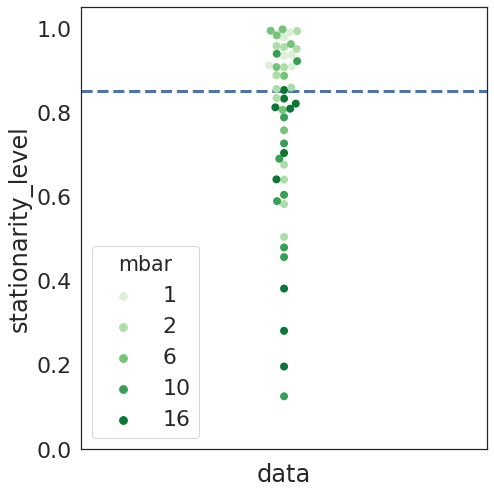

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

In [75]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(8,8))

df_temp = all_step_stress_statistics_df.copy(True)
df_temp['data'] = ''

ax = sns.swarmplot(x='data', 
                   y="stationarity_level", 
                   hue="mbar", 
                   data=df_temp, 
                   palette="Greens",
                   size=8)

ax.axhline(y=0.85, xmin=0, xmax=1, linestyle='--')

#ax.annotate("n={}, #1 bar = {}, #2 bar = {}".format(len(df_temp),
#            len(df_temp[df_temp['mbar'] == '1']),
#            len(df_temp[df_temp['mbar'] == '2'])),
#            xy=(.1, .9), xycoords=ax.transAxes, fontsize=11)

ax.set_ylim(0)
plt.tight_layout(pad=2, w_pad=0.2, h_pad=0.2)

plt.show()

fig.savefig(images_eps_base_path + '_S2_stationarity_' + '.eps', format='eps')
fig.savefig(images_base_path + '_S2_stationarity_' + '.png')

plt.clf()
plt.close(fig)

In [396]:
# SI sync_rate vs pressure 
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig = plt.figure(figsize=(8,8))

#ax = sns.boxplot(x="mbar", y="sync_rate", data=all_step_stress_statistics_df, 
#                 palette="Greens", 
#                 order=[1, 2, 6, 10, 16])
ax = sns.swarmplot(x="mbar", y="sync_rate", data=all_step_stress_statistics_df, color="0.2", order=[1, 2, 6, 10, 16], palette="Greens")

fig.savefig(images_eps_base_path + 'sync_rate_versus_mbar' + '.eps', format='eps')
fig.savefig(images_base_path + 'sync_rate_versus_mbar' + '.png')

plt.clf()
plt.close(fig)

In [256]:
all_step_stress_statistics_df.shape

(47, 26)

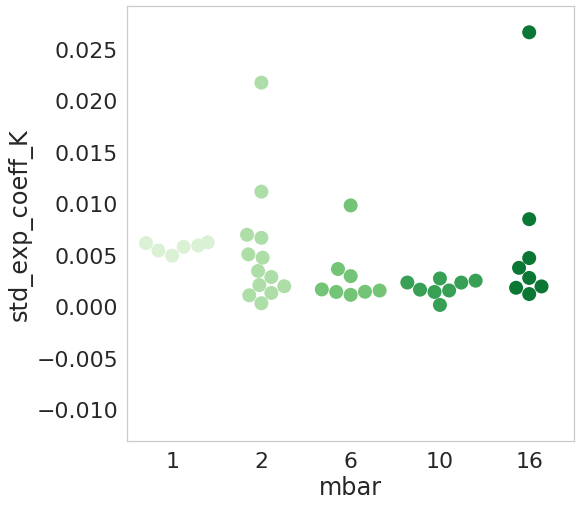

<Figure size 432x288 with 0 Axes>

In [436]:
# SI sync_rate vs pressure 
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig = plt.figure(figsize=(8,8))

#ax = sns.boxplot(x="mbar", y="std_exp_coeff_K", data=all_step_stress_statistics_df[all_step_stress_statistics_df.std_exp_coeff_K <= 0.1], 
#                 palette="Greens", 
#                 order=[1, 2, 6, 10, 16])
ax = sns.swarmplot(x="mbar", y="std_exp_coeff_K", 
                   data=all_step_stress_statistics_df[all_step_stress_statistics_df.std_exp_coeff_K <= 0.1], 
                   color="0.2", 
                   order=[1, 2, 6, 10, 16],
                   palette="Greens",
                   size=14)

plt.show()

fig.savefig(images_eps_base_path + 'std_exp_coeff_K_boxes' + '.eps', format='eps')
fig.savefig(images_base_path + 'std_exp_coeff_K_vs_boxes' + '.png')

plt.clf()
plt.close(fig)

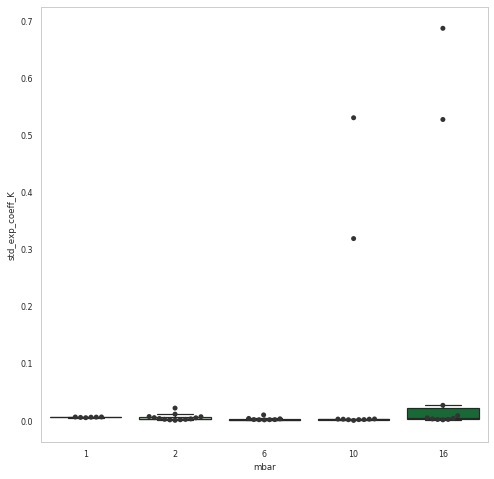

In [181]:
# SI sync_rate vs pressure 
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

plt.figure(figsize=(8,8))

ax = sns.boxplot(x="mbar", y="std_exp_coeff_K", data=all_step_stress_statistics_df, 
                 palette="Greens", 
                 order=[1, 2, 6, 10, 16], showfliers=False)
ax = sns.swarmplot(x="mbar", y="std_exp_coeff_K", data=all_step_stress_statistics_df, color="0.2", order=[1, 2, 6, 10, 16])

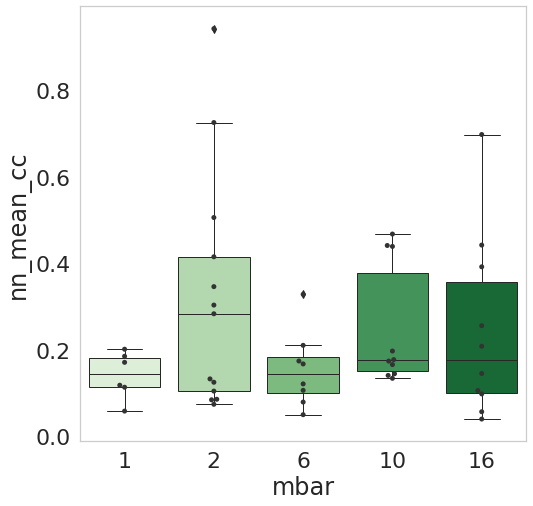

In [127]:
# SI sync_rate vs pressure 
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

plt.figure(figsize=(8,8))

ax = sns.boxplot(x="mbar", y="nn_mean_cc", data=all_step_stress_statistics_df, 
                 palette="Greens", 
                 order=[1, 2, 6, 10, 16])
ax = sns.swarmplot(x="mbar", y="nn_mean_cc", data=all_step_stress_statistics_df, color="0.2", order=[1, 2, 6, 10, 16])

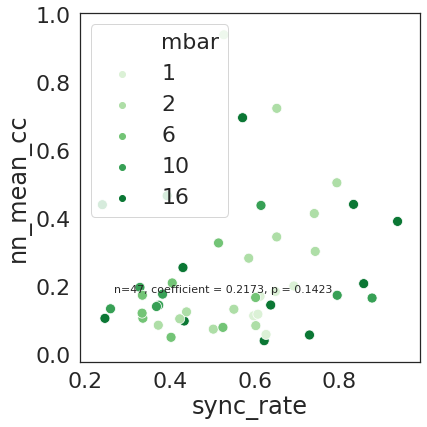

<Figure size 432x288 with 0 Axes>

In [128]:
plot_scatter_mbar_color(all_step_stress_statistics_df, 'sync_rate', 'nn_mean_cc', 
                        prefix='',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set="Greens")

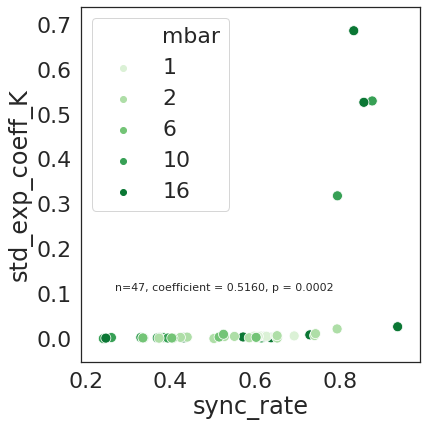

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

In [257]:
plot_scatter_mbar_color(all_step_stress_statistics_df, 'sync_rate', 'std_exp_coeff_K', 
                        prefix='',save=True, xlim=None, ylim=None, xlog=False, ylog=False, color_set="Greens")

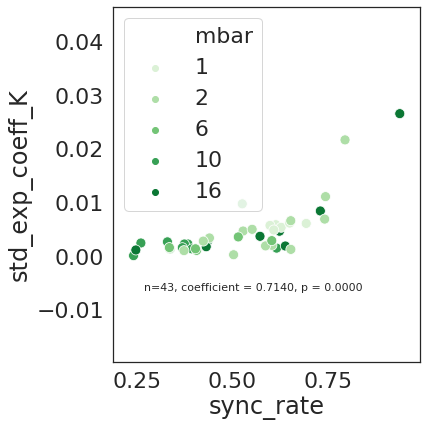

<Figure size 432x288 with 0 Axes>

In [442]:
#exclude outliers
plot_scatter_mbar_color(all_step_stress_statistics_df[all_step_stress_statistics_df.std_exp_coeff_K < 0.1], 'sync_rate', 'std_exp_coeff_K', 
                        prefix='',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set="Greens")

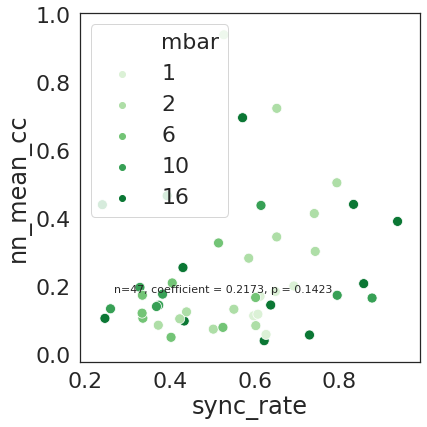

<Figure size 432x288 with 0 Axes>

In [14]:
plot_scatter_mbar_color(all_step_stress_statistics_df, 'sync_rate', 'nn_mean_cc', 
                        prefix='',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set="Greens")

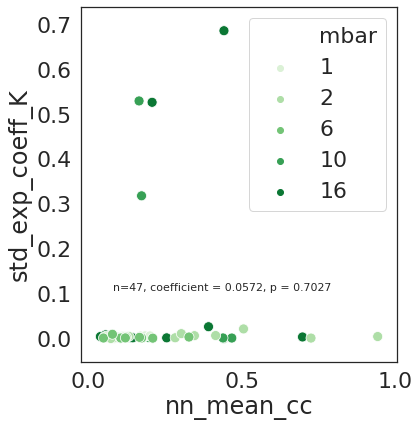

<Figure size 432x288 with 0 Axes>

In [15]:
plot_scatter_mbar_color(all_step_stress_statistics_df, 'nn_mean_cc', 'std_exp_coeff_K', 
                        prefix='',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set="Greens")

In [16]:
all_step_stress_statistics_df['above_th'] = all_step_stress_statistics_df['stationarity_level'] >= 0.85

In [17]:
all_step_stress_statistics_df[['tag','stationarity_level', 'mbar', 'number_of_cells', 'above_th']]

,tag,stationarity_level,mbar,number_of_cells,above_th
0,step_shear_data_10_mbar_2016_08_02_Exp_01,0.456432,10,482.0,False
1,step_shear_data_10_mbar_2016_08_02_Exp_02,0.604278,10,561.0,False
2,step_shear_data_10_mbar_2016_08_02_Exp_03,0.125926,10,540.0,False
3,step_shear_data_10_mbar_2016_08_02_Exp_04,0.589286,10,504.0,False
4,step_shear_data_10_mbar_2016_08_02_Exp_05,0.689922,10,645.0,False
5,step_shear_data_10_mbar_2016_08_17_Exp_01,0.788265,10,784.0,False
6,step_shear_data_10_mbar_2016_08_17_Exp_02,0.939271,10,741.0,True
7,step_shear_data_10_mbar_2016_08_17_Exp_03,0.726368,10,804.0,False
8,step_shear_data_10_mbar_2016_08_17_Exp_04,0.479339,10,968.0,False
9,step_shear_data_10_mbar_2016_08_17_Exp_05,0.921739,10,920.0,True


In [18]:
all_step_stress_statistics_df['mbar'] = all_step_stress_statistics_df['mbar'].astype(int)
all_step_stress_statistics_df[['stationarity_level', 
                               'mbar', 
                               'number_of_cells', 
                               'above_th']]\
                            .groupby(by=['mbar'], sort=True)\
                            .agg(['sum', 'mean', 'std', 'count'])

stationarity_level                           number_of_cells              \
                    sum      mean       std count             sum        mean   
mbar                                                                            
1              5.660202  0.943367  0.033655     6          3257.0  542.833333   
2             10.603551  0.815658  0.160339    13          6657.0  512.076923   
6              7.294168  0.911771  0.090463     8          6328.0  791.000000   
10             6.320826  0.632083  0.242184    10          6949.0  694.900000   
16             6.331592  0.633159  0.251418    10          7156.0  715.600000   

                       above_th                            
             std count      sum      mean       std count  
mbar                                                       
1      54.425790     6        6  1.000000  0.000000     6  
2     179.211449    13        8  0.615385  0.506370    13  
6     237.138296     8        6  0.750000  0.462910     8  
10    174.293144    10        2  0.200000  0.421637    10  
16    118.970771    10        1  0.100000  0.316228    10

## Stationarity Experiments Analysis

In [129]:
step_stress_statistics_df.columns

Index(['tag', 'stationarity_level', 'density', 'mbar', 'frac_individual',
       'frac_hub', 'frac_leader', 'frac_normal', 'frac_follower', 'std',
       'max_derivative_std', 'min_derivative_std', 'time_max_std',
       'auc_from_std_max', 'total_area_from_std_max', 'last_100_mean_std',
       'mean_cc', 'nn_mean_cc', 'nn_mean_cc_dist_1', 'hub_indv_perm_scores',
       'orginal_hub_ind_count_ratio', 'std_exp_coeff_A', 'std_exp_coeff_K',
       'std_exp_coeff_C', 'mean_std', 'max_std_value', 'min_std_value',
       'time_min_std', 'auc_from_std_max_nt', 'total_area_from_std_max_nt',
       'analyze_cell_stats_flat', 'base_pickle_path', 'gc_signficant_count',
       'gc_total_test', 'number_of_cells', 'transformed_norm_df'],
      dtype='object')

In [310]:
step_stress_statistics_df['delta_std'] = step_stress_statistics_df['max_derivative_std'] - step_stress_statistics_df['min_derivative_std']
step_stress_statistics_df['sync_rate'] = 1 - (step_stress_statistics_df['auc_from_std_max'] / step_stress_statistics_df['total_area_from_std_max'])
step_stress_statistics_df['sync_rate_nt'] = 1 - (step_stress_statistics_df['auc_from_std_max_nt'] / step_stress_statistics_df['total_area_from_std_max_nt'])

In [12]:
# check why windows of 200 frames was choosed to be the window size
temp = step_stress_statistics_df.copy(deep=True)
temp['std_length'] = list(map(lambda x: len(x), temp['std']))
temp['sync_rate_eow'] = temp['time_max_std'] + 200
temp[['std_length', 'sync_rate_eow', 'time_max_std']]

,std_length,sync_rate_eow,time_max_std
0,585,349,149
1,585,217,17
2,585,576,376
3,585,252,52
4,585,326,126
5,585,277,77
6,585,283,83
7,585,328,128
8,585,264,64
9,585,242,42


In [451]:
temp = step_stress_statistics_df.copy(deep=True)
temp['std_length'] = list(map(lambda x: len(x) * 2, temp['std']))
temp['time_max_std'] =  temp['time_max_std'] * 2
temp['sync_rate_eow'] = temp['time_max_std'] + 400
temp[['std_length', 'sync_rate_eow', 'time_max_std']]

temp.to_csv(images_base_path + '/' + 'window_size.csv')

In [131]:
step_stress_statistics_df['hub_individual_ratio'] = step_stress_statistics_df['frac_hub'] / step_stress_statistics_df['frac_individual']

In [14]:
step_stress_statistics_df[['tag', 'sync_rate', 'total_area_from_std_max']]

,tag,sync_rate,total_area_from_std_max
0,step_shear_data_10_mbar_2016_08_17_Exp_02,0.374060,2.577548
1,step_shear_data_10_mbar_2016_08_17_Exp_05,0.368680,1.786314
2,step_shear_data_16_mbar_2016_08_10_Exp_02,0.729554,2.519982
3,step_shear_data_1_mbar_2016_10_12_Exp_01,0.613042,5.233259
4,step_shear_data_1_mbar_2016_10_12_Exp_02,0.627122,5.561048
5,step_shear_data_1_mbar_2016_10_12_Exp_03,0.597914,4.823908
6,step_shear_data_1_mbar_2016_10_12_Exp_04,0.649075,4.688106
7,step_shear_data_1_mbar_2016_10_12_Exp_05,0.607829,3.587207
8,step_shear_data_1_mbar_2016_10_12_Exp_06,0.692625,5.135334
9,step_shear_data_2_mbar_2016_07_24_Exp_02,0.652435,2.422790


In [15]:
sync_rate_fix_analysis = pd.DataFrame(columns=['tag', 'fixed_sync_rate', 'sync_rate', 'auc_rate', 'total_area'])
for index, step_data in step_stress_statistics_df.iterrows():
    time_max_std = step_data['time_max_std']
    std = step_data['std']
    auc = np.trapz(std[time_max_std:time_max_std + 200])
    total_area = std[time_max_std] * len(std[time_max_std:time_max_std + 200])
    auc_before_fix = np.trapz(std[time_max_std:])
    total_area_fix = std[time_max_std] * 200
    sync_rate_fix_analysis = sync_rate_fix_analysis.append({'tag': step_data['tag'],
                                                            'fixed_sync_rate': 1 - (auc/total_area), 
                                                            'sync_rate': auc_before_fix/total_area_fix,
                                                            'auc_rate': auc_before_fix,
                                                            'total_area': total_area_fix},
                                                          ignore_index=True)
    
sync_rate_fix_analysis

,tag,fixed_sync_rate,sync_rate,auc_rate,total_area
0,step_shear_data_10_mbar_2016_08_17_Exp_02,0.374060,0.879143,2.266034,2.577548
1,step_shear_data_10_mbar_2016_08_17_Exp_05,0.368680,1.280684,2.287705,1.786314
2,step_shear_data_16_mbar_2016_08_10_Exp_02,0.729554,0.275190,0.693473,2.519982
3,step_shear_data_1_mbar_2016_10_12_Exp_01,0.613042,0.433525,2.268750,5.233259
4,step_shear_data_1_mbar_2016_10_12_Exp_02,0.627122,0.417807,2.323444,5.561048
5,step_shear_data_1_mbar_2016_10_12_Exp_03,0.597914,0.455931,2.199371,4.823908
6,step_shear_data_1_mbar_2016_10_12_Exp_04,0.649075,0.429285,2.012535,4.688106
7,step_shear_data_1_mbar_2016_10_12_Exp_05,0.607829,0.479954,1.721693,3.587207
8,step_shear_data_1_mbar_2016_10_12_Exp_06,0.692625,0.418836,2.150861,5.135334
9,step_shear_data_2_mbar_2016_07_24_Exp_02,0.652435,0.564276,1.367123,2.422790


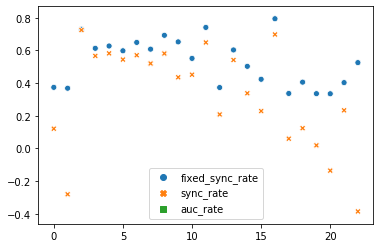

(-0.30019044224606717, 0.1640065935910353)


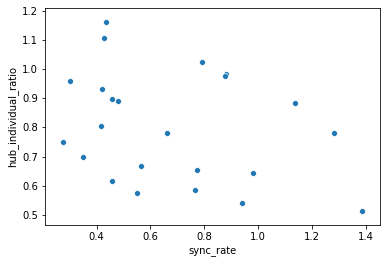

In [16]:
sync_rate_fix_analysis = pd.DataFrame(columns=['tag', 'fixed_sync_rate', 'sync_rate', 'auc_rate'])
for index, step_data in step_stress_statistics_df.iterrows():
    time_max_std = step_data['time_max_std']
    std = step_data['std']
    auc = np.trapz(std[time_max_std:time_max_std + 200])
    total_area = std[time_max_std] * len(std[time_max_std:time_max_std + 200])
    auc_before_fix = np.trapz(std[time_max_std:])
    total_area_fix = std[time_max_std] * 200
    sync_rate_fix_analysis = sync_rate_fix_analysis.append({'tag': step_data['tag'],
                                                            'fixed_sync_rate': 1 - (auc/total_area), 
                                                            'sync_rate': 1 - (auc_before_fix/total_area_fix)},
                                                          ignore_index=True)

sns.scatterplot(data=sync_rate_fix_analysis.drop(['tag'], axis=1))

plt.show()

import scipy.stats as stats
sns.scatterplot(x=(1-sync_rate_fix_analysis['sync_rate']), y=step_stress_statistics_df['hub_individual_ratio'])
print(stats.pearsonr(x=(1-sync_rate_fix_analysis['sync_rate']), y=step_stress_statistics_df['hub_individual_ratio']))

plt.show()

In [17]:
step_stress_statistics_df[['tag', 'std_exp_coeff_A', 'std_exp_coeff_K', 'std_exp_coeff_C', 'mean_cc', 'last_100_mean_std', 'number_of_cells', 'mbar']]

,tag,std_exp_coeff_A,std_exp_coeff_K,std_exp_coeff_C,mean_cc,last_100_mean_std,number_of_cells,mbar
0,step_shear_data_10_mbar_2016_08_17_Exp_02,0.025099,0.002308,-0.000217,0.373019,0.002138,741.0,10
1,step_shear_data_10_mbar_2016_08_17_Exp_05,0.009234,0.001622,0.000000,0.124800,0.001216,920.0,10
2,step_shear_data_16_mbar_2016_08_10_Exp_02,3.514359,0.008461,0.001695,0.038149,0.002156,933.0,16
3,step_shear_data_1_mbar_2016_10_12_Exp_01,0.049624,0.005903,0.000008,0.154429,0.000542,528.0,1
4,step_shear_data_1_mbar_2016_10_12_Exp_02,0.101391,0.005417,-0.000084,0.046431,0.000576,509.0,1
5,step_shear_data_1_mbar_2016_10_12_Exp_03,0.061474,0.005769,0.000041,0.098567,0.000566,584.0,1
6,step_shear_data_1_mbar_2016_10_12_Exp_04,0.054921,0.006213,0.000891,0.178388,0.000743,624.0,1
7,step_shear_data_1_mbar_2016_10_12_Exp_05,0.052614,0.004920,0.000500,0.095107,0.000744,471.0,1
8,step_shear_data_1_mbar_2016_10_12_Exp_06,0.040388,0.006140,0.001273,0.167502,0.000614,541.0,1
9,step_shear_data_2_mbar_2016_07_24_Exp_02,0.009169,0.001304,-0.001867,0.716641,0.000424,298.0,2


In [18]:
step_stress_statistics_df[['tag', 'stationarity_level', 'mbar', 'number_of_cells']]

,tag,stationarity_level,mbar,number_of_cells
0,step_shear_data_10_mbar_2016_08_17_Exp_02,0.939271,10,741.0
1,step_shear_data_10_mbar_2016_08_17_Exp_05,0.921739,10,920.0
2,step_shear_data_16_mbar_2016_08_10_Exp_02,0.853162,16,933.0
3,step_shear_data_1_mbar_2016_10_12_Exp_01,0.909091,1,528.0
4,step_shear_data_1_mbar_2016_10_12_Exp_02,0.990177,1,509.0
5,step_shear_data_1_mbar_2016_10_12_Exp_03,0.977740,1,584.0
6,step_shear_data_1_mbar_2016_10_12_Exp_04,0.911859,1,624.0
7,step_shear_data_1_mbar_2016_10_12_Exp_05,0.934183,1,471.0
8,step_shear_data_1_mbar_2016_10_12_Exp_06,0.937153,1,541.0
9,step_shear_data_2_mbar_2016_07_24_Exp_02,0.859060,2,298.0


In [19]:
from pyemd import emd

def mean_array(arr):
    result = np.zeros(len(arr) - 1)
    for min_idx in range(0, len(arr) - 1, 1):
        result[min_idx] = np.mean(arr[min_idx:min_idx + 2])
    
    return result

def calc_distance_between_grid(pix, piy):
    X, Y = np.meshgrid(pix, piy)
    # Compute pariwise distances between points on 2D grid so we know
    # how to score the Wasserstein distance
    coords = np.array([X.flatten(), Y.flatten()]).T    
    coordsSqr = np.sum(coords**2, 1)
    M = coordsSqr[:, None] + coordsSqr[None, :] - 2*coords.dot(coords.T)
    M[M < 0] = 0
    M = np.sqrt(M)
    
    return M

def calc_homogeneity_score(transformed_norm_df):
    xy_min = [-0.5, -0.5]
    xy_max = [0.5, 0.5]
    range = [[xy_min[0], xy_max[0]], [xy_min[1], xy_max[1]]]
    number_of_bins = 20
    
    H_i, xedges_i, yedges_i = np.histogram2d(transformed_norm_df[:, 0], 
                                transformed_norm_df[:, 1], bins=number_of_bins, range=range, density=True)
    
    uniform_data = np.ones(H_i.shape)
    uniform_data = uniform_data/uniform_data.sum()
    
    square_size = (xedges_i[1]-xedges_i[0]) * (yedges_i[2]-yedges_i[1])
    uniform_data = uniform_data/square_size

    distance_matrix = calc_distance_between_grid(mean_array(xedges_i), mean_array(yedges_i))
        
    return emd(H_i.flatten() * square_size, uniform_data.flatten() *square_size, distance_matrix)



In [20]:
step_stress_statistics_df[['auc_from_std_max_nt', 'total_area_from_std_max_nt', 'auc_from_std_max', 'total_area_from_std_max']]

,auc_from_std_max_nt,total_area_from_std_max_nt,auc_from_std_max,total_area_from_std_max
0,2.266034,5.619055,1.613392,2.577548
1,2.287705,5.073133,1.127736,1.786314
2,0.693473,2.633382,0.681519,2.519982
3,2.268750,13.946636,2.025052,5.233259
4,2.323444,12.762605,2.073595,5.561048
5,2.199371,12.252726,1.939628,4.823908
6,2.012535,11.767145,1.645171,4.688106
7,1.721693,8.196769,1.406800,3.587207
8,2.150861,13.377545,1.578474,5.135334
9,1.367123,6.577875,0.842078,2.422790


## Comparison between sync rate without fixed window and with fixed window

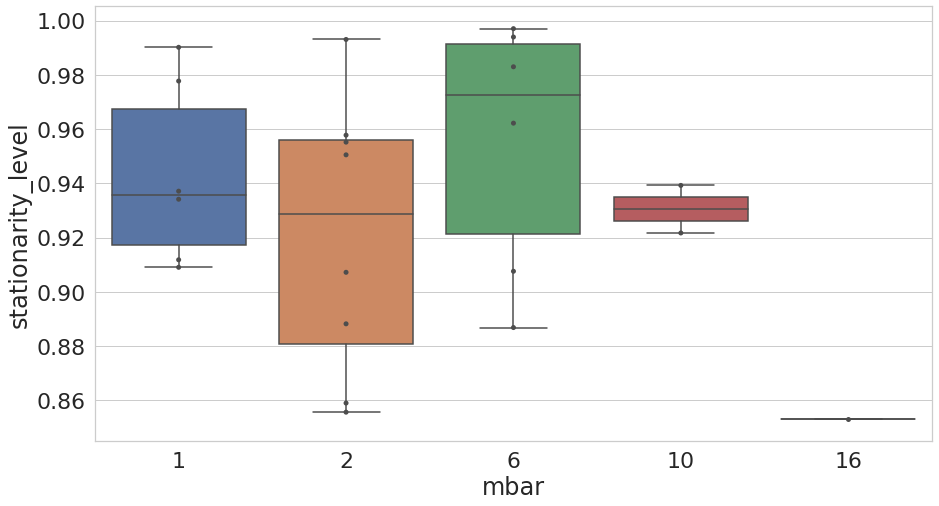

In [21]:
import seaborn as sns

sns.set(style='whitegrid', font_scale=2)

plt.figure(figsize=(15,8))

ax = sns.boxplot(x="mbar", y="stationarity_level", data=step_stress_statistics_df, order=['1', '2', '6', '10', '16'])
ax = sns.swarmplot(x="mbar", y="stationarity_level", data=step_stress_statistics_df, color="0.3", order=['1', '2', '6', '10', '16'])

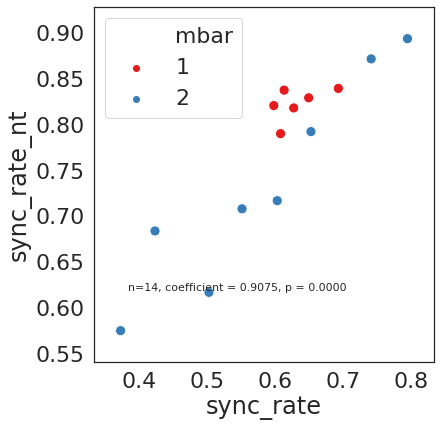

<Figure size 432x288 with 0 Axes>

In [22]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'sync_rate', 'sync_rate_nt', 
                        prefix='',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

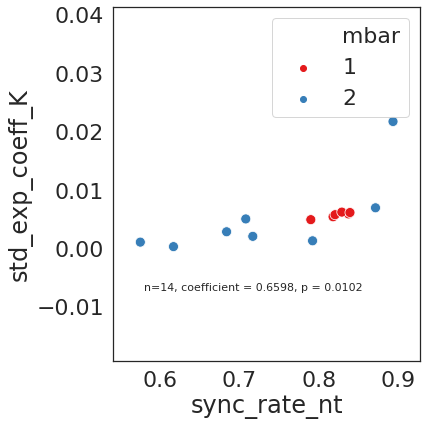

<Figure size 432x288 with 0 Axes>

In [23]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'sync_rate_nt', 'std_exp_coeff_K', 
                        prefix='',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

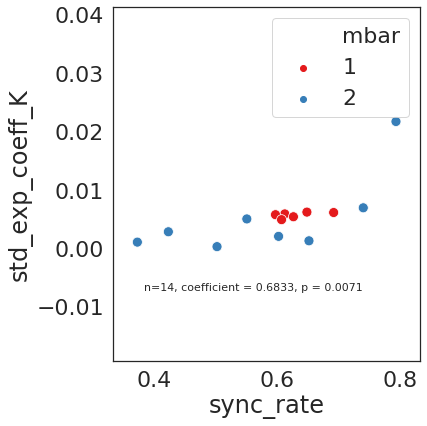

<Figure size 432x288 with 0 Axes>

In [24]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'sync_rate', 'std_exp_coeff_K', 
                        prefix='',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

## Pressure/Density vs Synchoronization Rate

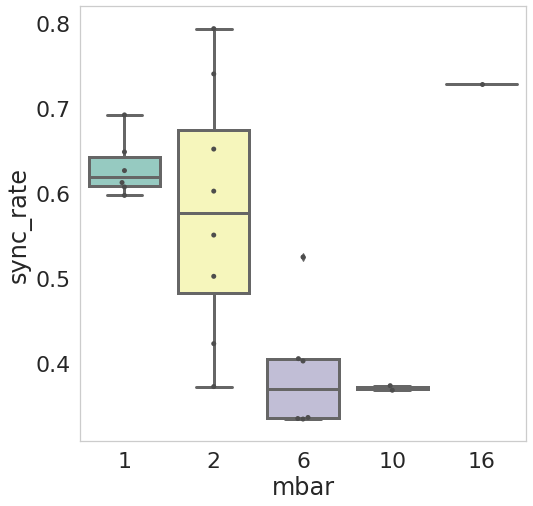

In [25]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

plt.figure(figsize=(8,8))

ax = sns.boxplot(x="mbar", y="sync_rate", data=step_stress_statistics_df, palette="Set3", order=['1', '2', '6', '10', '16'])
ax = sns.swarmplot(x="mbar", y="sync_rate", data=step_stress_statistics_df, color="0.3", order=['1', '2', '6', '10', '16'])

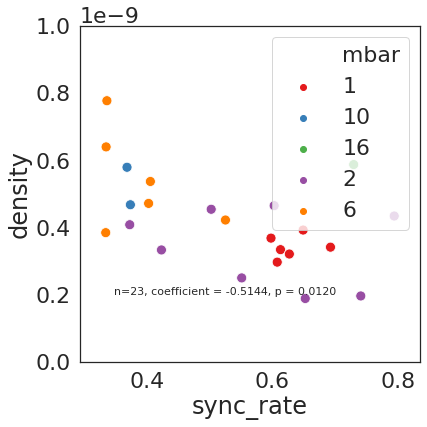

<Figure size 432x288 with 0 Axes>

In [26]:
plot_scatter_mbar_color(step_stress_statistics_df, 'sync_rate', 'density', 
                        prefix='',save=False, xlim=None, ylim=[0, 0.000000001], xlog=False, ylog=False)

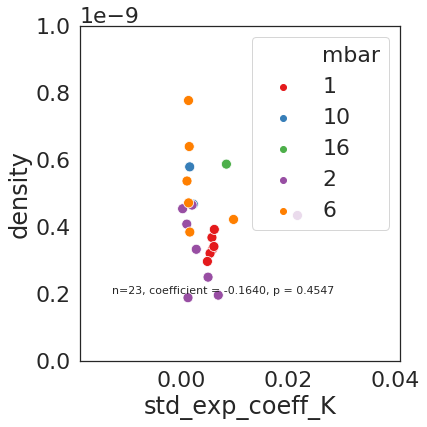

<Figure size 432x288 with 0 Axes>

In [27]:
plot_scatter_mbar_color(step_stress_statistics_df, 'std_exp_coeff_K', 'density', 
                        prefix='',save=False, xlim=None, ylim=[0, 0.000000001], xlog=False, ylog=False)

### Transmission/Reciver Score vs Sync Rate

Index(['tag', 'stationarity_level', 'density', 'mbar', 'frac_individual',
       'frac_hub', 'frac_leader', 'frac_normal', 'frac_follower', 'std',
       'max_derivative_std', 'min_derivative_std', 'time_max_std',
       'auc_from_std_max', 'total_area_from_std_max', 'last_100_mean_std',
       'mean_cc', 'nn_mean_cc', 'nn_mean_cc_dist_1', 'hub_indv_perm_scores',
       'orginal_hub_ind_count_ratio', 'std_exp_coeff_A', 'std_exp_coeff_K',
       'std_exp_coeff_C', 'mean_std', 'max_std_value', 'min_std_value',
       'time_min_std', 'auc_from_std_max_nt', 'total_area_from_std_max_nt',
       'analyze_cell_stats_flat', 'base_pickle_path', 'gc_signficant_count',
       'gc_total_test', 'number_of_cells', 'transformed_norm_df'],
      dtype='object')

In [36]:
from tqdm.notebook import tqdm

rinku_index_tran_results = pd.DataFrame(columns=['rinku_idx'])
rinku_index_rec_results = pd.DataFrame(columns=['rinku_idx'])

for index, step_expirment in tqdm(step_stress_statistics_df.iterrows(), total=step_stress_statistics_df.shape[0]):
    analyze_cell_stat_flat = step_expirment['analyze_cell_stats_flat']
    cell_role_het = calc_h_m(analyze_cell_stat_flat['gc_out'])
    calc_role_het_rec =  calc_h_m(analyze_cell_stat_flat['gc_in']) 
    
    rinku_index_tran_results= rinku_index_tran_results.append({'rinku_idx': cell_role_het},ignore_index=True)
    rinku_index_rec_results= rinku_index_rec_results.append({'rinku_idx': calc_role_het_rec},ignore_index=True)
    
    #r, p_value = pearsonr(analyze_cell_stat_flat['gc_in'], y)
rinku_index_tran_results

,rinku_idx
0,0.481384
1,0.280456
2,0.295303
3,0.480130
4,0.459886
5,0.458270
6,0.461085
7,0.484861
8,0.497245
9,0.618999


In [ ]:
step_stress_statistics_df['rinku_index_tran'] = rinku_index_tran_results.values
step_stress_statistics_df['rinku_index_rec'] = rinku_index_rec_results.values

sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale':1})
sns.set_context("paper", font_scale=0.9)

def corrfunc_pairplot(x, y, ax=None, **kws):
    from scipy.stats import pearsonr
    
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p_value = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f} p_v={p_value:.3f}', xy=(.1, .9), xycoords=ax.transAxes)
    
plt.figure(figsize=(25,20))
g = sns.pairplot(data=step_stress_statistics_df[['gc_probability', 'estrada_index', 'rinku_index', 'sync_rate','rinku_index_tran', 'rinku_index_rec']], corner=True)
g.map_lower(corrfunc_pairplot)
plt.show()


<Figure size 1800x1440 with 0 Axes>

## Heterogeneity (Local) vs Sync Rate (Global)

## Estrada’s index

In [56]:
from tqdm.notebook import tqdm
import random

def estrada_index(analyze_result_df):
    total = 0
    nodes_degrees = pd.concat([analyze_result_df.groupby(['source', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_out'}),
                    analyze_result_df.groupby(['destination', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_in'})], axis=1)
    n = nodes_degrees.shape[0]    

    for idx, row in analyze_result_df.iterrows():
        if row['significant'] != 1:
            continue
        
        v1 = float(nodes_degrees.loc[row['source']].sum())**(-0.5)
        v2 = float(nodes_degrees.loc[row['destination']].sum())**(-0.5)       
        total += (v1 - v2)**2        

    total /= (n - 2*((n - 1)**0.5))

    return total

def create_random_edges(gc_prob, length):
    list_of_random_0_1 = int(np.round(length*gc_prob))*'1' + int(np.round(length*(1-gc_prob)))*'0'
    list_of_random_0_1 = list(map(int, list_of_random_0_1))
    random.shuffle(list_of_random_0_1)
    return list_of_random_0_1

def estrada_index_perm_test(analyze_result_df, n=1000):
    perm_counter = 0    

    analyze_result_df_random = analyze_result_df.copy()

    gc_prob = analyze_result_df['significant'].sum()/analyze_result_df['significant'].count()

    estrada_idx_score = estrada_index(analyze_result_df)
    
    records = np.zeros((n), dtype='float')

    for i in range(0, n):
        analyze_result_df_random['significant'] = create_random_edges(gc_prob, analyze_result_df.shape[0])    
        random_estrada_idx_score = estrada_index(analyze_result_df_random)

        if estrada_idx_score < random_estrada_idx_score:
            perm_counter += 1
        
        records[i] = random_estrada_idx_score

    return perm_counter/n, records

estrada_index_results = load_object(images_pickle_base_path + 'estrada_index_results_PA')
estrada_index_records = load_object(images_pickle_base_path + 'estrada_index_records_PA')

if (estrada_index_results is None) and (estrada_index_records is None):
    row = 0

    estrada_index_results = pd.DataFrame(columns=['est_idx_p_value', 'est_idx'])
    estrada_index_records = pd.DataFrame()

    for index, step_expirment in tqdm(step_stress_statistics_df.iterrows(), total=step_stress_statistics_df.shape[0]):
        analyze_result_df = load_object(step_expirment['base_pickle_path'] + 'analyze_result_df')
        estrada_index_result = estrada_index(analyze_result_df)
        estrada_index_perm_test_result, records = estrada_index_perm_test(analyze_result_df)

        estrada_index_results.loc[row] = (estrada_index_perm_test_result, estrada_index_result)
        estrada_index_records[row] =  records

        row += 1

    save_object(estrada_index_results, images_pickle_base_path + 'estrada_index_results_PA')
    save_object(estrada_index_records, images_pickle_base_path + 'estrada_index_records_PA')

estrada_index_results

,est_idx_p_value,est_idx
0,0.000,0.037480
1,0.000,0.083630
2,1.000,0.056346
3,0.000,0.055284
4,0.000,0.052427
5,0.000,0.046028
6,0.000,0.051549
7,0.000,0.060496
8,0.000,0.056994
9,0.000,0.053116


In [272]:
def estrada_index(analyze_result_df):
    total = 0
    nodes_degrees = pd.concat([analyze_result_df.groupby(['source', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_out'}),
                    analyze_result_df.groupby(['destination', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_in'})], axis=1)
    n = nodes_degrees.shape[0]    

    for idx, row in analyze_result_df.iterrows():
        if row['significant'] != 1:
            continue
        
        v1 = nodes_degrees.loc[row['source']].sum()**(-0.5)
        v2 = nodes_degrees.loc[row['destination']].sum()**(-0.5)
        total += (v1 - v2)**2

    total /= (n - 2*((n - 1)**0.5))

    return total
    
def select_edges(df: pd.DataFrame):
    first_edge_idx = random.choice(df[df['significant'] == 1].index)
    first_edge_row = df.loc[first_edge_idx]
    first_edge = (first_edge_row['source'], first_edge_row['destination'])
    filter_first_edge_nodes = df[(df['source'] != first_edge[0]) & (df['destination'] != first_edge[1])]

    while True:    
        sec_edge_idx = random.choice(filter_first_edge_nodes[(filter_first_edge_nodes['significant'] == 1)].index)
        sec_edge_row = df.loc[sec_edge_idx]
        sec_edge = (sec_edge_row['source'], sec_edge_row['destination'])

        # check that there is no crossing edges
        if len(df[(df['source'] == first_edge[0]) & (df['destination'] == sec_edge[1])]) > 0:
            if (df[(df['source'] == first_edge[0]) & (df['destination'] == sec_edge[1])]['significant'] == 1).all():                
                continue
        
        if len(df[(df['source'] == sec_edge[0]) & (df['destination'] == first_edge[1])]) > 0:
            if (df[(df['source'] == sec_edge[0]) & (df['destination'] == first_edge[1])]['significant'] == 1).all():
                continue
        
        break

    return first_edge, sec_edge, first_edge_idx, sec_edge_idx

def add_edge(df: pd.DataFrame, first_node_idx: int, sec_node_idx: int, part: int):
    if len(df[(df['source'] == first_node_idx) & (df['destination'] == sec_node_idx)]) > 0:
        first_edge_idx = df[(df['source'] == first_node_idx) & (df['destination'] == sec_node_idx)].index        
        assert (df.loc[first_edge_idx, 'significant'] != 1).all()
        df.loc[first_edge_idx, 'significant'] = 1
    else:
        #add new edge
       df = df.append({ 'source': first_node_idx,
                        'destination': sec_node_idx,
                        'part': part,
                        'topological_distance': None,
                        'optimal_lag': None,
                        'granger_causality_mag': None,
                        'granger_causality_pvalue': None,
                        'total_neighbours': None,
                        'critical_value': None,
                        'significant': 1}, ignore_index=True)
    
    return df

def rewire(df: pd.DataFrame, part: int):
    first_edge, sec_edge, first_edge_idx, sec_edge_idx = select_edges(df)
    df.loc[first_edge_idx, 'significant'] = 0
    df.loc[sec_edge_idx, 'significant'] = 0

    df = add_edge(df, first_edge[0], sec_edge[1], part)
    df = add_edge(df, sec_edge[0], first_edge[1], part)
    
    return df

def permute_edges_degree_preservation(df: pd.DataFrame, part: int, repeat_factor: float =10**-6):
    number_of_edges = len(df[df['significant'] == 1])
    total_cycles = int(np.round((number_of_edges/2) * np.log(1/repeat_factor)))
    for round_i in range(0, total_cycles):
        df = rewire(df, part)

    return df

def plot_degree_dist(df: pd.DataFrame):
    df_degree_sum = pd.concat([df.groupby(['source', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_out'}),
                               df.groupby(['destination', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_in'})], axis=1).sum(axis=1)

    sns.distplot(df_degree_sum)


def estrada_index_degree_preservation_perm_test(analyze_result_df: pd.DataFrame, part: int, n: int=1000):
    perm_counter = 0    

    estrada_idx_score = estrada_index(analyze_result_df)
    
    records = np.zeros((n), dtype='float')

    for i in range(0, n):
        analyze_result_df_random = analyze_result_df.copy(deep=True)

        analyze_result_df_random = permute_edges_degree_preservation(df=analyze_result_df_random, part=part)
        
        random_estrada_idx_score = estrada_index(analyze_result_df_random)

        if estrada_idx_score < random_estrada_idx_score:
            perm_counter += 1
        
        records[i] = random_estrada_idx_score

    return perm_counter/n, records

estrada_index_degree_preservation_results = load_object(images_pickle_base_path + 'estrada_index_degree_preservation_results_PA')
estrada_index_degree_preservation_records = load_object(images_pickle_base_path + 'estrada_index_degree_preservation_records_PA')

if (estrada_index_degree_preservation_results is None) and (estrada_index_degree_preservation_records is None):
    estrada_index_degree_preservation_results = pd.DataFrame(columns=['est_idx_p_value', 'est_idx'])
    estrada_index_degree_preservation_records = pd.DataFrame()

    row = 0

    for index, step_expirment in tqdm(step_stress_statistics_df.iterrows(), total=step_stress_statistics_df.shape[0]):
        analyze_result_df = load_object(step_expirment['base_pickle_path'] + 'analyze_result_df')
        estrada_index_result = estrada_index(analyze_result_df)
        estrada_index_perm_test_result, records = estrada_index_degree_preservation_perm_test(analyze_result_df, part=0, n=10)

        estrada_index_degree_preservation_results.loc[row] = (estrada_index_perm_test_result, estrada_index_result)
        estrada_index_degree_preservation_records[row] =  records

        row += 1
    
    save_object(estrada_index_degree_preservation_results, images_pickle_base_path + 'estrada_index_degree_preservation_results_PA')
    save_object(estrada_index_degree_preservation_records, images_pickle_base_path + 'estrada_index_degree_preservation_records_PA')

estrada_index_degree_preservation_records

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.042476,0.099283,0.101439,0.077945,0.090869,0.072775,0.074869,0.100739,0.088229,0.056594,...,0.112378,0.106184,0.108173,0.051224,0.150101,0.131598,0.242193,0.109308,0.090181,0.170935
1,0.042859,0.097188,0.095911,0.080554,0.090415,0.071625,0.072741,0.095925,0.089198,0.056877,...,0.112771,0.104417,0.112333,0.050889,0.149012,0.133987,0.243826,0.108207,0.094054,0.147750
2,0.042112,0.095362,0.100575,0.079397,0.092242,0.073552,0.071666,0.095528,0.090027,0.056554,...,0.109514,0.102804,0.107260,0.051338,0.148588,0.132579,0.238449,0.104041,0.098805,0.162959
3,0.042628,0.102514,0.101052,0.083128,0.095183,0.070260,0.075781,0.098203,0.089360,0.055370,...,0.111410,0.103885,0.108986,0.050698,0.146092,0.134789,0.240119,0.108875,0.094882,0.159188
4,0.041944,0.098358,0.100896,0.080721,0.092444,0.069056,0.076679,0.097384,0.088284,0.056181,...,0.109488,0.112493,0.107895,0.051314,0.152928,0.133751,0.250268,0.106408,0.100223,0.155742
5,0.041709,0.102694,0.098324,0.082642,0.090752,0.071711,0.072692,0.098471,0.090652,0.055574,...,0.108460,0.102425,0.108276,0.050831,0.148684,0.135352,0.244713,0.106958,0.099997,0.169040
6,0.042010,0.100363,0.098971,0.079612,0.090876,0.072314,0.075212,0.096069,0.090106,0.056363,...,0.105449,0.103503,0.109556,0.051271,0.148573,0.135402,0.241355,0.110716,0.093488,0.160903
7,0.042881,0.100414,0.100301,0.081995,0.092470,0.072049,0.072101,0.098557,0.090414,0.057049,...,0.104314,0.105343,0.104912,0.051412,0.147519,0.132415,0.247103,0.110570,0.097515,0.154650
8,0.041669,0.101800,0.098244,0.080729,0.093924,0.070673,0.073629,0.094964,0.089638,0.056947,...,0.110654,0.103252,0.105021,0.051613,0.151295,0.135677,0.240979,0.108554,0.095743,0.158151
9,0.041895,0.100814,0.095836,0.080099,0.090027,0.069883,0.073108,0.093611,0.088707,0.057007,...,0.109594,0.102382,0.107131,0.050872,0.148454,0.133222,0.244098,0.108908,0.097631,0.154156


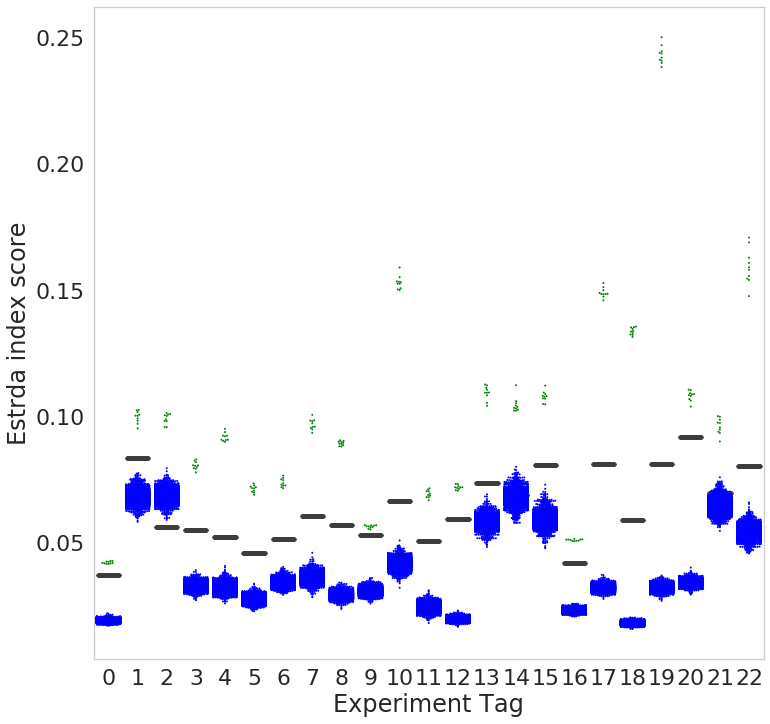

In [134]:
#step_stress_statistics_df['hub_indv_perm_scores']

#sns.boxplot(x="distance", y="method", data=planets,
#            whis=[0, 100],)

# Add in points to show each observation
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig, ax=plt.subplots(figsize=(12,12))

chart = sns.swarmplot(data=estrada_index_records,
              size=2, linewidth=0, color="Blue")

chart = sns.swarmplot(data=estrada_index_degree_preservation_records,
              size=2, color="Green", linewidth=0)

#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

sns.boxplot(x=estrada_index_results['est_idx'].index, y=estrada_index_results['est_idx'].values,
             showcaps=False,boxprops={'facecolor':'None', 'linewidth':5},
             showfliers=False,whiskerprops={'linewidth':0}, ax=chart, palette="Paired")

chart.set(xlabel='Experiment Tag', ylabel='Estrda index score')

#fig.savefig(images_eps_base_path + '_' + 'hub_individual_ratio_perm_test' + '.eps', format='eps')

plt.show()

### Focusing on one experiment

In [93]:
estrada_index_results.loc[11]['est_idx']

0.05065110965691264

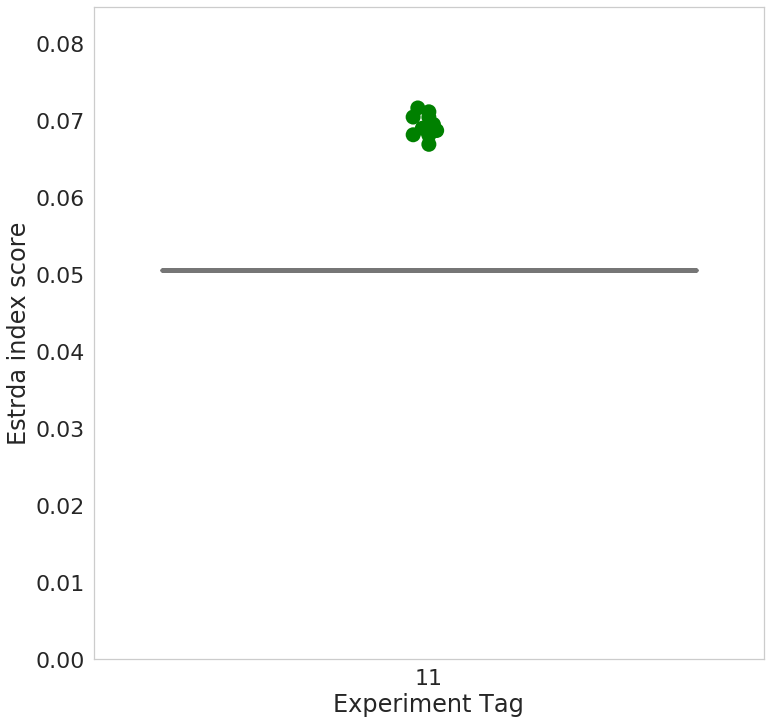

In [135]:
#step_stress_statistics_df['hub_indv_perm_scores']

#sns.boxplot(x="distance", y="method", data=planets,
#            whis=[0, 100],)

# Add in points to show each observation
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig, ax=plt.subplots(figsize=(12,12))

chart = sns.swarmplot(data=estrada_index_degree_preservation_records[11],
              size=15, color="Green", linewidth=0)

#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

sns.boxplot(x=['11'], y=[estrada_index_results.loc[11]['est_idx']],
             showcaps=False,boxprops={'facecolor':'None', 'linewidth':5},
             showfliers=False,whiskerprops={'linewidth':0}, ax=chart, palette="Paired")

chart.set(xlabel='Experiment Tag', ylabel='Estrda index score')

ax.set_ylim(0)

#fig.savefig(images_eps_base_path + '_' + 'hub_individual_ratio_perm_test' + '.eps', format='eps')

plt.show()

In [268]:
#order by mbar
step_stress_statistics_df.mbar = step_stress_statistics_df.mbar.astype(int)
step_stress_statistics_df_orderd_mbar = step_stress_statistics_df.sort_values(by='mbar')

In [277]:
estrada_index_degree_preservation_records.loc[:, step_stress_statistics_df_orderd_mbar.index]

,8,3,4,5,6,7,14,13,12,10,...,16,18,19,20,22,21,17,1,0,2
0,0.088229,0.077945,0.090869,0.072775,0.074869,0.100739,0.106184,0.112378,0.070686,0.152638,...,0.051224,0.131598,0.242193,0.109308,0.170935,0.090181,0.150101,0.099283,0.042476,0.101439
1,0.089198,0.080554,0.090415,0.071625,0.072741,0.095925,0.104417,0.112771,0.072089,0.150155,...,0.050889,0.133987,0.243826,0.108207,0.147750,0.094054,0.149012,0.097188,0.042859,0.095911
2,0.090027,0.079397,0.092242,0.073552,0.071666,0.095528,0.102804,0.109514,0.072420,0.150438,...,0.051338,0.132579,0.238449,0.104041,0.162959,0.098805,0.148588,0.095362,0.042112,0.100575
3,0.089360,0.083128,0.095183,0.070260,0.075781,0.098203,0.103885,0.111410,0.071979,0.155252,...,0.050698,0.134789,0.240119,0.108875,0.159188,0.094882,0.146092,0.102514,0.042628,0.101052
4,0.088284,0.080721,0.092444,0.069056,0.076679,0.097384,0.112493,0.109488,0.071812,0.153609,...,0.051314,0.133751,0.250268,0.106408,0.155742,0.100223,0.152928,0.098358,0.041944,0.100896
5,0.090652,0.082642,0.090752,0.071711,0.072692,0.098471,0.102425,0.108460,0.073395,0.153428,...,0.050831,0.135352,0.244713,0.106958,0.169040,0.099997,0.148684,0.102694,0.041709,0.098324
6,0.090106,0.079612,0.090876,0.072314,0.075212,0.096069,0.103503,0.105449,0.070882,0.152689,...,0.051271,0.135402,0.241355,0.110716,0.160903,0.093488,0.148573,0.100363,0.042010,0.098971
7,0.090414,0.081995,0.092470,0.072049,0.072101,0.098557,0.105343,0.104314,0.071373,0.153263,...,0.051412,0.132415,0.247103,0.110570,0.154650,0.097515,0.147519,0.100414,0.042881,0.100301
8,0.089638,0.080729,0.093924,0.070673,0.073629,0.094964,0.103252,0.110654,0.073316,0.150867,...,0.051613,0.135677,0.240979,0.108554,0.158151,0.095743,0.151295,0.101800,0.041669,0.098244
9,0.088707,0.080099,0.090027,0.069883,0.073108,0.093611,0.102382,0.109594,0.072023,0.159085,...,0.050872,0.133222,0.244098,0.108908,0.154156,0.097631,0.148454,0.100814,0.041895,0.095836


In [286]:
estrada_index_results

,est_idx_p_value,est_idx
0,0.000,0.037480
1,0.000,0.083630
2,1.000,0.056346
3,0.000,0.055284
4,0.000,0.052427
5,0.000,0.046028
6,0.000,0.051549
7,0.000,0.060496
8,0.000,0.056994
9,0.000,0.053116


In [297]:
images_eps_base_path

'./roles_images/eps/'

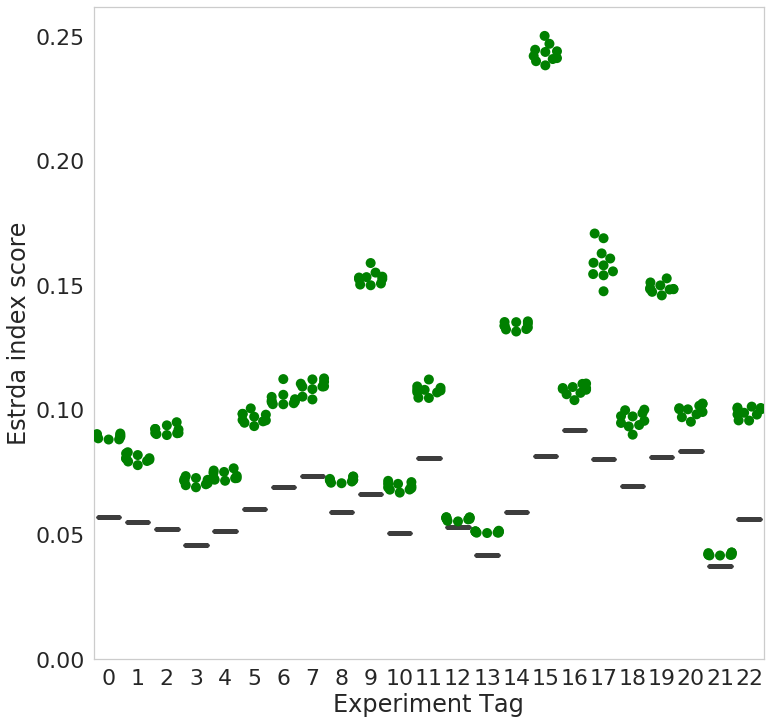

In [298]:
#step_stress_statistics_df['hub_indv_perm_scores']

#sns.boxplot(x="distance", y="method", data=planets,
#            whis=[0, 100],)

# Add in points to show each observation
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig, ax=plt.subplots(figsize=(12,12))

chart = sns.swarmplot(data=estrada_index_degree_preservation_records.loc[:, step_stress_statistics_df_orderd_mbar.index],
              size=10, color="Green", linewidth=0)

#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

sns.boxplot(x=pd.Series(step_stress_statistics_df_orderd_mbar.index.values).sort_values().reset_index(drop=True), 
            y=estrada_index_results.loc[step_stress_statistics_df_orderd_mbar.index]['est_idx'].values,
             showcaps=False,boxprops={'facecolor':'None', 'linewidth':5},
             showfliers=False,whiskerprops={'linewidth':0}, ax=chart, palette="Paired")

chart.set(xlabel='Experiment Tag', ylabel='Estrda index score')

ax.set_ylim(0)

fig.savefig(images_eps_base_path + '_' + 'estrada_degree_preservation_perm_results' + '.eps', format='eps')

plt.show()

## Global Heterogeneity 

raw: 0.29225320774031727
perm 0: 0.256566462164139
perm 1: 0.2628719288115233
perm 2: 0.2628959882635431
perm 3: 0.2628653548077238
perm 4: 0.25652483349223704
perm 5: 0.2565698298843272
perm 6: 0.268993804421024
perm 7: 0.262915838940417
perm 8: 0.26283511227240935
perm 9: 0.2565488145876029


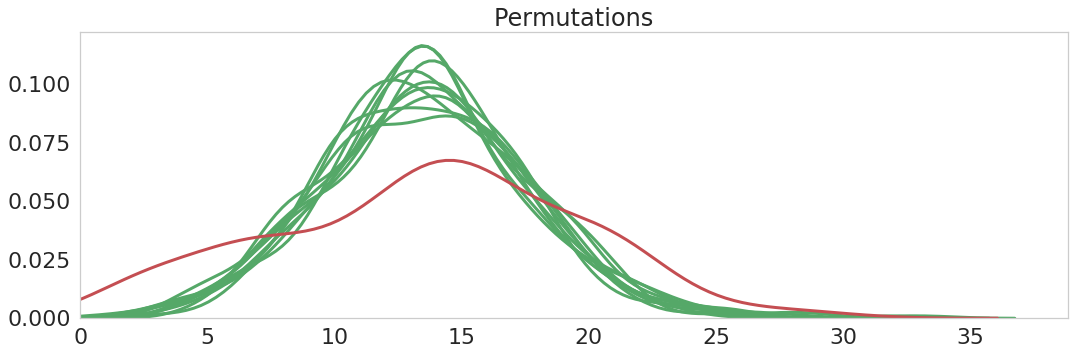

<Figure size 432x288 with 0 Axes>

In [299]:
from scipy.stats import wasserstein_distance

def get_node_degrees(df: pd.DataFrame):
    df_degree_sum = pd.concat([df.groupby(['source', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_out'}),
                               df.groupby(['destination', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_in'})], axis=1).sum(axis=1)

    return df_degree_sum

def calc_h_square(node_degrees):
    values, counts = np.unique(node_degrees, return_counts=True)   
    acc = 0
    for idx in range(len(values)):
        acc += (1 - (counts[idx]/sum(counts)))**2
    
    acc = acc/len(node_degrees)
        
    return acc

def calc_h_het(node_degrees):
    return np.sqrt(1 - 3/len(node_degrees))

def calc_h_m(node_degrees):
    return np.sqrt(calc_h_square(node_degrees))/calc_h_het(node_degrees)

def calc_distance_from_null(analyze_result_df):    
    gc_prob = analyze_result_df['significant'].sum()/analyze_result_df['significant'].count()
    
    null_model = analyze_result_df.copy()
    null_model['significant'] = create_random_edges(gc_prob, analyze_result_df.shape[0])
    
    raw_node_degrees = get_node_degrees(analyze_result_df)
    raw_values, raw_counts = np.unique(raw_node_degrees, return_counts=True)
    raw_counts = raw_counts/sum(raw_counts)
    
    max_degree = 35
    raw_degrees = []
    
    for degree in range(max_degree):
        idx = np.where(raw_values == degree)
        if len(idx[0]) == 0:
            raw_degrees.append(0)
            continue
            
        raw_degrees.append(raw_counts[idx[0]][0])
    
    
    null_node_degrees = get_node_degrees(null_model)
    null_values, null_counts = np.unique(null_node_degrees, return_counts=True)
    null_counts = null_counts/sum(null_counts)
    
    null_degrees = np.array([])
    
    for degree in range(max_degree):
        idx = np.where(null_values == degree)
        if len(idx[0]) == 0:
            null_degrees = np.append(null_degrees, [0])
            continue
        null_degrees = np.append(null_degrees, null_counts[idx[0]])
    
    return wasserstein_distance(u_values=null_degrees, v_values=raw_degrees)
    
def create_degree_distribution_data(step_expirment: pd.Series, filename, n=10, **args):
    fig, axes = plt.subplots(1, 1, figsize=(15, 5), sharey=True, sharex=True)
    
    analyze_result_df = load_object(step_expirment['base_pickle_path'] + 'analyze_result_df')
    
    raw_node_degrees = get_node_degrees(analyze_result_df)
    
    print(f'raw: ' + str(calc_h_m(raw_node_degrees)))
    
    gc_prob = analyze_result_df['significant'].sum()/analyze_result_df['significant'].count()
    
    axes.set_title("Raw")
    axes.set_title("Permutations")
    
    '''
    sum_patch = 0
    for patch in ax.patches:
        sum_patch += patch.get_height() * patch.get_width()
    
    print(sum_patch)
    '''
    
    analyze_result_df_random = analyze_result_df.copy()
    
    for i in range(0, n):
        analyze_result_df_random['significant'] = create_random_edges(gc_prob, analyze_result_df.shape[0])
        perm_node_degrees = get_node_degrees(analyze_result_df_random)
        sns.distplot(ax=axes, a=perm_node_degrees, color="g", bins=range(35), **args)
        print(f'perm {i}: ' + str(calc_h_m(perm_node_degrees)))
    
    ax = sns.distplot(ax=axes, a=raw_node_degrees, color="r", bins=range(35), **args)
    
    ax.set_xlim(xmin=0)
    
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

    plt.show()
    
    fig.savefig(images_eps_base_path + '_' + filename + '.eps', format='eps')
    
    plt.clf()
    plt.close(fig)

    
create_degree_distribution_data(step_stress_statistics_df.loc[11], filename='kde_random_vs_raw', n=10, hist=False)

raw: 0.29225320774031727
perm 0: 0.25661401027936337
perm 1: 0.2566122593718843
perm 2: 0.25009544199527184
perm 3: 0.26287127141854166
perm 4: 0.26289927490298454
perm 5: 0.25654382993772856
perm 6: 0.2565678092575188
perm 7: 0.24343146952983283
perm 8: 0.24343629674456105
perm 9: 0.2565812798023323


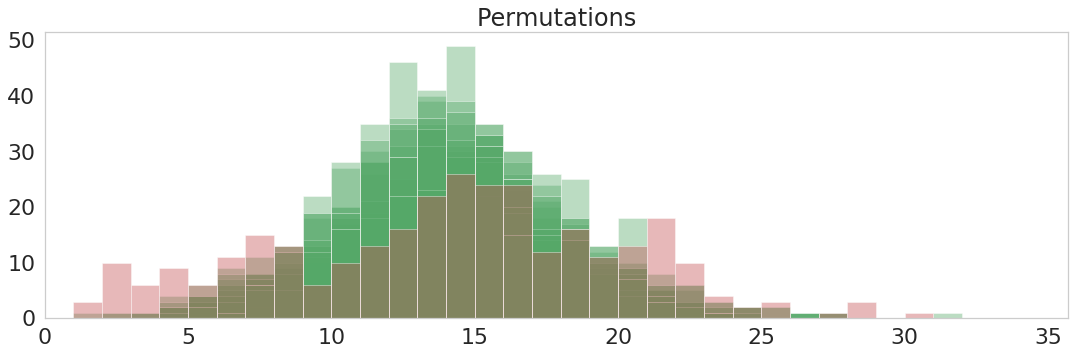

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

In [300]:
create_degree_distribution_data(step_stress_statistics_df.loc[11], filename='hist_random_vs_raw', n=10, kde=False)

In [138]:
step_global_het_results = pd.DataFrame(columns=['global_het_null', 'global_het'])

row = 0

for index, step_expirment in tqdm(step_stress_statistics_df.iterrows(), total=step_stress_statistics_df.shape[0]):
    analyze_result_df = load_object(step_expirment['base_pickle_path'] + 'analyze_result_df')
    raw_node_degrees = get_node_degrees(analyze_result_df)

    step_global_het_results.loc[row] = [calc_distance_from_null(analyze_result_df), calc_h_m(raw_node_degrees)]

    row += 1

step_global_het_results

,global_het_null,global_het
0,0.008753,0.230001
1,0.004845,0.115041
2,0.006125,0.127437
3,0.013420,0.231127
4,0.013584,0.226926
5,0.013845,0.215776
6,0.011996,0.216278
7,0.013709,0.244815
8,0.015949,0.240203
9,0.004027,0.349557


In [301]:
def rinku_index_perm_test(analyze_result_df, n=1000):
    perm_counter = 0    

    analyze_result_df_random = analyze_result_df.copy()

    gc_prob = analyze_result_df['significant'].sum()/analyze_result_df['significant'].count()
    
    raw_node_degrees = get_node_degrees(analyze_result_df)
    rinku_idx_score = calc_h_m(raw_node_degrees)
    
    records = np.zeros((n), dtype='float')

    for i in range(0, n):
        analyze_result_df_random['significant'] = create_random_edges(gc_prob, analyze_result_df.shape[0])
        perm_node_degrees = get_node_degrees(analyze_result_df_random)
        
        random_rinku_idx_score = calc_h_m(perm_node_degrees)

        if rinku_idx_score < random_rinku_idx_score:
            perm_counter += 1
        
        records[i] = random_rinku_idx_score

    return perm_counter/n, records

rinku_index_results = load_object(images_pickle_base_path + 'rinku_index_results_PA')
rinku_index_records = load_object(images_pickle_base_path + 'rinku_index_records_PA')

if (rinku_index_results is None) and (rinku_index_records is None):
    row = 0

    rinku_index_results = pd.DataFrame(columns=['rinku_idx_p_value', 'rinku_idx'])
    rinku_index_records = pd.DataFrame()

    for index, step_expirment in tqdm(step_stress_statistics_df.iterrows(), total=step_stress_statistics_df.shape[0]):
        analyze_result_df = load_object(step_expirment['base_pickle_path'] + 'analyze_result_df')
        raw_node_degrees = get_node_degrees(analyze_result_df)
        rinku_index_result = calc_h_m(raw_node_degrees)
        rinku_index_perm_test_result, records = rinku_index_perm_test(analyze_result_df)

        rinku_index_results.loc[row] = (rinku_index_perm_test_result, rinku_index_result)
        rinku_index_records[row] =  records

        row += 1

    save_object(rinku_index_results, images_pickle_base_path + 'rinku_index_results_PA')
    save_object(rinku_index_records, images_pickle_base_path + 'rinku_index_records_PA')

rinku_index_results

,rinku_idx_p_value,rinku_idx
0,0.0,0.230001
1,0.0,0.115041
2,0.0,0.127437
3,0.0,0.231127
4,0.0,0.226926
5,0.0,0.215776
6,0.0,0.216278
7,0.0,0.244815
8,0.0,0.240203
9,0.0,0.349557


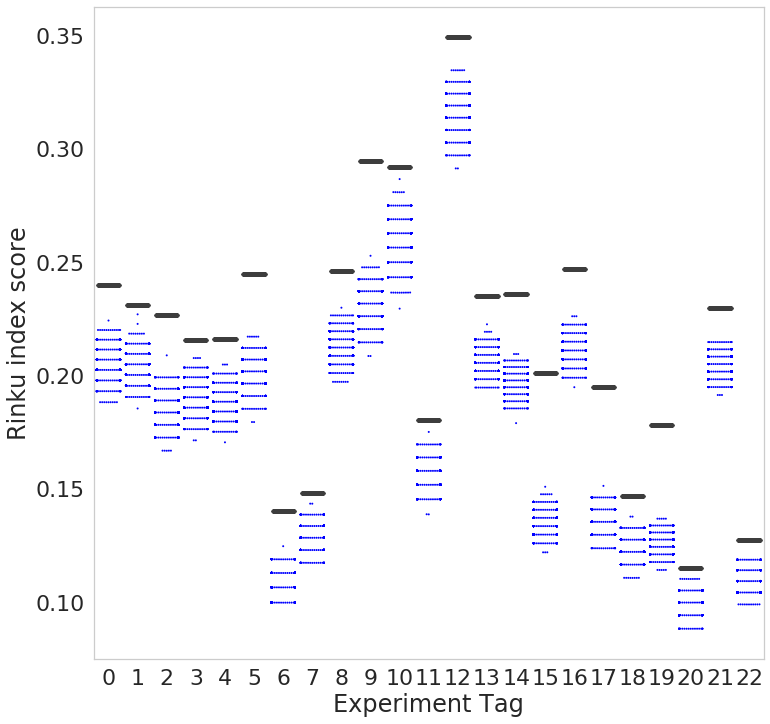

In [304]:
#step_stress_statistics_df['hub_indv_perm_scores']

#sns.boxplot(x="distance", y="method", data=planets,
#            whis=[0, 100],)

# Add in points to show each observation
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig, ax=plt.subplots(figsize=(12,12))

chart = sns.swarmplot(data=rinku_index_records.loc[:, step_stress_statistics_df_orderd_mbar.index],
              size=2, linewidth=0, color="Blue")

#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

sns.boxplot(x=pd.Series(step_stress_statistics_df_orderd_mbar.index.values).sort_values().reset_index(drop=True), 
            y=rinku_index_results.loc[step_stress_statistics_df_orderd_mbar.index]['rinku_idx'].values,
             showcaps=False,boxprops={'facecolor':'None', 'linewidth':5},
             showfliers=False,whiskerprops={'linewidth':0}, ax=chart, palette="Paired")

chart.set(xlabel='Experiment Tag', ylabel='Rinku index score')

fig.savefig(images_eps_base_path + '_' + 'jacob_rinku_global_hetrogenity_perm_results' + '.eps', format='eps')

plt.show()

In [305]:
step_stress_statistics_df['rinku_index'] = rinku_index_results['rinku_idx'].values

In [306]:
step_stress_statistics_df['estrada_index'] = estrada_index_results['est_idx'].values
step_stress_statistics_df['estrada_p_value'] = estrada_index_results['est_idx_p_value'].values

In [307]:
step_stress_statistics_df['gc_probability'] = step_stress_statistics_df['gc_signficant_count'] / step_stress_statistics_df['gc_total_test']

In [144]:
step_stress_statistics_df.columns

Index(['tag', 'stationarity_level', 'density', 'mbar', 'frac_individual',
       'frac_hub', 'frac_leader', 'frac_normal', 'frac_follower', 'std',
       'max_derivative_std', 'min_derivative_std', 'time_max_std',
       'auc_from_std_max', 'total_area_from_std_max', 'last_100_mean_std',
       'mean_cc', 'nn_mean_cc', 'nn_mean_cc_dist_1', 'hub_indv_perm_scores',
       'orginal_hub_ind_count_ratio', 'std_exp_coeff_A', 'std_exp_coeff_K',
       'std_exp_coeff_C', 'mean_std', 'max_std_value', 'min_std_value',
       'time_min_std', 'auc_from_std_max_nt', 'total_area_from_std_max_nt',
       'analyze_cell_stats_flat', 'base_pickle_path', 'gc_signficant_count',
       'gc_total_test', 'number_of_cells', 'transformed_norm_df', 'delta_std',
       'sync_rate', 'sync_rate_nt', 'hub_individual_ratio', 'rinku_index',
       'estrada_index', 'estrada_p_value', 'gc_probability'],
      dtype='object')

In [318]:
(step_stress_statistics_df.sort_values(by='mbar')[['tag', 'mbar', 'stationarity_level', 'sync_rate', 'std_exp_coeff_A', 'std_exp_coeff_K', 'std_exp_coeff_C', 'gc_probability', 'estrada_index', 'rinku_index']]
.to_csv(images_base_path + 'summary_table.csv'))

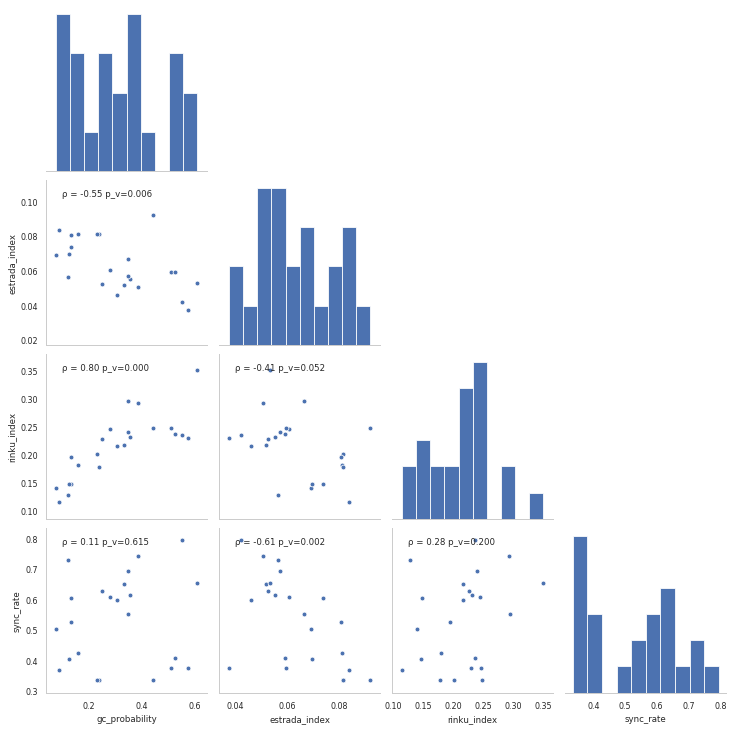

In [441]:
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale':1})
sns.set_context("paper", font_scale=0.9)

def corrfunc_pairplot(x, y, ax=None, **kws):
    from scipy.stats import pearsonr
    
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    #for x_h, y_h in zip(x,y):
    #    print(f"x: {x_h} y: {y_h}")
    
    r, p_value = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f} p_v={p_value:.3f}', xy=(.1, .9), xycoords=ax.transAxes)
    
#fig = plt.figure(figsize=(25,20))
g = sns.pairplot(data=step_stress_statistics_df[['gc_probability', 'estrada_index', 'rinku_index', 'sync_rate']], 
                 corner=True)
g.map_lower(corrfunc_pairplot)
fig = g.fig
fig.savefig(images_eps_base_path + '_' + 'pairwise_corner_results' + '.eps', format='eps')
plt.show()


In [346]:
step_stress_statistics_df.columns

Index(['tag', 'stationarity_level', 'density', 'mbar', 'frac_individual',
       'frac_hub', 'frac_leader', 'frac_normal', 'frac_follower', 'std',
       'max_derivative_std', 'min_derivative_std', 'time_max_std',
       'auc_from_std_max', 'total_area_from_std_max', 'last_100_mean_std',
       'mean_cc', 'nn_mean_cc', 'nn_mean_cc_dist_1', 'hub_indv_perm_scores',
       'orginal_hub_ind_count_ratio', 'std_exp_coeff_A', 'std_exp_coeff_K',
       'std_exp_coeff_C', 'mean_std', 'max_std_value', 'min_std_value',
       'time_min_std', 'auc_from_std_max_nt', 'total_area_from_std_max_nt',
       'analyze_cell_stats_flat', 'base_pickle_path', 'gc_signficant_count',
       'gc_total_test', 'number_of_cells', 'transformed_norm_df',
       'rinku_index', 'estrada_index', 'estrada_p_value', 'gc_probability',
       'delta_std', 'sync_rate', 'sync_rate_nt'],
      dtype='object')

In [ ]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'gc_probability', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

['p(GC Edge)', 'Global Heterogeneity', 'Local Heterogeneity', 'Adaption Rate']


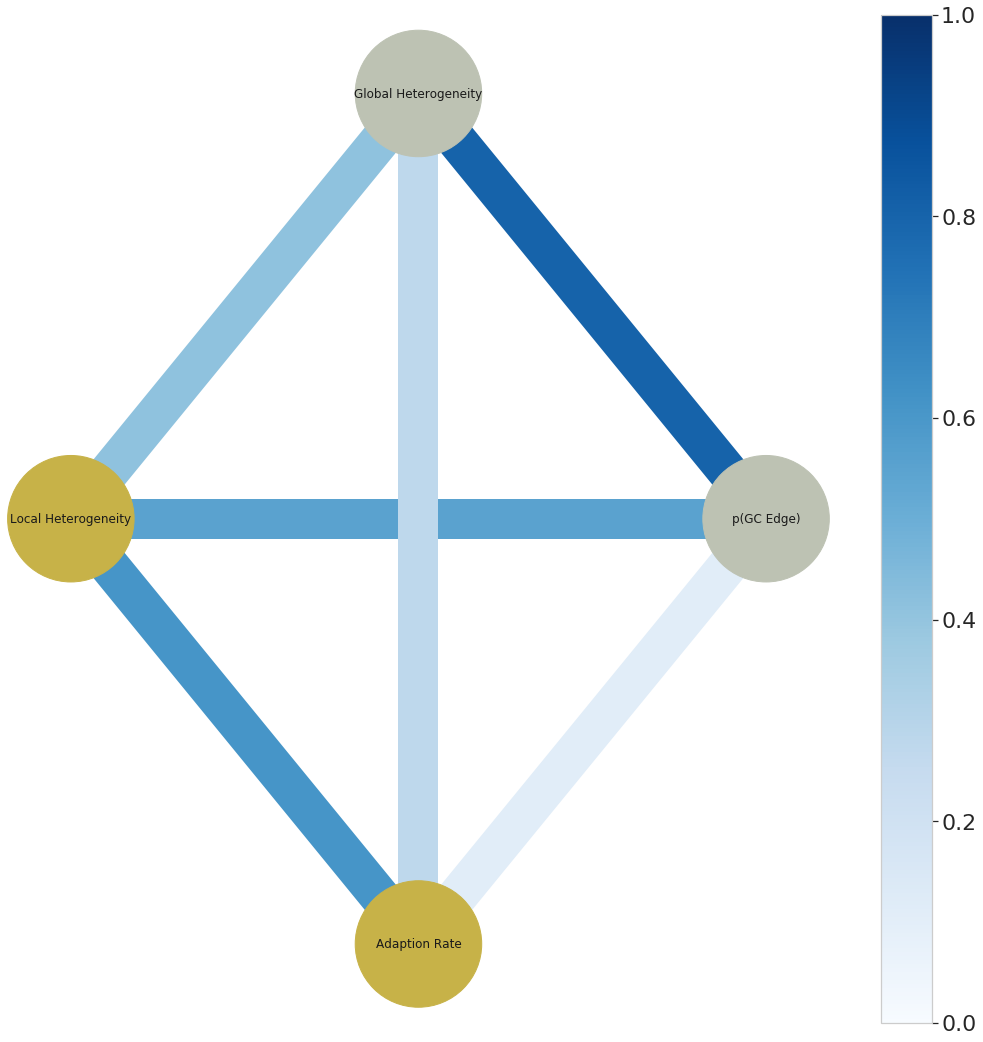

In [311]:
import networkx as nx

cor_matrix = step_stress_statistics_df[['gc_probability', 'rinku_index', 'estrada_index', 'sync_rate']]\
             .rename(columns={"gc_probability": "p(GC Edge)",
                              "rinku_index": "Global Heterogeneity",
                              "estrada_index": "Local Heterogeneity",                             
                              "sync_rate": "Adaption Rate"}).corr().abs()

#extracts the indices from the correlation matrix, which are the stocks
measures = cor_matrix.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
cor_matrix = np.asmatrix(cor_matrix)

G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: measures[x])
#shows the edges with their corresponding weights
G.edges(data=True)

def create_corr_network_1(G):
    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    #positions
    positions=nx.circular_layout(G)
    
    #Figure size
    fig = plt.figure(figsize=(15,15))
    
    print(G.nodes())
    colors_map = ['#BDC2B3', '#BDC2B3', '#C7B248', '#C7B248']

    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color=colors_map,
                           node_size=16000,alpha=1)
    
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=12, 
                            font_family='sans-serif')
        
    #draws the edges
    nx.draw_networkx_edges(G, positions, edge_list=edges,style='solid',
                      ###adds width=weights and edge_color = weights 
                      ###so that edges are based on the weight parameter 
                      ###edge_cmap is for the color scale based on the weight
                      ### edge_vmin and edge_vmax assign the min and max weights for the width
                      width=40, edge_color = weights, edge_cmap = plt.cm.Blues,
                      edge_vmin = 0, edge_vmax=1)
    
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = 0, vmax=1))
    sm._A = []
    plt.colorbar(sm)
    
    # displays the graph without axis
    plt.axis('off')
    plt.tight_layout(w_pad=1)
    #saves image
    plt.savefig(images_eps_base_path + 'measures_corr.eps', format='eps')
    plt.show() 

create_corr_network_1(G)


In [78]:
star_structure = pd.DataFrame(columns=['source', 'destination'])
star_structure = star_structure.append({'source': 1, 'destination': 5, 'part': 0, 'significant': 1}, ignore_index=True)
star_structure = star_structure.append({'source': 2, 'destination': 5, 'part': 0, 'significant': 1}, ignore_index=True)
star_structure = star_structure.append({'source': 3, 'destination': 5, 'part': 0, 'significant': 1}, ignore_index=True)
star_structure = star_structure.append({'source': 4, 'destination': 5, 'part': 0, 'significant': 1}, ignore_index=True)

regular_graph = pd.DataFrame(columns=['source', 'destination'])
regular_graph = regular_graph.append({'source': 1, 'destination': 3, 'part': 0, 'significant': 1}, ignore_index=True)
regular_graph = regular_graph.append({'source': 2, 'destination': 4, 'part': 0, 'significant': 1}, ignore_index=True)
regular_graph = regular_graph.append({'source': 3, 'destination': 5, 'part': 0, 'significant': 1}, ignore_index=True)
regular_graph = regular_graph.append({'source': 4, 'destination': 6, 'part': 0, 'significant': 1}, ignore_index=True)
regular_graph = regular_graph.append({'source': 5, 'destination': 7, 'part': 0, 'significant': 1}, ignore_index=True)
regular_graph = regular_graph.append({'source': 6, 'destination': 1, 'part': 0, 'significant': 1}, ignore_index=True)
regular_graph = regular_graph.append({'source': 7, 'destination': 2, 'part': 0, 'significant': 1}, ignore_index=True)


diverse_degree_graph = pd.DataFrame(columns=['source', 'destination'])
diverse_degree_graph = diverse_degree_graph.append({'source': 1, 'destination': 2, 'part': 0, 'significant': 1}, ignore_index=True)
diverse_degree_graph = diverse_degree_graph.append({'source': 2, 'destination': 3, 'part': 0, 'significant': 1}, ignore_index=True)
diverse_degree_graph = diverse_degree_graph.append({'source': 2, 'destination': 4, 'part': 0, 'significant': 1}, ignore_index=True)
diverse_degree_graph = diverse_degree_graph.append({'source': 2, 'destination': 5, 'part': 0, 'significant': 1}, ignore_index=True)
diverse_degree_graph = diverse_degree_graph.append({'source': 3, 'destination': 4, 'part': 0, 'significant': 1}, ignore_index=True)
diverse_degree_graph = diverse_degree_graph.append({'source': 4, 'destination': 5, 'part': 0, 'significant': 1}, ignore_index=True)

print(f"Regular Graph -- Jacob Rinku Score:{calc_h_m(get_node_degrees(regular_graph))}, Estrada Score: {estrada_index(regular_graph)}")
print(f"Star Graph -- Jacob Rinku Score:{calc_h_m(get_node_degrees(star_structure))}, Estrada Score: {estrada_index(star_structure)}")
print(f"Diverse Degree Graph -- Jacob Rinku Score:{calc_h_m(get_node_degrees(diverse_degree_graph))}, Estrada Score: {estrada_index(diverse_degree_graph)}")

Regular Graph -- Jacob Rinku Score:0.0, Estrada Score: 0.0
Star Graph -- Jacob Rinku Score:0.5830951894845301, Estrada Score: 1.0
Diverse Degree Graph -- Jacob Rinku Score:1.0677078252031311, Estrada Score: 0.3754430065818272


### Hub Enrichemnt in diffrent cutoffs

In [379]:
def get_roles_fraction(transformed_norm_df: pd.DataFrame, cutoff: float, expirement_tag: str):
    #load analyze_cell_stats
    base_pickle_path = images_pickle_base_path + expirement_tag + '_'
    analyze_cell_stats = load_object(base_pickle_path + 'analyze_cell_stats')
    analyze_cell_stats_flat = analyze_cell_stats.stack()
    
    analyze_cell_stats_flat[f'Manual_{cutoff}'] = np.apply_along_axis(lambda row: get_role(row, cutoff), 1, transformed_norm_df)
    
    state_matrix = analyze_cell_stats_flat.unstack()[f'Manual_{cutoff}'].transpose()
    unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)    
    normalize_counts_elements = counts_elements/sum(counts_elements)
    
    unique_elements = unique_elements.tolist()
    
    frac_hub = normalize_counts_elements[unique_elements.index(0)] if 0 in unique_elements else 0
    frac_individual = normalize_counts_elements[unique_elements.index(1)] if 1 in unique_elements else 0
    frac_follower = normalize_counts_elements[unique_elements.index(2)] if 2 in unique_elements else 0
    frac_leader = normalize_counts_elements[unique_elements.index(3)] if 3 in unique_elements else 0
    frac_normal = normalize_counts_elements[unique_elements.index(4)] if 4 in unique_elements else 0
    
    return frac_hub, frac_individual, frac_follower, frac_leader, frac_normal

def get_expected_hub_probability(frac_hub, frac_individual, frac_follower, frac_leader, frac_normal):
    return (frac_leader + frac_hub) * (frac_follower + frac_hub)

def get_hub_prob_vectors(stat_step_stress_statistics_df: pd.DataFrame, cutoff: float):
    expected_vec = stat_step_stress_statistics_df.apply(lambda row: get_expected_hub_probability(
                                                        *get_roles_fraction(row['transformed_norm_df'], cutoff, row['tag'])),
                                                        axis=1)
    
    real_frac_vec = stat_step_stress_statistics_df.apply(lambda row: get_roles_fraction(
                                                        row['transformed_norm_df'], cutoff, row['tag'])[0],
                                                        axis=1)
    
    from scipy.stats import wilcoxon
    
    wilcoxon_p_value = wilcoxon(expected_vec, real_frac_vec)[1]
    
    return expected_vec, real_frac_vec, wilcoxon_p_value

def get_hub_prob_vectors_summary(stat_step_stress_statistics_df: pd.DataFrame, cutoff_list: list):
    results = pd.DataFrame(columns=['threshold', 'frac_above', 'p_value'])
    results_raw_values = {}
    for cutoff in cutoff_list:
        #print(f'cutoff: {cutoff}')
        expected_vec, real_frac_vec, wilcoxon_p_value = get_hub_prob_vectors(stat_step_stress_statistics_df, cutoff)
        #print(f'real hub: {list(map(lambda x: round(x, 2), real_frac_vec.tolist()))}')
        #print(f'expected hub: {list(map(lambda x: round(x, 2), expected_vec.tolist()))}')
        results_raw_values.update({ 
                cutoff: {
                    'expected_vec': expected_vec,
                    'real_frac_vec': real_frac_vec,
                    'mbar': stat_step_stress_statistics_df['mbar'],
                    'wilcoxon_p_value': wilcoxon_p_value}
            })
        results = results.append({'threshold': cutoff,
                                  'frac_above': np.sum(real_frac_vec > expected_vec)/len(expected_vec),
                                  'p_value': wilcoxon_p_value}, ignore_index=True)
    
    return results, results_raw_values

hub_prob_cutoff_summary, hub_prob_cutoff_dict = get_hub_prob_vectors_summary(step_stress_statistics_df, 
                                                                             [0.25, 0.5, 0.75, 1, 1.25, 1.5])
hub_prob_cutoff_summary

,threshold,frac_above,p_value
0,0.25,0.869565,0.000295
1,0.50,0.869565,0.000418
2,0.75,0.869565,0.000658
3,1.00,0.826087,0.000262
4,1.25,0.826087,0.000233
5,1.50,0.826087,0.000120


In [372]:
step_stress_statistics_df['Expected: P(Leader + Hub)*P(Follower + Hub)'] = (step_stress_statistics_df['frac_leader'] + step_stress_statistics_df['frac_hub']) * (step_stress_statistics_df['frac_follower'] + step_stress_statistics_df['frac_hub'])

In [398]:
step_stress_statistics_df[['Expected: P(Leader + Hub)*P(Follower + Hub)', 'frac_hub']]

,Expected: P(Leader + Hub)*P(Follower + Hub),frac_hub
0,0.140045,0.089069
1,0.060861,0.113043
2,0.081877,0.166131
3,0.116857,0.231061
4,0.083345,0.184676
5,0.101200,0.195205
6,0.102210,0.200321
7,0.104832,0.208068
8,0.105227,0.207024
9,0.158124,0.067114


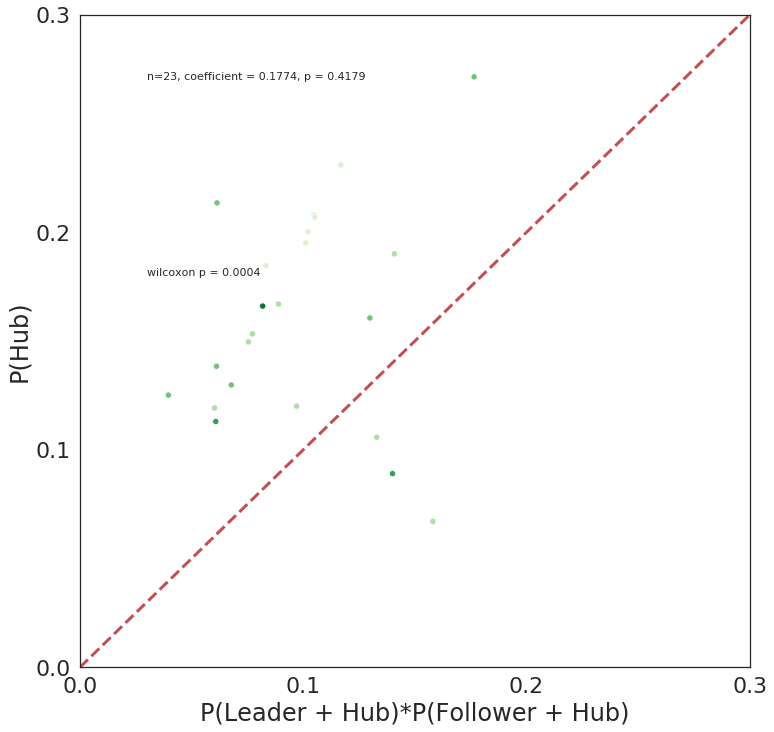

<Figure size 432x288 with 0 Axes>

In [428]:
from scipy import stats

sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(12,12))
#ax = sns.scatterplot(ax=ax, x='Expected: P(Leader + Hub)*P(Follower + Hub)', y='frac_hub' ,
#                     data=step_stress_statistics_df, s=100, color = 'blue')

ax = sns.scatterplot(ax=ax, 
                     x=hub_prob_cutoff_dict[0.5]['expected_vec'], 
                     y=hub_prob_cutoff_dict[0.5]['real_frac_vec'],
                     hue=hub_prob_cutoff_dict[0.5]['mbar'], 
                     s=40, 
                     palette=sns.color_palette('Greens', len(hub_prob_cutoff_dict[0.5]['mbar'].unique())),
                     legend=False)

ticks_range = np.arange(0.0, 0.5, step=0.1)

ax.set(xlim=(0.0, 0.3), ylim=(0.0, 0.3), xticks=ticks_range, yticks=ticks_range)
ax.set(xlabel='P(Leader + Hub)*P(Follower + Hub)', ylabel='P(Hub)')

data_correlation = stats.pearsonr(x=step_stress_statistics_df['Expected: P(Leader + Hub)*P(Follower + Hub)'], 
                                  y=step_stress_statistics_df['frac_hub'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .9), xycoords=ax.transAxes, fontsize=11)


from scipy.stats import wilcoxon



ax.annotate("wilcoxon p = {:.4f}".format(wilcoxon(step_stress_statistics_df['Expected: P(Leader + Hub)*P(Follower + Hub)'],
                                                step_stress_statistics_df['frac_hub'])[1]),
                xy=(.1, .6), xycoords=ax.transAxes, fontsize=11)

#plt.tight_layout(pad=1, w_pad=2, h_pad=1.0)

plt.plot(ticks_range, ticks_range, 'r--')

#plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title

plt.show()

fig.savefig(images_eps_base_path + 'Expected: P(Leader + Hub)*P(Follower + Hub)_0_5.eps', format='eps')
fig.savefig(images_base_path + 'Expected: P(Leader + Hub)*P(Follower + Hub)_0_5.png')
plt.clf()
plt.close(fig)

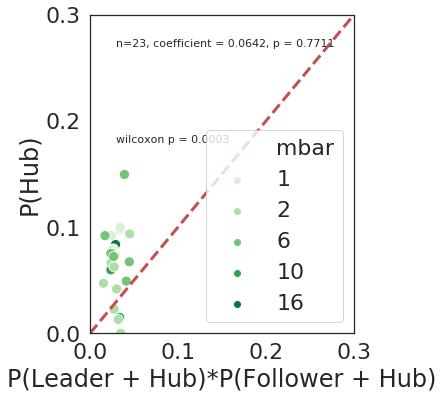

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

In [392]:
from scipy import stats

sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

cutoff = 1

fig, ax = plt.subplots(figsize=(6,6))
#ax = sns.scatterplot(ax=ax, x='Expected: P(Leader + Hub)*P(Follower + Hub)', y='frac_hub' ,
#                     data=step_stress_statistics_df, s=100, color = 'blue')

ax = sns.scatterplot(ax=ax, 
                     x=hub_prob_cutoff_dict[cutoff]['expected_vec'], 
                     y=hub_prob_cutoff_dict[cutoff]['real_frac_vec'],
                     hue=hub_prob_cutoff_dict[cutoff]['mbar'], 
                     s=100, 
                     palette=sns.color_palette('Greens', len(hub_prob_cutoff_dict[cutoff]['mbar'].unique())))

ticks_range = np.arange(0.0, 0.5, step=0.1)

ax.set(xlim=(0.0, 0.3), ylim=(0.0, 0.3), xticks=ticks_range, yticks=ticks_range)
ax.set(xlabel='P(Leader + Hub)*P(Follower + Hub)', ylabel='P(Hub)')

data_correlation = stats.pearsonr(x=hub_prob_cutoff_dict[cutoff]['expected_vec'], 
                                  y=hub_prob_cutoff_dict[cutoff]['real_frac_vec'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .9), xycoords=ax.transAxes, fontsize=11)


from scipy.stats import wilcoxon



ax.annotate("wilcoxon p = {:.4f}".format(wilcoxon(hub_prob_cutoff_dict[cutoff]['expected_vec'],
                                                  hub_prob_cutoff_dict[cutoff]['real_frac_vec'])[1]),
                xy=(.1, .6), xycoords=ax.transAxes, fontsize=11)

plt.tight_layout(pad=1, w_pad=2, h_pad=1.0)

plt.plot(ticks_range, ticks_range, 'r--')

#plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title

plt.show()

fig.savefig(images_eps_base_path + 'Expected: P(Leader + Hub)*P(Follower + Hub)_1_00.eps', format='eps')
fig.savefig(images_base_path + 'Expected: P(Leader + Hub)*P(Follower + Hub)_)_1_00.png')
plt.clf()
plt.close(fig)

## Filter experiments which their Estrada's index is not local property

In [35]:
estrada_index_results

,est_idx_p_value,est_idx
0,0.000,0.037480
1,0.000,0.083630
2,1.000,0.056346
3,0.000,0.055284
4,0.000,0.052427
5,0.000,0.046028
6,0.000,0.051549
7,0.000,0.060496
8,0.000,0.056994
9,0.000,0.053116


In [36]:
unlocal_estrda_indexs = estrada_index_results[estrada_index_results['est_idx_p_value'] > 0].index
local_estrda_indexs = estrada_index_results.index.difference(unlocal_estrda_indexs)
local_estrda_indexs

Int64Index([0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
            22],
           dtype='int64')

In [37]:
step_stress_statistics_df = step_stress_statistics_df.loc[local_estrda_indexs, :]

In [38]:
step_stress_statistics_df.loc[local_estrda_indexs, :]

,tag,stationarity_level,density,mbar,frac_individual,frac_hub,frac_leader,frac_normal,frac_follower,std,...,gc_total_test,number_of_cells,transformed_norm_df,delta_std,sync_rate,sync_rate_nt,hub_individual_ratio,global_het,estrada_index,estrada_p_value
0,step_shear_data_10_mbar_2016_08_17_Exp_02,0.939271,4.684986e-10,10,0.090418,0.089069,0.299595,0.249663,0.271255,0 0.006221 1 0.004885 2 0.00203...,...,12965.0,741.0,"[[0.5957280896358134, -1.7513119149422978], [0...",0.011690,0.374060,0.596723,0.985075,0.009177,0.037480,0.0
1,step_shear_data_10_mbar_2016_08_17_Exp_05,0.921739,5.799261e-10,10,0.144565,0.113043,0.138043,0.475000,0.129348,0 0.004634 1 0.004375 2 0.00169...,...,15867.0,920.0,"[[-0.26711578206049824, -0.930427439445368], [...",0.008086,0.368680,0.549055,0.781955,0.005155,0.083630,0.0
3,step_shear_data_1_mbar_2016_10_12_Exp_01,0.909091,3.349751e-10,1,0.198864,0.231061,0.113636,0.348485,0.107955,0 0.002714 1 0.002124 2 0.00258...,...,8948.0,528.0,"[[-0.9197773459797979, 0.6077952997099224], [0...",0.025672,0.613042,0.837326,1.161905,0.013528,0.055284,0.0
4,step_shear_data_1_mbar_2016_10_12_Exp_02,0.990177,3.219803e-10,1,0.229862,0.184676,0.111984,0.377210,0.096267,0 0.006503 1 0.013006 2 0.01370...,...,9313.0,509.0,"[[-1.6562832668050773, -0.8634173459004273], [...",0.027269,0.627122,0.817949,0.803419,0.013809,0.052427,0.0
5,step_shear_data_1_mbar_2016_10_12_Exp_03,0.977740,3.692350e-10,1,0.217466,0.195205,0.107877,0.340753,0.138699,0 0.001810 1 0.001167 2 0.00104...,...,10732.0,584.0,"[[-1.5846779490796645, -1.7240729308095786], [...",0.023598,0.597914,0.820499,0.897638,0.013552,0.046028,0.0
6,step_shear_data_1_mbar_2016_10_12_Exp_04,0.911859,3.933073e-10,1,0.181090,0.200321,0.121795,0.379808,0.116987,0 0.001717 1 0.000853 2 0.00141...,...,10731.0,624.0,"[[0.7420472809047809, 0.6802912074909692], [-0...",0.022841,0.649075,0.828970,1.106195,0.012546,0.051549,0.0
7,step_shear_data_1_mbar_2016_10_12_Exp_05,0.934183,2.978387e-10,1,0.233546,0.208068,0.116773,0.326964,0.114650,0 0.001598 1 0.002674 2 0.00281...,...,8243.0,471.0,"[[-0.702231280467409, -0.5527878101766197], [0...",0.017350,0.607829,0.789955,0.890909,0.015287,0.060496,0.0
8,step_shear_data_1_mbar_2016_10_12_Exp_06,0.937153,3.423617e-10,1,0.221811,0.207024,0.114603,0.336414,0.120148,0 0.004695 1 0.003672 2 0.00392...,...,9520.0,541.0,"[[2.155867437589606, 0.0364270172231848], [1.0...",0.025166,0.692625,0.839219,0.933333,0.017851,0.056994,0.0
9,step_shear_data_2_mbar_2016_07_24_Exp_02,0.859060,1.896923e-10,2,0.100671,0.067114,0.332215,0.171141,0.328859,0 0.003991 1 0.002549 2 0.00277...,...,4702.0,298.0,"[[0.3544283879815229, 0.1663038800410727], [0....",0.011761,0.652435,0.792163,0.666667,0.004123,0.053116,0.0
10,step_shear_data_2_mbar_2016_07_24_Exp_03,0.855696,2.509404e-10,2,0.291139,0.167089,0.113924,0.278481,0.149367,0 0.000598 1 0.000608 2 0.00064...,...,6330.0,395.0,"[[1.1592606084270654, 2.3125461840489008], [1....",0.005503,0.551252,0.708111,0.573913,0.013888,0.066506,0.0


In [39]:
step_stress_statistics_df_sorted = step_stress_statistics_df.copy(deep=True)
step_stress_statistics_df_sorted.mbar = step_stress_statistics_df_sorted.mbar.astype(int)
step_stress_statistics_df_sorted = step_stress_statistics_df_sorted.sort_values(by='mbar')
step_stress_statistics_df_sorted['old_index'] = step_stress_statistics_df_sorted.index
step_stress_statistics_df_sorted = step_stress_statistics_df_sorted.reset_index()
step_stress_statistics_df_sorted[['tag', 'mbar', 'estrada_index', 'estrada_p_value', 'gc_probability', 'sync_rate', 'old_index']]

KeyError: "['gc_probability'] not in index"

In [ ]:
estrada_index_records[step_stress_statistics_df_sorted['old_index'].values]

In [ ]:
#step_stress_statistics_df['hub_indv_perm_scores']

#sns.boxplot(x="distance", y="method", data=planets,
#            whis=[0, 100],)

# Add in points to show each observation
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig, ax=plt.subplots(figsize=(12,12))

chart = sns.swarmplot(data=estrada_index_records[step_stress_statistics_df_sorted['old_index'].values],
              size=2, color=".3", linewidth=0, palette="Paired")

#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

sns.boxplot(x=step_stress_statistics_df_sorted.index, y=step_stress_statistics_df_sorted['estrada_index'].values,
             showcaps=False,boxprops={'facecolor':'None', 'linewidth':5},
             showfliers=False,whiskerprops={'linewidth':0}, ax=chart, palette="Paired")

chart.set(xlabel='Experiment Tag', ylabel='Estrda index score')

#fig.savefig(images_eps_base_path + '_' + 'hub_individual_ratio_perm_test' + '.eps', format='eps')

plt.show()

## Comparison between adaption rate, estrda index, near neighbors cross correlation

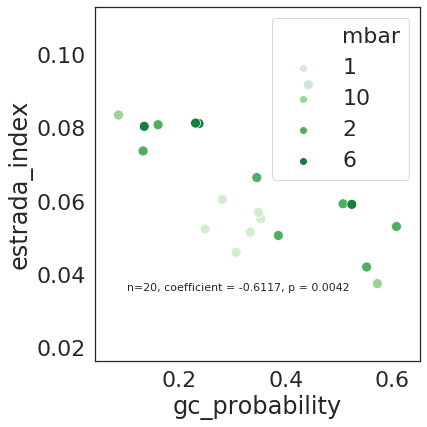

<Figure size 432x288 with 0 Axes>

In [106]:
step_stress_statistics_df['gc_probability'] = step_stress_statistics_df['gc_signficant_count'] / step_stress_statistics_df['gc_total_test']

plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'gc_probability', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

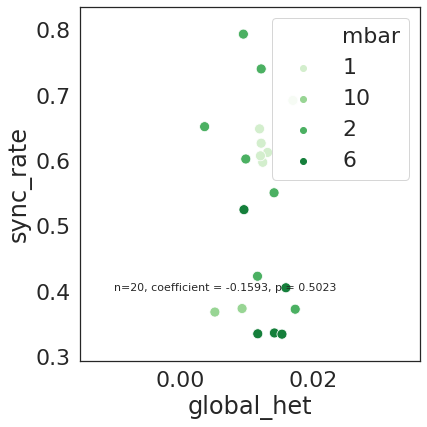

<Figure size 432x288 with 0 Axes>

In [160]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'global_het', 'sync_rate', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

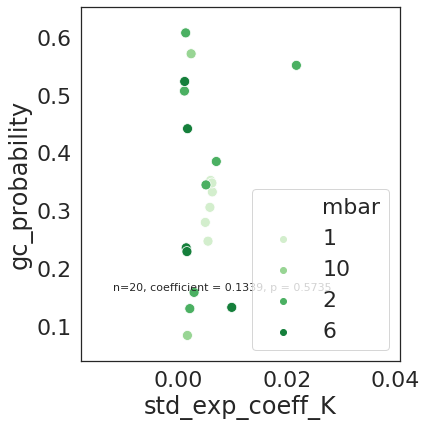

<Figure size 432x288 with 0 Axes>

In [153]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'std_exp_coeff_K', 'gc_probability', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

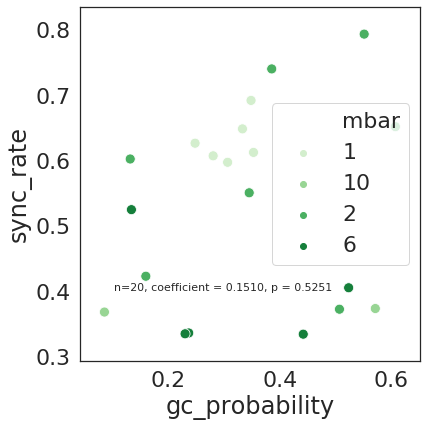

<Figure size 432x288 with 0 Axes>

In [125]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'gc_probability', 'sync_rate', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

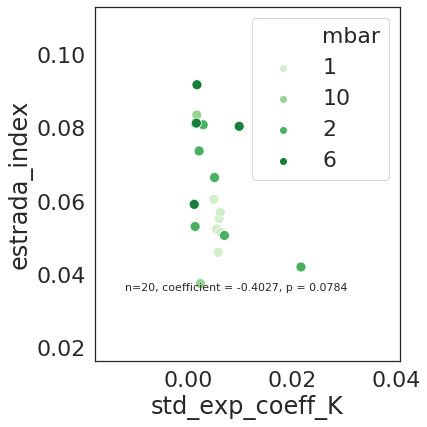

<Figure size 432x288 with 0 Axes>

In [103]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'std_exp_coeff_K', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

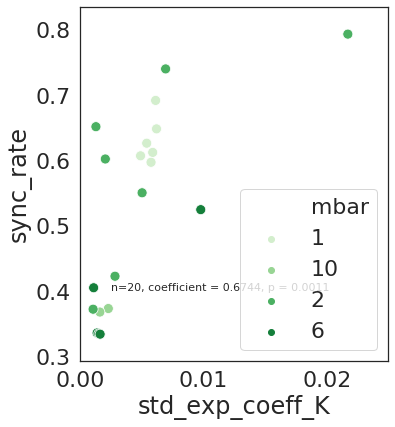

<Figure size 432x288 with 0 Axes>

In [155]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'std_exp_coeff_K', 'sync_rate', 
                        prefix='all_12_mbar',save=False, xlim=[0, 0.025], ylim=None, xlog=False, ylog=False, color_set='Greens')

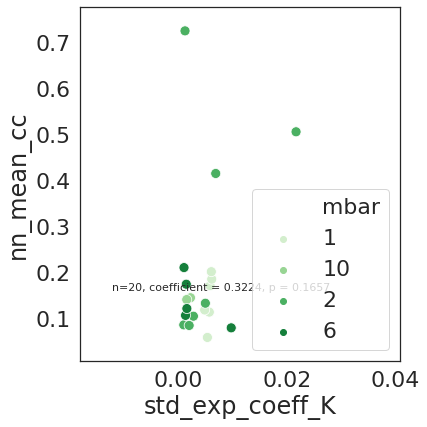

<Figure size 432x288 with 0 Axes>

In [105]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'std_exp_coeff_K', 'nn_mean_cc', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

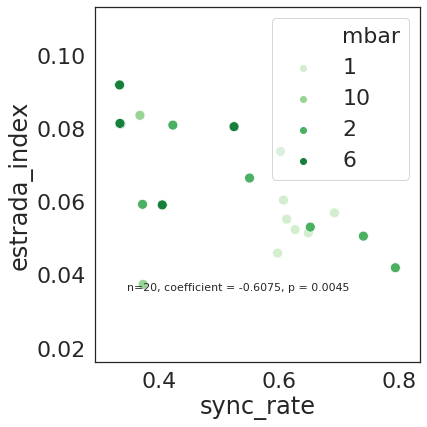

<Figure size 432x288 with 0 Axes>

In [110]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'sync_rate', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

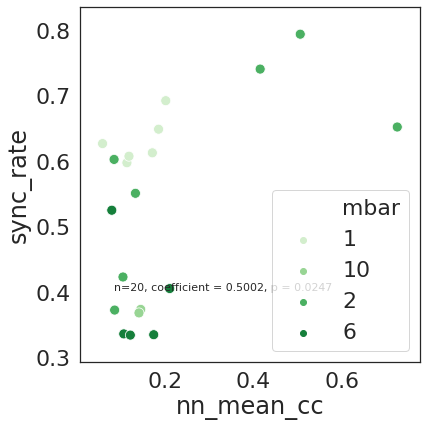

<Figure size 432x288 with 0 Axes>

In [112]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'nn_mean_cc', 'sync_rate', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

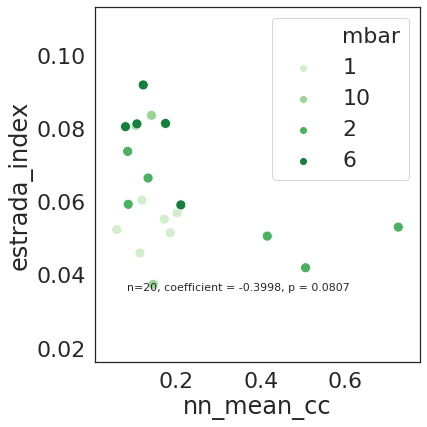

<Figure size 432x288 with 0 Axes>

In [113]:
plot_scatter_mbar_color(step_stress_statistics_df.loc[local_estrda_indexs, :], 'nn_mean_cc', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

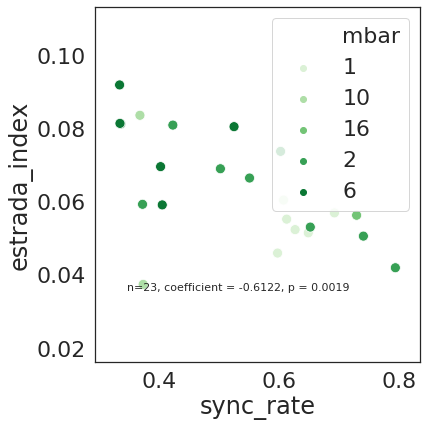

<Figure size 432x288 with 0 Axes>

In [203]:
plot_scatter_mbar_color(step_stress_statistics_df, 'sync_rate', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

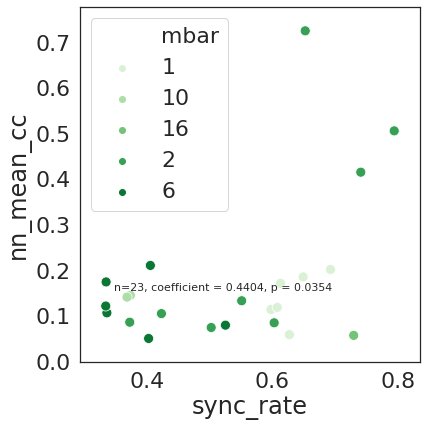

<Figure size 432x288 with 0 Axes>

In [205]:
plot_scatter_mbar_color(step_stress_statistics_df, 'sync_rate', 'nn_mean_cc', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

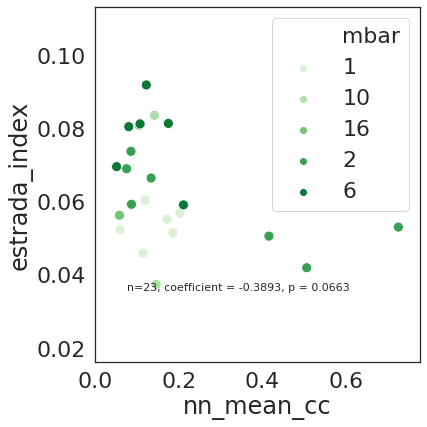

<Figure size 432x288 with 0 Axes>

In [206]:
plot_scatter_mbar_color(step_stress_statistics_df, 'nn_mean_cc', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

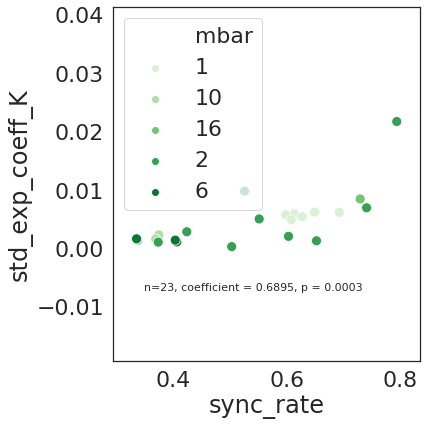

<Figure size 432x288 with 0 Axes>

In [225]:
plot_scatter_mbar_color(step_stress_statistics_df, 'sync_rate', 'std_exp_coeff_K', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

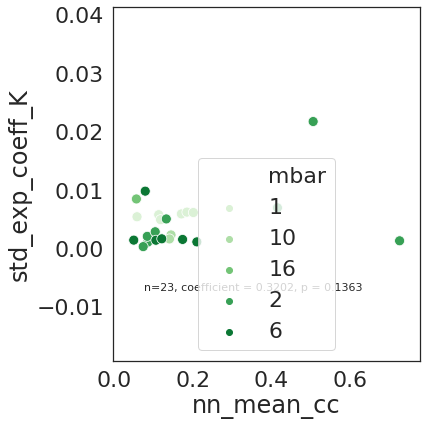

<Figure size 432x288 with 0 Axes>

In [226]:
plot_scatter_mbar_color(step_stress_statistics_df, 'nn_mean_cc', 'std_exp_coeff_K', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

In [ ]:
step_stress_statistics_df[['mbar', '']]

In [ ]:
plot_scatter_mbar_color(step_stress_statistics_df, 'nn_mean_cc', 'std_exp_coeff_K', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

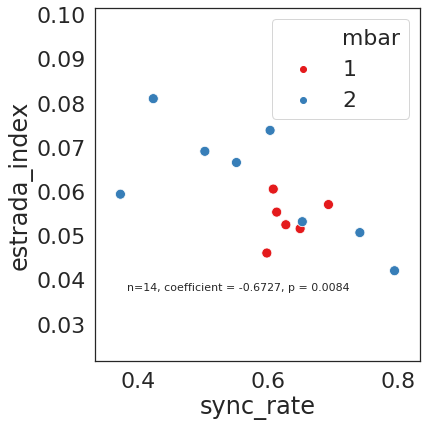

<Figure size 432x288 with 0 Axes>

In [142]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'sync_rate', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

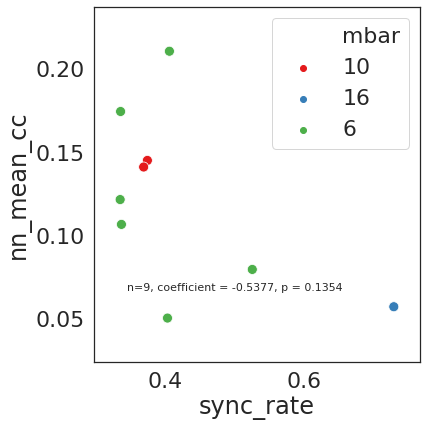

<Figure size 432x288 with 0 Axes>

In [146]:
plot_scatter_mbar_color(filiter_in_mbar(6, step_stress_statistics_df), 'sync_rate', 'nn_mean_cc', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

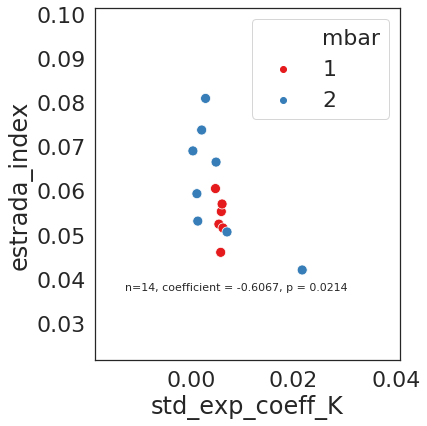

<Figure size 432x288 with 0 Axes>

In [106]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'std_exp_coeff_K', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(step_stress_statistics_df, 'sync_rate', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [147]:
step_stress_statistics_df['hub_individual_ratio'] = step_stress_statistics_df['frac_hub'] / step_stress_statistics_df['frac_individual']

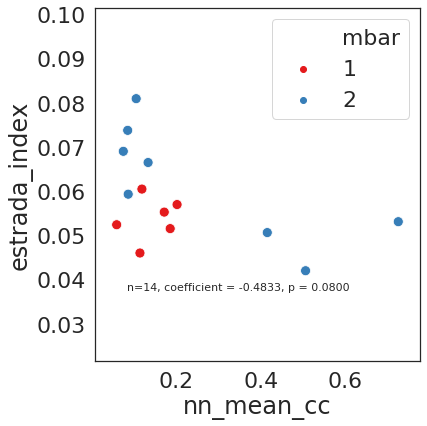

<Figure size 432x288 with 0 Axes>

In [155]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'nn_mean_cc', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

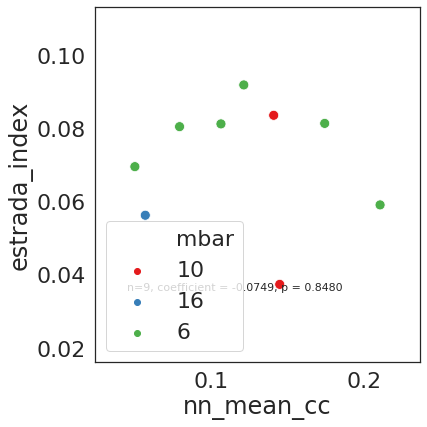

<Figure size 432x288 with 0 Axes>

In [156]:
plot_scatter_mbar_color(filiter_in_mbar(6 ,step_stress_statistics_df), 'nn_mean_cc', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [151]:
step_stress_statistics_df[['hub_individual_ratio', 'mbar', 'sync_rate']]

,hub_individual_ratio,mbar,sync_rate
0,1.161905,1,0.607150
1,0.803419,1,0.625003
2,0.897638,1,0.596298
3,1.106195,1,0.806295
4,0.890909,1,0.704472
5,0.933333,1,0.760121
6,0.666667,2,0.648163
7,0.573913,2,0.498254
8,0.698113,2,0.740412
9,1.025000,2,0.936425


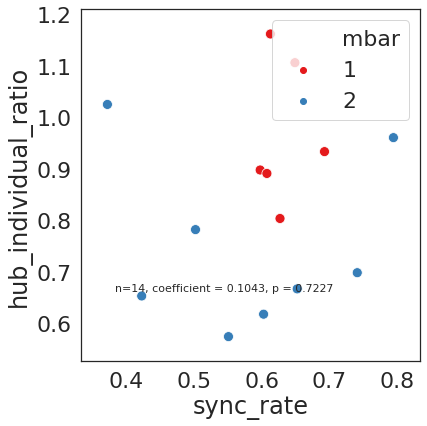

<Figure size 432x288 with 0 Axes>

In [109]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'sync_rate', 'hub_individual_ratio',
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

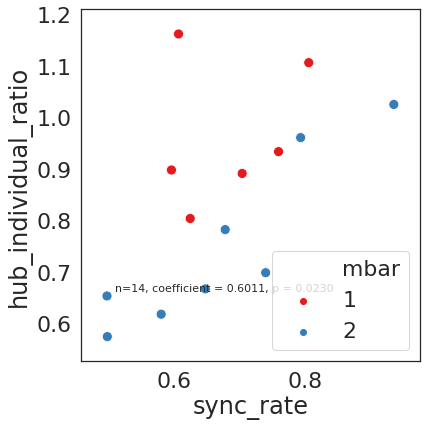

<Figure size 432x288 with 0 Axes>

In [152]:
plot_scatter_mbar_color(step_stress_statistics_df, 'sync_rate', 'hub_individual_ratio',
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

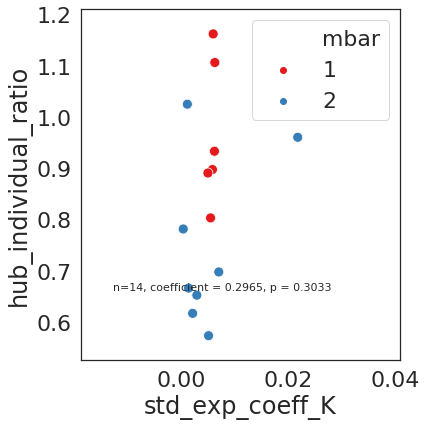

<Figure size 432x288 with 0 Axes>

In [155]:
plot_scatter_mbar_color(step_stress_statistics_df, 'std_exp_coeff_K', 'hub_individual_ratio',
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

### Mean cells edge  probability.
I want to show that when we have low denisty or tretemant we have a lower information transmission between cells.

In [ ]:
step_stress_statistics_df

## Until here we have got

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'std_exp_coeff_K', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'mean_std', 'std_exp_coeff_A', 
                        prefix='all_12_mbar',save=False, xlim=[0, 0.009], ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'std_exp_coeff_A', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'mean_std', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=[0, 0.01], xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'delta_std', 'mean_std', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=[0, 0.01], xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'auc_area_ratio', 'std_exp_coeff_A', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'delta_std', 'std_exp_coeff_A', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'delta_std', 'std_exp_coeff_K', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
stat_step_stress_statistics_df = step_stress_statistics_df[step_stress_statistics_df['stationarity_level'] > 0.85]

In [ ]:
stat_step_stress_statistics_df['individual_hub_ratio'] = stat_step_stress_statistics_df['frac_individual'] / stat_step_stress_statistics_df['frac_hub']
stat_step_stress_statistics_df['individual_normal_ratio'] = stat_step_stress_statistics_df['frac_individual'] / stat_step_stress_statistics_df['frac_normal']
stat_step_stress_statistics_df['normal_individual_ratio'] = stat_step_stress_statistics_df['frac_normal'] / stat_step_stress_statistics_df['frac_individual']

stat_step_stress_statistics_df = filiter_out_mbar(6 ,stat_step_stress_statistics_df)

In [ ]:
stat_step_stress_statistics_df['gc_probability'] = stat_step_stress_statistics_df['gc_signficant_count'] / stat_step_stress_statistics_df['gc_total_test']

In [ ]:
row = 0

homogeneity = pd.DataFrame(columns=['homogeneity'])

for index, step_expirment in stat_step_stress_statistics_df.iterrows():
    analyze_cell_stats = load_object(step_expirment['base_pickle_path'] + 'analyze_cell_stats')
    
    ##clustring
    analyze_cell_stats_flat = analyze_cell_stats.stack()

    transformed_norm_df, pipe_norm_df = standard_df(analyze_cell_stats_flat[['gc_in','gc_out']].loc[pd.IndexSlice[:, :], :])
    
    homogeneity.loc[row] = calc_homogeneity_score(transformed_norm_df)
    
    row += 1

In [ ]:
stat_step_stress_statistics_df['homogeneity'] = homogeneity.values

In [ ]:
def directed_estrada_index(analyze_result_df):
    sum = 0
    nodes_out_degree = analyze_result_df.groupby(['source', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_out'})
    nodes_in_degree = analyze_result_df.groupby(['destination', 'part']).agg('sum').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_in'})
    #assert nodes_out_degree.shape[0] == nodes_in_degree.shape[0]
    #print(nodes_in_degree.shape)
    #print(nodes_out_degree.shape)
    n = max(nodes_out_degree.shape[0], nodes_in_degree.shape[0])

    for ids, row in analyze_result_df.iterrows():
        if row['significant'] == 1:
            out_degree = float(nodes_out_degree.loc[row['source']].sum())
            in_degree = float(nodes_in_degree.loc[row['destination']].sum())
            sum += (out_degree**(-1) + in_degree**(-1) - 2*((out_degree*in_degree)**(-0.5)))

    sum /= (n - 2*((n - 1)**0.5))

    return sum

def estrada_index_perm_test(analyze_result_df, estrada_index_func, n=1000):
    perm_counter = 0    

    analyze_result_df_random = analyze_result_df.copy()

    gc_prob = analyze_result_df['significant'].sum()/analyze_result_df['significant'].count()

    estrada_idx_score = estrada_index_func(analyze_result_df)
    
    records = np.zeros((n), dtype='float')

    for i in range(0, n):
        analyze_result_df_random['significant'] = create_random_edges(gc_prob, analyze_result_df.shape[0])    
        random_estrada_idx_score = estrada_index_func(analyze_result_df_random)

        if estrada_idx_score < random_estrada_idx_score:
            perm_counter += 1
        
        records[i] = random_estrada_idx_score

    return perm_counter/n, records

row = 0

directed_estrada_index_results = pd.DataFrame(columns=['est_idx_p_value', 'est_idx'])
directed_estrada_index_records = pd.DataFrame()

for index, step_expirment in tqdm(stat_step_stress_statistics_df.iterrows(), total=stat_step_stress_statistics_df.shape[0]):
    analyze_result_df = load_object(step_expirment['base_pickle_path'] + 'analyze_result_df')
    estrada_index_result = directed_estrada_index(analyze_result_df)
    estrada_index_perm_test_result, records = estrada_index_perm_test(analyze_result_df, directed_estrada_index)
    
    directed_estrada_index_results.loc[row] = (estrada_index_perm_test_result, estrada_index_result)
    directed_estrada_index_records[row] =  records
    
    row += 1

directed_estrada_index_results

In [ ]:
estrada_index_records

### New homogeneity measure (null model vs real-network)

In [ ]:
import random
import pandas as pd
from scipy.stats import wasserstein_distance

def calc_distance_between_grid(pix, piy):
    X, Y = np.meshgrid(pix, piy)
    # Compute pariwise distances between points on 2D grid so we know
    # how to score the Wasserstein distance
    coords = np.array([X.flatten(), Y.flatten()]).T    
    coordsSqr = np.sum(coords**2, 1)
    M = coordsSqr[:, None] + coordsSqr[None, :] - 2*coords.dot(coords.T)
    M[M < 0] = 0
    M = np.sqrt(M)
    
    return M

def calc_distance_score(cell_stats, cell_stats_random, number_of_bins=20):
    concat_x = np.concatenate((cell_stats[0], cell_stats_random[0]))
    concat_y = np.concatenate((cell_stats[1], cell_stats_random[1]))
    xy_min = [min(concat_x), min(concat_y)]
    xy_max = [max(concat_x), max(concat_y)]
    range = [[xy_min[0], xy_max[0]], [xy_min[1], xy_max[1]]]
    
    H_i, xedges_i, yedges_i = np.histogram2d(cell_stats[0, :], 
                                             cell_stats[1, :], 
                                             bins=number_of_bins, 
                                             range=range, density=True)
    
    H_i_random, xedges_i_random, yedges_i_random = np.histogram2d(cell_stats_random[0, :], 
                                             cell_stats_random[1, :], 
                                             bins=number_of_bins, 
                                             range=range, density=True)
    
    square_size = (xedges_i[1]-xedges_i[0]) * (yedges_i[2]-yedges_i[1])

    distance_matrix = calc_distance_between_grid(mean_array(xedges_i), mean_array(yedges_i))
    
    return wasserstein_distance(H_i.flatten() * square_size, H_i_random.flatten() * square_size, distance_matrix, distance_matrix)

def create_random_edges(gc_prob, length):
    list_of_random_0_1 = int(np.round(length*gc_prob))*'1' + int(np.round(length*(1-gc_prob)))*'0'
    list_of_random_0_1 = list(map(int, list_of_random_0_1))
    random.shuffle(list_of_random_0_1)
    return list_of_random_0_1

# compare the un-normalized Tr/Re score between the null model and the real network
def hetro_analyze_cell_stats(analyze_result_df):
    cell_stats_gc_out = analyze_result_df.groupby(['source', 'part']).agg('mean').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_out'})
    cell_stats_gc_in = analyze_result_df.groupby(['destination', 'part']).agg('mean').unstack().loc[:, ['significant']].rename(columns={'significant':'gc_in'})
    cell_stats = pd.concat([cell_stats_gc_in, cell_stats_gc_out], axis=1, sort=False)
    
    return cell_stats

def hetro_permutation_test(analyze_result_df):
    perm_counter = 0
    good_score = 0
    
    cell_stats = hetro_analyze_cell_stats(analyze_result_df)
    gc_prob = analyze_result_df['significant'].sum()/analyze_result_df['significant'].count()
    
    analyze_result_df_random = analyze_result_df.copy()
    analyze_result_df_random_2 = analyze_result_df.copy()
    
    for i in range(0, 1000):
        analyze_result_df_random['significant'] = create_random_edges(gc_prob, analyze_result_df.shape[0])
        analyze_result_df_random_2['significant'] = create_random_edges(gc_prob, analyze_result_df.shape[0])
                
        cell_stats_random = hetro_analyze_cell_stats(analyze_result_df_random)
        cell_stats_random_2 = hetro_analyze_cell_stats(analyze_result_df_random_2)
    
        #calc distance between dist
        random_to_real = calc_distance_score(cell_stats.values.transpose(), cell_stats_random.values.transpose(), 30)
        random_to_random = calc_distance_score(cell_stats_random_2.values.transpose(), cell_stats_random.values.transpose(), 30)

        if random_to_real < random_to_random:
            perm_counter += 1
        elif good_score == 0:
            good_score = random_to_real
    
    return perm_counter/1000, good_score

row = 0

hetero_vs_null = pd.DataFrame(columns=['hetero_vs_null_p_value', 'hetero_vs_null'])

for index, step_expirment in stat_step_stress_statistics_df.iterrows():
    analyze_result_df = load_object(step_expirment['base_pickle_path'] + 'analyze_result_df')
    
    hetero_vs_null.loc[row] = hetro_permutation_test(analyze_result_df)
    
    row += 1

In [ ]:
hetero_vs_null

In [ ]:
stat_step_stress_statistics_df['hetero_vs_null'] = hetero_vs_null['hetero_vs_null'].values

## Measures Correlations

In [ ]:
stat_step_stress_statistics_df.columns

In [ ]:
stat_step_stress_statistics_df_measures = stat_step_stress_statistics_df.drop(['tag', 
                                                                               'mbar',
                                                                              'hub_indv_perm_scores',
                                                                              'base_pickle_path',
                                                                              'total_area_from_std_max', 
                                                                              'min_derivative_std', 
                                                                              'gc_total_test',
                                                                              'number_of_cells', 
                                                                              'gc_signficant_count',
                                                                              'individual_hub_ratio', 
                                                                              'stationarity_level',                                                                            
                                                                              'nn_mean_cc_dist_1',
                                                                              'nn_mean_cc',
                                                                              'frac_individual',
                                                                               'frac_hub', 
                                                                               'frac_leader', 
                                                                               'frac_normal', 
                                                                               'frac_follower'], axis=1)

In [ ]:
stat_step_stress_statistics_df_measures.columns

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 3})
                                    
sns.heatmap(np.abs(stat_step_stress_statistics_df_measures[['density', 
                                          'max_derivative_std', 
                                         'time_max_std', 
                                         'auc_from_std_max', 
                                         'mean_cc',
                                         'std_exp_coeff_A',
                                         'std_exp_coeff_K', 
                                         'mean_std']].corr()))

In [ ]:
stat_step_stress_statistics_df_measures.drop([11, 1, 12])

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 3})

mask = np.triu(np.ones_like(stat_step_stress_statistics_df_measures.drop([11]).corr(), dtype=np.bool))

sns.heatmap(stat_step_stress_statistics_df_measures.drop([11]).corr(), annot=True, mask=mask, vmin=-1, vmax=1, cmap='BrBG');

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df.drop([11]), 'estrada_index', 'std_exp_coeff_K', 
                        prefix='all_12_mbar',save=False, xlim=[0.03, 0.1], ylim=[0, 0.02], xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df.drop([11]), 'estrada_index', 'auc_area_ratio', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df.drop([11]), 'std_exp_coeff_K', 'auc_area_ratio', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
stat_step_stress_statistics_df.hetero_vs_null

In [ ]:
# flatten permutation result
permutation_result_table = pd.DataFrame(columns=['tag', 'hub_indv_perm_score'])
permutation_result_table_original = pd.DataFrame(columns=['tag', 'orginal_hub_ind_count_ratio', 'p-value', 'auc_area_ratio', 'delta_std'])

permutation_result_table_index = 0
permutation_result_table_original_index = 0

for index, row in step_stress_statistics_df.iterrows():
    if row['orginal_hub_ind_count_ratio'] == 0:
        continue
    
    if row['stationarity_level'] < 0.85:
        continue
    
    if int(row['mbar']) > 2:
        continue
    
    p_value_result = np.sum(row['orginal_hub_ind_count_ratio']<row['hub_indv_perm_scores']) / len(row['hub_indv_perm_scores'])
    permutation_result_table_original.loc[permutation_result_table_original_index] = [row['tag'], row['orginal_hub_ind_count_ratio'], p_value_result, row['auc_area_ratio'], row['delta_std']]
    permutation_result_table_original_index += 1
    
    for exp_result in row['hub_indv_perm_scores']:
        permutation_result_table.loc[permutation_result_table_index] = [row['tag'], exp_result]
        permutation_result_table_index += 1

permutation_result_table_original

In [ ]:
def generate_corr_with_sync():
    cross_exp_corr_table = pd.DataFrame(columns=['vs_delta_std_r', 'vs_delta_std_p', 'vs_auc_rate_r', 'vs_auc_rate_p'])
    permutation_result_table_by_tag = permutation_result_table.groupby('tag')['hub_indv_perm_score'].apply(np.array)
    
    permutation_result_matrix = np.stack(permutation_result_table_by_tag.values, axis=0).transpose()
    
    for all_exp_cycle in range(0, 100):
        hub_individual_ratio_vector = permutation_result_matrix[all_exp_cycle]
        delta_std_data_correlation = stats.pearsonr(hub_individual_ratio_vector, permutation_result_table_original['delta_std'])
        auc_data_correlation = stats.pearsonr(hub_individual_ratio_vector, permutation_result_table_original['auc_area_ratio'])
        cross_exp_corr_table.loc[all_exp_cycle] = [delta_std_data_correlation[0], delta_std_data_correlation[1], auc_data_correlation[0], auc_data_correlation[1]]
    
    return cross_exp_corr_table

generate_corr_with_sync().sample(n = 10)

In [ ]:
hub_individual_ratio_sample = generate_corr_with_sync().sample(n = 10)[['vs_delta_std_r', 'vs_delta_std_p']]
hub_individual_ratio_scores_original = pd.DataFrame(columns=['variable', 'value'])
hub_individual_ratio_scores_original.loc[0] = ['vs_delta_std_r', 0.8227]
hub_individual_ratio_scores_original.loc[1] = ['vs_delta_std_p', 0.0003]

In [ ]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})
fig, ax = plt.subplots(figsize=(6,6))

#plot_scatter_color(center_tr_re_1d_homogeneity_scores, x_feature_name='number of experiment', y_feature_name='vs_delta_std_p', save=False)
sns.swarmplot(x='variable', y='value', data=pd.melt(hub_individual_ratio_sample), color='blue', ax=ax)
sns.boxplot(x='variable', y='value', data=pd.melt(hub_individual_ratio_sample), color='0.9', ax=ax)

sns.boxplot(x='variable', y='value', data=hub_individual_ratio_scores_original, 
                 showcaps=False,boxprops={'facecolor':'None', 'linewidth':5},
                 showfliers=False,whiskerprops={'linewidth':0}, palette="Paired", medianprops={'color':'red'}, ax=ax)

fig.savefig(images_eps_base_path + '_' + 'hub_individual_ratio_vs_delta_std' + '.eps', format='eps')

In [ ]:
hub_individual_ratio_sample = generate_corr_with_sync().sample(n = 10)[['vs_auc_rate_r', 'vs_auc_rate_p']]
hub_individual_ratio_scores_original = pd.DataFrame(columns=['variable', 'value'])
hub_individual_ratio_scores_original.loc[0] = ['vs_auc_rate_r', -0.7203]
hub_individual_ratio_scores_original.loc[1] = ['vs_auc_rate_p', 0.0037]

In [ ]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})
fig, ax = plt.subplots(figsize=(6,6))

#plot_scatter_color(center_tr_re_1d_homogeneity_scores, x_feature_name='number of experiment', y_feature_name='vs_delta_std_p', save=False)
sns.swarmplot(x='variable', y='value', data=pd.melt(hub_individual_ratio_sample), color='blue', ax=ax)
sns.boxplot(x='variable', y='value', data=pd.melt(hub_individual_ratio_sample), color='0.9', ax=ax)

sns.boxplot(x='variable', y='value', data=hub_individual_ratio_scores_original, 
                 showcaps=False,boxprops={'facecolor':'None', 'linewidth':5},
                 showfliers=False,whiskerprops={'linewidth':0}, palette="Paired", medianprops={'color':'red'}, ax=ax)

fig.savefig(images_eps_base_path + '_' + 'hub_individual_ratio_vs_auc_rate' + '.eps', format='eps')

In [ ]:
#step_stress_statistics_df['hub_indv_perm_scores']

#sns.boxplot(x="distance", y="method", data=planets,
#            whis=[0, 100],)

# Add in points to show each observation
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

fig, ax=plt.subplots(figsize=(12,12))

chart = sns.swarmplot(x="tag", y="hub_indv_perm_score", data=permutation_result_table,
              size=2, color=".3", linewidth=0, palette="Paired")

chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

sns.boxplot(x="tag", y="orginal_hub_ind_count_ratio", data=permutation_result_table_original, 
                 showcaps=False,boxprops={'facecolor':'None', 'linewidth':5},
                 showfliers=False,whiskerprops={'linewidth':0}, ax=chart, palette="Paired")

chart.set(xlabel='Experiment Tag', ylabel='Hub/Individual Ratio')

fig.savefig(images_eps_base_path + '_' + 'hub_individual_ratio_perm_test' + '.eps', format='eps')

plt.show()

In [ ]:
step_stress_statistics_df['delta_std'] = step_stress_statistics_df['max_derivative_std'] - step_stress_statistics_df['min_derivative_std']
step_stress_statistics_df['auc_area_ratio'] = step_stress_statistics_df['auc_from_std_max'] / step_stress_statistics_df['total_area_from_std_max']

## Figure 1 - Step: methodology, pressure, synchronization

In [ ]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

In [ ]:
plt.figure(figsize=(8,8))

ax = sns.boxplot(x="mbar", y="last_100_mean_std", data=step_stress_statistics_df, palette="Set3", order=['1', '2', '6', '10', '16'])
ax = sns.swarmplot(x="mbar", y="last_100_mean_std", data=step_stress_statistics_df, color="0.3", order=['1', '2', '6', '10', '16'])

In [ ]:
## count the number of samples in each group

def do_wilcoxon_mbar(field, mbar_group_crit):
    # scipy.stats.ranksums
    from scipy.stats import ranksums

    group1 = step_stress_statistics_df[step_stress_statistics_df['mbar'].astype(int) < mbar_group_crit]
    group2 = step_stress_statistics_df[step_stress_statistics_df['mbar'].astype(int) >= mbar_group_crit]
    
    print('group 1 size: ' + str(len(group1)))
    print('group 2 size: ' + str(len(group2)))
    
    return ranksums(group1[field], group2[field])

print(do_wilcoxon_mbar('last_100_mean_std', 6))

#### Divide the dataset to two groups of 1-2 and 6, 10, 16

In [ ]:
step_stress_statistics_df['mbar_group_mask'] = step_stress_statistics_df['mbar'].astype(int) < 6
step_stress_statistics_df['mbar_group_mask'] = step_stress_statistics_df['mbar_group_mask'].replace({False: '[6-16] mbar', True: '[1-2] mbar'})

In [ ]:
g = sns.FacetGrid(step_stress_statistics_df,  col_wrap=2, col="mbar_group_mask", height=5, aspect=1.5, sharey=False)
g = g.map(sns.scatterplot, "density", "delta_std", s=200)
g = g.set_axis_labels("density(1/mm^2)", "delta_std")

def corrfunc(x, y, **kws):
    import scipy.stats as stats
    data_correlation = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(x),
                data_correlation[0], data_correlation[1]),
                xy=(.5, .4), xycoords=ax.transAxes, fontsize=10)
    
g.map(corrfunc, "density", "delta_std")


#ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(step_stress_statistics_df),
#            data_correlation[0], data_correlation[1]), 
#            xy=(.1, .1), xycoords=ax.transAxes, fontsize=11)

#g.set(ylim=(0, 0.005))

In [ ]:
## Stationarity for each mbar

g = sns.FacetGrid(step_stress_statistics_df,  col_wrap=2, col="mbar", height=4, aspect=2, col_order=['1', '2', '6', '10', '16'])
g = g.map(sns.regplot, "density", "stationarity_level")
g.set(ylim=(0, 1))

In [ ]:
g = sns.FacetGrid(step_stress_statistics_df,  col_wrap=2, col="mbar_group_mask", height=4, aspect=2)
g = g.map(sns.regplot, "density", "mean_cc")
g.set(ylim=(0, 1))

In [ ]:
g = sns.FacetGrid(step_stress_statistics_df,  col_wrap=2, col="mbar_group_mask", height=4, aspect=2)
g = g.map(sns.regplot, "density", "nn_mean_cc")
g.set(ylim=(0, 1))

In [ ]:
g = sns.FacetGrid(step_stress_statistics_df,  col_wrap=2, col="mbar", height=4, aspect=2, col_order=['1', '2', '6', '10', '16'])
g = g.map(sns.regplot, "last_100_mean_std", "nn_mean_cc")
g.set(ylim=(0, 1))

In [ ]:
non_stationarity_table = pd.read_csv(images_base_path + 'non_stationarity.txt', names=['tag', 'stationarity_level', 'density', 'mbar'], header=None)
stationarity_table = pd.read_csv(images_base_path + 'stationarity.txt', names=['tag', 'stationarity_level', 'density', 'mbar'], header=None)
stationarity_table = stationarity_table.append(non_stationarity_table, sort=True, ignore_index=True)

In [ ]:
stationarity_table['density_bin'] = pd.cut(stationarity_table['density'], bins=4, precision=0)

In [ ]:
import seaborn as sns

sns.set(style='whitegrid', font_scale=2)

plt.figure(figsize=(15,8))

ax = sns.boxplot(x="mbar", y="stationarity_level", data=step_stress_statistics_df, order=['1', '2', '6', '10', '16'])

In [ ]:
sns.set(style='whitegrid', font_scale=2)

plt.figure(figsize=(15,8))

ax = sns.boxplot(x="density_bin", y="stationarity_level", data=stationarity_table)

In [ ]:
step_stress_statistics_df.to_csv(images_base_path + 'step_stress_statistics_df.csv')

In [ ]:
def plot_scatter_mbar_color(df, x_feature_name, y_feature_name, prefix='', 
                            save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Set1'):
    import scipy.stats as stats

    sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})
    
    df_temp = df.copy(True)
    
    if xlog:
        df_temp['log('+x_feature_name+')'] = np.log(df_temp[x_feature_name])
        x_feature_name = 'log('+x_feature_name+')'
    
    if ylog:
        df_temp['log('+y_feature_name+')'] = np.log(df_temp[y_feature_name])
        y_feature_name = 'log('+y_feature_name+')'

    fig, ax = plt.subplots(figsize=(6,6))
    ax = sns.scatterplot(ax=ax, x=x_feature_name, y=y_feature_name , hue="mbar",
                         data=df_temp, s=100, palette=sns.color_palette(color_set, len(df_temp['mbar'].unique())))
    
    if (ylim is not None):
        ax.set(ylim=ylim)
    
    if (xlim is not None):
        ax.set(xlim=xlim)

    #x_ticks_range = np.arange(0.0, max(df[x_feature_name]), step=0.0015)
    #y_ticks_range = np.arange(0.0, max(df[y_feature_name]), step=0.1)

    #ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
    #ax.set(xlim=(0.0), ylim=(0.0))
    ax.set(xlabel=x_feature_name, ylabel=y_feature_name)

    data_correlation = stats.pearsonr(x=df_temp[x_feature_name], 
                                      y=df_temp[y_feature_name])

    ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(df_temp),
                data_correlation[0], data_correlation[1]), 
                xy=(.1, .2), xycoords=ax.transAxes, fontsize=11)

    #plt.plot(ticks_range, ticks_range, 'r--')

    plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

    plt.show()
    
    if save:
        fig.savefig(images_eps_base_path + '_' + prefix + '_' + x_feature_name + '_vs_' + y_feature_name + '.eps', format='eps')
        fig.savefig(images_base_path + '_' + prefix + '_' + x_feature_name + '_vs_' + y_feature_name + '.png')
    plt.clf()
    plt.close(fig)

## P(GC.edege)

In [ ]:
stat_step_stress_statistics_df['gc_probability'] = stat_step_stress_statistics_df['gc_signficant_count'] / stat_step_stress_statistics_df['gc_total_test']

## Figure 1

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'last_100_mean_std', 
                        prefix='all_12_mbar',save=True, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'number_of_cells', 'last_100_mean_std', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'delta_std', prefix='all', save=True)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'nn_mean_cc', 
                        prefix='all', ylog=True, xlog=True, save=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'nn_mean_cc_dist_1', 
                        prefix='all', ylog=True, xlog=True, save=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'nn_mean_cc', 'density', 
                        prefix='all', ylog=False, xlog=False, save=True)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'nn_mean_cc', 'last_100_mean_std', 
                        prefix='all', ylog=False, xlog=False, save=True)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'nn_mean_cc_dist_1', 'last_100_mean_std', 
                        prefix='all', ylog=True, xlog=False, save=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'nn_mean_cc', 'last_100_mean_std', 
                        prefix='all', ylog=True, xlog=False, save=False)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax = sns.boxplot(ax=ax, x="mbar", y="last_100_mean_std", data=step_stress_statistics_df, palette="Set3", order=['1', '2', '6', '10', '16'])
ax = sns.swarmplot(ax=ax, x="mbar", y="last_100_mean_std", data=step_stress_statistics_df, color="0.3", order=['1', '2', '6', '10', '16'])

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + '_all' + '_mbar' + '_vs_' + 'last_100_mean_std' + '.eps', format='eps')
fig.savefig(images_base_path + '_all'  + '_mbar' + '_vs_' + 'last_100_mean_std' + '.png')

plt.show()
plt.clf()
plt.close(fig)

## Figure S1SynchMeasuresD-F

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'delta_std', 'last_100_mean_std', 
                        prefix='all',save=True, xlim=None, ylim=0, xlog=False, ylog=False)

plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'auc_area_ratio', 'last_100_mean_std', 
                        prefix='all',save=True, xlim=None, ylim=0, xlog=False, ylog=False)

plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'auc_area_ratio', 'delta_std', 
                        prefix='all',save=True, xlim=None, ylim=None, xlog=False, ylog=False)

## Figure S1Density

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'number_of_cells', 'last_100_mean_std', 
                        prefix='all',save=False, xlim=None, ylim=None, xlog=False, ylog=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'last_100_mean_std', 
                        prefix='all',save=False, xlim=None, ylim=None, xlog=True, ylog=True)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'last_100_mean_std', 
                        prefix='all',save=False, xlim=None, ylim=None, xlog=True, ylog=True)

In [ ]:
#plot_scatter_mbar_color(filiter_in_mbar(6 ,step_stress_statistics_df), 'density', 'last_100_mean_std', 
#                        prefix='all',save=True, xlim=None, ylim=None, xlog=True, ylog=True, color_set='Set2')

### Figure S1StressLevels

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax = sns.boxplot(ax=ax, x="mbar", y="last_100_mean_std", data=step_stress_statistics_df, palette="Set3", order=['1', '2', '6', '10', '16'])
ax = sns.swarmplot(ax=ax, x="mbar", y="last_100_mean_std", data=step_stress_statistics_df, color="0.3", order=['1', '2', '6', '10', '16'])

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + '_all' + '_mbar' + '_vs_' + 'last_100_mean_std' + '.eps', format='eps')
fig.savefig(images_base_path + '_all'  + '_mbar' + '_vs_' + 'last_100_mean_std' + '.png')

plt.show()
plt.clf()
plt.close(fig)

################################

fig, ax = plt.subplots(figsize=(8,8))

ax = sns.boxplot(ax=ax, x="mbar", y="auc_area_ratio", data=step_stress_statistics_df, palette="Set3", order=['1', '2', '6', '10', '16'])
ax = sns.swarmplot(ax=ax, x="mbar", y="auc_area_ratio", data=step_stress_statistics_df, color="0.3", order=['1', '2', '6', '10', '16'])

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + '_all' + '_mbar' + '_vs_' + 'auc_area_ratio' + '.eps', format='eps')
fig.savefig(images_base_path + '_all'  + '_mbar' + '_vs_' + 'auc_area_ratio' + '.png')

plt.show()
plt.clf()
plt.close(fig)

################################

fig, ax = plt.subplots(figsize=(8,8))

ax = sns.boxplot(ax=ax, x="mbar", y="delta_std", data=step_stress_statistics_df, palette="Set3", order=['1', '2', '6', '10', '16'])
ax = sns.swarmplot(ax=ax, x="mbar", y="delta_std", data=step_stress_statistics_df, color="0.3", order=['1', '2', '6', '10', '16'])

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + '_all' + '_mbar' + '_vs_' + 'delta_std' + '.eps', format='eps')
fig.savefig(images_base_path + '_all'  + '_mbar' + '_vs_' + 'delta_std' + '.png')

plt.show()
plt.clf()
plt.close(fig)

### Hub/Indivdual Ratio in realtion to Tra + Rec Score

In [ ]:
stat_step_stress_statistics_df.columns

In [ ]:
stat_step_stress_statistics_df.sort_values('hub_individual_ratio')[['hub_individual_ratio', 'homogeneity']]

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'homogeneity', 'hub_individual_ratio', prefix='stat', save=False)
#sns.scatterplot(x='homogeneity', y='hub_individual_ratio', data=stat_step_stress_statistics_df)

In [ ]:
from pyemd import emd_samples

def calc_homogeneity_1d_score(df_tr_re_score_cycle):
    range = [-1, 1]
    number_of_bins = 20
    
    H, _ = np.histogram(df_tr_re_score_cycle, bins=10, range=range)
    
    sub_population = H.sum()/df_tr_re_score_cycle.shape[0]
    
    H_i, bin_edges = np.histogram(df_tr_re_score_cycle, bins=number_of_bins, range=range, density=True)
    
    uniform_data = np.ones(H_i.shape)
    uniform_data = uniform_data/uniform_data.sum()
    
    square_size = bin_edges[1]-bin_edges[0]
    uniform_data = uniform_data/square_size

    #distance_matrix = calc_distance_between_grid(mean_array(xedges_i), mean_array(yedges_i))
        
    return emd_samples(H_i.flatten() * square_size, uniform_data.flatten() *square_size, bins=number_of_bins), sub_population

In [ ]:
homogeneity_rec_tra_1d = pd.DataFrame(columns=['homogeneity_rec_tra_1d', 'rec_tra_1d_population_size'])

sns.set(style='white', font_scale = 1, rc={"lines.linewidth": 3})

f, axes = plt.subplots(stat_step_stress_statistics_df.shape[0], 1, figsize=(12, 21), sharex=True, sharey=True)

row = 0

for index, step_expirment in stat_step_stress_statistics_df.sort_values('hub_individual_ratio').iterrows():
    analyze_cell_stats = load_object(step_expirment['base_pickle_path'] + 'analyze_cell_stats')
    
    ##clustring
    analyze_cell_stats_flat = analyze_cell_stats.stack()

    transformed_norm_df, pipe_norm_df = standard_df(analyze_cell_stats_flat[['gc_in','gc_out']].loc[pd.IndexSlice[:, :], :])
    
    df_tr_re_score_cycle = pd.DataFrame(transformed_norm_df, 
                                    index=analyze_cell_stats_flat.index, 
                                    columns=analyze_cell_stats_flat[['gc_in','gc_out']].columns)
    
    df_tr_re_score_cycle = df_tr_re_score_cycle['gc_out'] + df_tr_re_score_cycle['gc_in']
    homogeneity_rec_tra_1d.loc[row] = calc_homogeneity_1d_score(df_tr_re_score_cycle)
    
    sns.distplot(df_tr_re_score_cycle, ax=axes[row])
    axes[row].title.set_text("Hub/Indivdual Ratio = {:.4f}, mean = {:.1f}, std = {:.4f}, skew = {:.4f} kurtosis = {:.4f}".format(
                            step_expirment['hub_individual_ratio'],
                            df_tr_re_score_cycle.mean(),
                            df_tr_re_score_cycle.std(),
                            df_tr_re_score_cycle.skew(),
                            df_tr_re_score_cycle.kurt()))
    row += 1

plt.xlim(-4, 9)
plt.tight_layout()

In [ ]:
homogeneity_rec_tra_1d

In [ ]:
stat_step_stress_statistics_df['homogeneity_rec_tra_1d'] = homogeneity_rec_tra_1d['homogeneity_rec_tra_1d'].values
stat_step_stress_statistics_df['rec_tra_1d_population_size'] = homogeneity_rec_tra_1d['rec_tra_1d_population_size'].values

In [ ]:
stat_step_stress_statistics_df.sort_values('hub_individual_ratio')[['hub_individual_ratio', 'homogeneity_rec_tra_1d', 'rec_tra_1d_population_size']]

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'homogeneity_rec_tra_1d', 'hub_individual_ratio', prefix='stat', save=True, xlim=[0.01,0.025])

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'homogeneity_rec_tra_1d', 'last_100_mean_std', prefix='stat', save=True, xlim=[0.01,0.025], ylim=[0, 0.003])

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'homogeneity_rec_tra_1d', 'delta_std', prefix='stat', save=True, xlim=[0.01,0.025])

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'homogeneity_rec_tra_1d', 'auc_area_ratio', prefix='stat', save=True, xlim=[0.01,0.025])

In [ ]:
import scipy.stats as stats

sns.set(style='white', font_scale = 1.1, rc={"lines.linewidth": 1})

def corrfunc(x, y, **kws):
    (r, p) = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes, bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))
    ax.annotate("p = {:.3f}".format(p),
                xy=(.6, .9), xycoords=ax.transAxes, bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))


graph = sns.pairplot(stat_step_stress_statistics_df[['homogeneity_rec_tra_1d',                                             
                                            'delta_std', 
                                            'hub_individual_ratio', 
                                            'last_100_mean_std','auc_area_ratio']])

graph.map(corrfunc)

In [ ]:
stat_step_stress_statistics_df[['homogeneity_rec_tra_1d', 'hub_individual_ratio', 'last_100_mean_std', 'delta_std', 'auc_area_ratio']].corr()

In [ ]:
import networkx as nx

cor_matrix = stat_step_stress_statistics_df[['homogeneity_rec_tra_1d', 'hub_individual_ratio', 'last_100_mean_std', 'delta_std', 'auc_area_ratio']]\
             .rename(columns={"homogeneity_rec_tra_1d": "Bulk Homogeneity", 
                             "hub_individual_ratio": "Hub/Individual Ratio",
                             "last_100_mean_std": "Asynchronization",
                             "delta_std": "Relative Variability",
                             "auc_area_ratio": "Sync Rate"}).corr().abs()

#extracts the indices from the correlation matrix, which are the stocks
measures = cor_matrix.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
cor_matrix = np.asmatrix(cor_matrix)

G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: measures[x])
#shows the edges with their corresponding weights
G.edges(data=True)

def create_corr_network_1(G):
    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    #positions
    positions=nx.circular_layout(G)
    
    #Figure size
    plt.figure(figsize=(15,15))
    
    print(G.nodes())
    colors_map = ['#BDC2B3', '#BDC2B3', '#C7B248', '#C7B248', '#C7B248']

    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color=colors_map,
                           node_size=7000,alpha=1)
    
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')
        
    #draws the edges
    nx.draw_networkx_edges(G, positions, edge_list=edges,style='solid',
                      ###adds width=weights and edge_color = weights 
                      ###so that edges are based on the weight parameter 
                      ###edge_cmap is for the color scale based on the weight
                      ### edge_vmin and edge_vmax assign the min and max weights for the width
                      width=4, edge_color = weights, edge_cmap = plt.cm.GnBu,
                      edge_vmin = min(weights), edge_vmax=max(weights))
    
    sm = plt.cm.ScalarMappable(cmap=plt.cm.GnBu, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
    sm._A = []
    plt.colorbar(sm)
    
    # displays the graph without axis
    plt.axis('off')
    #saves image
    plt.savefig(images_eps_base_path + 'measures_corr.eps', format='eps')
    plt.show() 

create_corr_network_1(G)


In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'gc_probability', 'last_100_mean_std', prefix='stat', save=True)

## Figure2

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'delta_std', 'hub_individual_ratio', prefix='stat', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'auc_area_ratio', 'hub_individual_ratio', prefix='stat', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'last_100_mean_std', 'hub_individual_ratio', prefix='stat', save=True)

### P(Hub) = P(Leader) * P(Follower)

In [69]:
stat_step_stress_statistics_df = filiter_out_mbar(6 ,step_stress_statistics_df)

In [70]:
stat_step_stress_statistics_df['Expected: P(Leader + Hub)*P(Follower + Hub)'] = (stat_step_stress_statistics_df['frac_leader'] + stat_step_stress_statistics_df['frac_hub']) * (stat_step_stress_statistics_df['frac_follower']+stat_step_stress_statistics_df['frac_hub'])

In [71]:
stat_step_stress_statistics_df['mbar'] = stat_step_stress_statistics_df.mbar.astype('int')

In [72]:
def convert_series(y, x):
    rotate_x = np.zeros(len(x))
    rotate_y = np.zeros(len(x))
    
    for idx in range(0, len(x)):
        rotate_y[idx], rotate_x[idx] = rotate((y[idx], x[idx]), degrees=45)
    
    return rotate_y, rotate_x

In [73]:
stat_step_stress_statistics_df['gc_probability'] = stat_step_stress_statistics_df['gc_signficant_count'] / stat_step_stress_statistics_df['gc_total_test']

### P(Hub), Adaption Rate, Estrada’s Index, P(Edge)

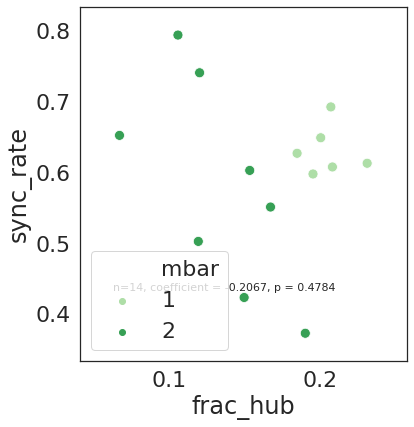

<Figure size 432x288 with 0 Axes>

In [74]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'frac_hub', 'sync_rate', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

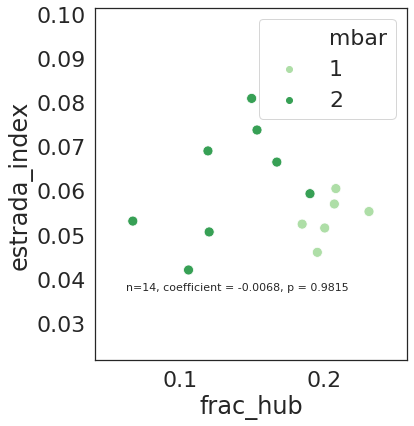

<Figure size 432x288 with 0 Axes>

In [75]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'frac_hub', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

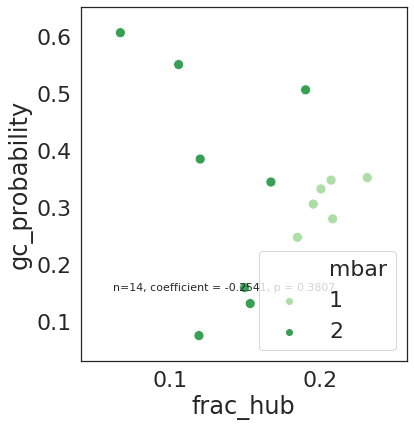

<Figure size 432x288 with 0 Axes>

In [76]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'frac_hub', 'gc_probability', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

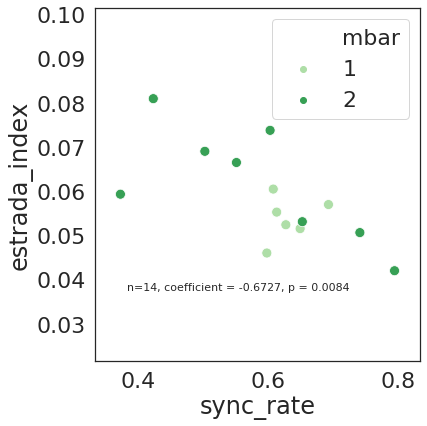

<Figure size 432x288 with 0 Axes>

In [77]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'sync_rate', 'estrada_index', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

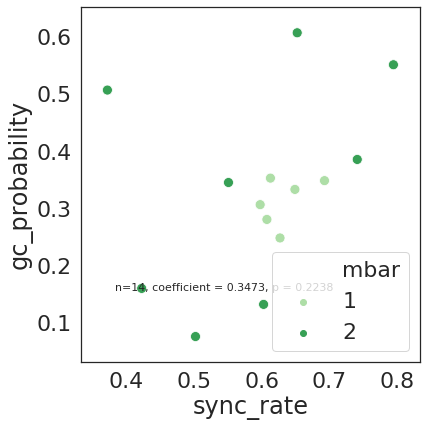

<Figure size 432x288 with 0 Axes>

In [78]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'sync_rate', 'gc_probability', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

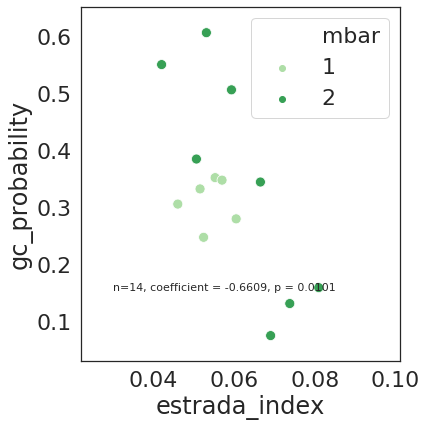

<Figure size 432x288 with 0 Axes>

In [79]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'estrada_index', 'gc_probability', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

## Function to count roles in different cutoffs
### cutoffs -  0.5, 0.75, 1, 1.25, 1.5

In [133]:
def get_roles_fraction(transformed_norm_df: pd.DataFrame, cutoff: float, expirement_tag: str):
    #load analyze_cell_stats
    base_pickle_path = images_pickle_base_path + expirement_tag + '_'
    analyze_cell_stats = load_object(base_pickle_path + 'analyze_cell_stats')
    analyze_cell_stats_flat = analyze_cell_stats.stack()
    
    analyze_cell_stats_flat[f'Manual_{cutoff}'] = np.apply_along_axis(lambda row: get_role(row, cutoff), 1, transformed_norm_df)
    
    state_matrix = analyze_cell_stats_flat.unstack()[f'Manual_{cutoff}'].transpose()
    unique_elements, counts_elements = np.unique(state_matrix.values.flatten(), return_counts=True)    
    normalize_counts_elements = counts_elements/sum(counts_elements)
    
    unique_elements = unique_elements.tolist()
    
    frac_hub = normalize_counts_elements[unique_elements.index(0)] if 0 in unique_elements else 0
    frac_individual = normalize_counts_elements[unique_elements.index(1)] if 1 in unique_elements else 0
    frac_follower = normalize_counts_elements[unique_elements.index(2)] if 2 in unique_elements else 0
    frac_leader = normalize_counts_elements[unique_elements.index(3)] if 3 in unique_elements else 0
    frac_normal = normalize_counts_elements[unique_elements.index(4)] if 4 in unique_elements else 0
    
    return frac_hub, frac_individual, frac_follower, frac_leader, frac_normal

def get_expected_hub_probability(frac_hub, frac_individual, frac_follower, frac_leader, frac_normal):
    return (frac_leader + frac_hub) * (frac_follower + frac_hub)

def get_hub_prob_vectors(stat_step_stress_statistics_df: pd.DataFrame, cutoff: float):
    expected_vec = stat_step_stress_statistics_df.apply(lambda row: get_expected_hub_probability(
                                                        *get_roles_fraction(row['transformed_norm_df'], cutoff, row['tag'])),
                                                        axis=1)
    
    real_frac_vec = stat_step_stress_statistics_df.apply(lambda row: get_roles_fraction(
                                                        row['transformed_norm_df'], cutoff, row['tag'])[0],
                                                        axis=1)
    
    from scipy.stats import wilcoxon
    
    wilcoxon_p_value = wilcoxon(expected_vec, real_frac_vec)[1]
    
    return expected_vec, real_frac_vec, wilcoxon_p_value

def get_hub_prob_vectors_summary(stat_step_stress_statistics_df: pd.DataFrame, cutoff_list: list):
    results = pd.DataFrame(columns=['threshold', 'frac_above', 'p_value'])
    results_raw_values = {}
    for cutoff in cutoff_list:
        #print(f'cutoff: {cutoff}')
        expected_vec, real_frac_vec, wilcoxon_p_value = get_hub_prob_vectors(stat_step_stress_statistics_df, cutoff)
        #print(f'real hub: {list(map(lambda x: round(x, 2), real_frac_vec.tolist()))}')
        #print(f'expected hub: {list(map(lambda x: round(x, 2), expected_vec.tolist()))}')
        results_raw_values.update({ 
                cutoff: {
                    'expected_vec': expected_vec,
                    'real_frac_vec': real_frac_vec,
                    'wilcoxon_p_value': wilcoxon_p_value}
            })
        results = results.append({'threshold': cutoff,
                                  'frac_above': np.sum(real_frac_vec > expected_vec)/len(expected_vec),
                                  'p_value': wilcoxon_p_value}, ignore_index=True)
    
    return results, results_raw_values

hub_prob_cutoff_summary, hub_prob_cutoff_dict = get_hub_prob_vectors_summary(stat_step_stress_statistics_df, 
                                                                             [0.25, 0.5, 0.75, 1, 1.25, 1.5])
hub_prob_cutoff_summary

,threshold,frac_above,p_value
0,0.25,0.857143,0.005213
1,0.50,0.857143,0.007630
2,0.75,0.857143,0.013150
3,1.00,0.785714,0.006319
4,1.25,0.785714,0.006319
5,1.50,0.857143,0.002366


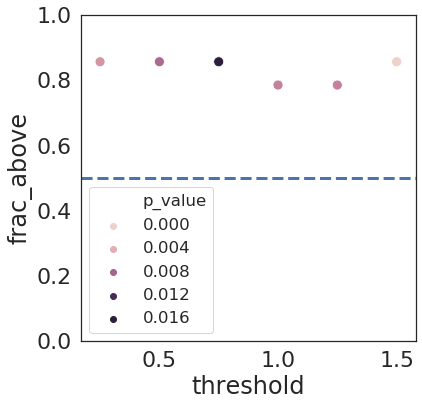

In [122]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='threshold', y='frac_above' , hue="p_value",
                     data=hub_prob_cutoff_summary, s=100)

ax.set(ylim=[0, 1])
ax.axhline(0.5, ls='--')
plt.legend(fontsize='x-small', title_fontsize='10')

In [ ]:
plot_scatter_mbar_color(hub_prob_cutoff_summary, 'threshold', 'frac_above', 
                        prefix='all_12_mbar',save=False, xlim=None, ylim=None, xlog=False, ylog=False, color_set='Greens')

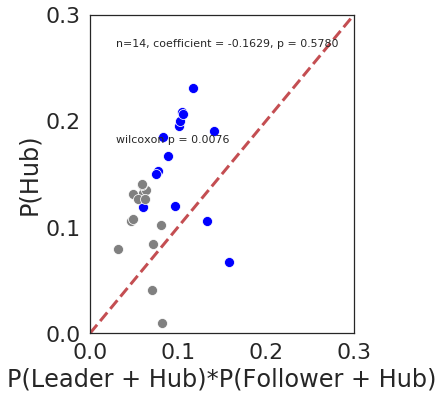

<Figure size 432x288 with 0 Axes>

In [152]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='Expected: P(Leader + Hub)*P(Follower + Hub)', y='frac_hub' ,
                     data=stat_step_stress_statistics_df, s=100, color = 'blue')

ax1 = sns.scatterplot(ax=ax, x=hub_prob_cutoff_dict[0.75]['expected_vec'], y=hub_prob_cutoff_dict[0.75]['real_frac_vec'],
                     s=100, color='gray')

ticks_range = np.arange(0.0, 0.5, step=0.1)

ax.set(xlim=(0.0, 0.3), ylim=(0.0, 0.3), xticks=ticks_range, yticks=ticks_range)
ax.set(xlabel='P(Leader + Hub)*P(Follower + Hub)', ylabel='P(Hub)')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['Expected: P(Leader + Hub)*P(Follower + Hub)'], 
                                  y=stat_step_stress_statistics_df['frac_hub'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .9), xycoords=ax.transAxes, fontsize=11)


from scipy.stats import wilcoxon



ax.annotate("wilcoxon p = {:.4f}".format(wilcoxon(stat_step_stress_statistics_df['Expected: P(Leader + Hub)*P(Follower + Hub)'],
                                                stat_step_stress_statistics_df['frac_hub'])[1]),
                xy=(.1, .6), xycoords=ax.transAxes, fontsize=11)

plt.tight_layout(pad=1, w_pad=2, h_pad=1.0)

plt.plot(ticks_range, ticks_range, 'r--')

#plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title

plt.show()

fig.savefig(images_eps_base_path + 'Expected: P(Leader + Hub)*P(Follower + Hub).eps', format='eps')
fig.savefig(images_base_path + 'Expected: P(Leader + Hub)*P(Follower + Hub).png')
plt.clf()
plt.close(fig)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'gc_probability', 'hub_individual_ratio', prefix='stat', save=True)

## Figure S2

### Stationarity

In [ ]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(8,8))

df_temp = filiter_out_mbar(6 ,step_stress_statistics_df).copy(True)
df_temp['data'] = ''

ax = sns.swarmplot(x='data', y="stationarity_level", hue="mbar",
              palette=["r", "c", "y"], data=df_temp)

ax.axhline(y=0.85, xmin=0.25, xmax=0.75)

ax.annotate("n={}, #1 bar = {}, #2 bar = {}".format(len(df_temp),
            len(df_temp[df_temp['mbar'] == '1']),
            len(df_temp[df_temp['mbar'] == '2'])),
            xy=(.1, .9), xycoords=ax.transAxes, fontsize=11)

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + '_S2_stationarity_' + '.eps', format='eps')
fig.savefig(images_base_path + '_S2_stationarity_' + '.png')

plt.clf()
plt.close(fig)

### S2RolesVsSynchA

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'delta_std', 'frac_hub', prefix='stat', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'delta_std', 'frac_leader', prefix='stat', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'delta_std', 'frac_follower', prefix='stat', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'delta_std', 'frac_normal', prefix='stat', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'delta_std', 'frac_individual', prefix='stat', save=True)

### S2RolesVsSynchB

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'auc_area_ratio', 'frac_hub', prefix='stat', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'auc_area_ratio', 'frac_individual', prefix='stat', save=True)

### S2RolesVsDensity

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'density', 'frac_hub', prefix='stat', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'density', 'frac_individual', prefix='stat', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'density', 'individual_hub_ratio', prefix='stat', save=True)

### MeanGCProbailityVSDensity

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'density', 'gc_probability', save=False)

## Figure S3FlowOfInformationVsSynch

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'gc_probability', 'delta_std', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'gc_probability', 'auc_area_ratio', save=True)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'gc_probability', 'last_100_mean_std', save=True, ylim=[0, 0.0025])

## all the data

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'nn_mean_cc', 'delta_std', save=False)

In [ ]:
plot_scatter_mbar_color(filiter_out_mbar(6 ,step_stress_statistics_df), 'density', 'auc_area_ratio', save=False)

In [ ]:
def filiter_in_mbar(below_equal, data):
    return data[data['mbar'].astype(int) >= below_equal]

plot_scatter_mbar_color(filiter_in_mbar(6 ,step_stress_statistics_df), 'density', 'last_100_mean_std')

# Analysis on Only Stationary data

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'nn_mean_cc', 'last_100_mean_std', save=False)

In [ ]:
plot_scatter_mbar_color(step_stress_statistics_df, 'delta_std', 'last_100_mean_std')

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'density', 'last_100_mean_std')

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'density', 'delta_std')

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'density', 'auc_area_ratio')

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'density', 'gc_probability')

## Mean Cross-Correlation (neighbours) vs Density (to add)

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'gc_probability', 'delta_std')

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'gc_probability', 'last_100_mean_std')

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'density', 'nn_mean_cc')

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'nn_mean_cc', 'last_100_mean_std')

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'gc_probability', 'nn_mean_cc')

In [ ]:
plot_scatter_mbar_color(stat_step_stress_statistics_df, 'gc_probability', 'individual_hub_ratio')

### Hub/Individual

## Last 100 Frames

In [ ]:
import scipy.stats as stats

sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='last_100_mean_std', y='frac_individual' , hue="mbar",
                     data=stat_step_stress_statistics_df, s=100, palette=sns.color_palette("Set1", 2))

x_ticks_range = np.arange(0.0, 0.003, step=0.0015)
y_ticks_range = np.arange(0.0, 0.5, step=0.1)

ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
ax.set(xlabel='last_100_mean_std', ylabel='frac_individual')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['last_100_mean_std'], 
                                  y=stat_step_stress_statistics_df['frac_individual'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .1), xycoords=ax.transAxes, fontsize=11)

#plt.plot(ticks_range, ticks_range, 'r--')

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + 'last_100_mean_std_vs_frac_individual.eps', format='eps')
fig.savefig(images_base_path + 'last_100_mean_std_vs_frac_individual.png')
plt.clf()
plt.close(fig)

In [ ]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='last_100_mean_std', y='frac_hub' , hue="mbar",
                     data=stat_step_stress_statistics_df, s=100, palette=sns.color_palette("Set1", 2))

x_ticks_range = np.arange(0.0, 0.003, step=0.0015)
y_ticks_range = np.arange(0.0, 0.5, step=0.1)

ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
ax.set(xlabel='last_100_mean_std', ylabel='frac_hub')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['last_100_mean_std'], 
                                  y=stat_step_stress_statistics_df['frac_hub'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .1), xycoords=ax.transAxes, fontsize=11)

#plt.plot(ticks_range, ticks_range, 'r--')

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + 'last_100_mean_std_vs_frac_hub.eps', format='eps')
fig.savefig(images_base_path + 'last_100_mean_std_vs_frac_hub.png')
plt.clf()
plt.close(fig)

In [ ]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='last_100_mean_std', y='individual_hub_ratio' , hue="mbar",
                     data=stat_step_stress_statistics_df, s=100, palette=sns.color_palette("Set1", 2))

x_ticks_range = np.arange(0.0, 0.003, step=0.0015)
y_ticks_range = np.arange(0.0, 0.5, step=0.1)

#ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
ax.set(xlabel='last_100_mean_std', ylabel='individual_hub_ratio')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['last_100_mean_std'], 
                                  y=stat_step_stress_statistics_df['individual_hub_ratio'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .1), xycoords=ax.transAxes, fontsize=11)

#plt.plot(ticks_range, ticks_range, 'r--')

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + 'last_100_mean_std_vs_individual_hub_ratio.eps', format='eps')
fig.savefig(images_base_path + 'last_100_mean_std_vs_individual_hub_ratio.png')
plt.clf()
plt.close(fig)

## Delta STD

In [ ]:
import scipy.stats as stats

sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='delta_std', y='frac_individual' , hue="mbar",
                     data=stat_step_stress_statistics_df, s=100, palette=sns.color_palette("Set1", 2))

x_ticks_range = np.arange(0.0, 0.003, step=0.0015)
y_ticks_range = np.arange(0.0, 0.5, step=0.1)

#ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
ax.set(xlabel='delta_std', ylabel='frac_individual')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['delta_std'], 
                                  y=stat_step_stress_statistics_df['frac_individual'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .2), xycoords=ax.transAxes, fontsize=11)

#plt.plot(ticks_range, ticks_range, 'r--')

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + 'delta_std_vs_frac_individual.eps', format='eps')
fig.savefig(images_base_path + 'delta_std_vs_frac_individual.png')
plt.clf()
plt.close(fig)

In [ ]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='delta_std', y='frac_hub' , hue="mbar",
                     data=stat_step_stress_statistics_df, s=100, palette=sns.color_palette("Set1", 2))

x_ticks_range = np.arange(0.0, 0.003, step=0.0015)
y_ticks_range = np.arange(0.0, 0.5, step=0.1)

#ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
ax.set(xlabel='delta_std', ylabel='frac_hub')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['delta_std'], 
                                  y=stat_step_stress_statistics_df['frac_hub'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .1), xycoords=ax.transAxes, fontsize=11)

#plt.plot(ticks_range, ticks_range, 'r--')

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + 'delta_std_vs_frac_hub.eps', format='eps')
fig.savefig(images_base_path + 'delta_std_vs_frac_hub.png')
plt.clf()
plt.close(fig)

In [ ]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='delta_std', y='individual_hub_ratio' , hue="mbar",
                     data=stat_step_stress_statistics_df, s=100, palette=sns.color_palette("Set1", 2))

x_ticks_range = np.arange(0.0, 0.003, step=0.0015)
y_ticks_range = np.arange(0.0, 0.5, step=0.1)

#ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
ax.set(xlabel='delta_std', ylabel='individual_hub_ratio')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['delta_std'], 
                                  y=stat_step_stress_statistics_df['individual_hub_ratio'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .1), xycoords=ax.transAxes, fontsize=11)

#plt.plot(ticks_range, ticks_range, 'r--')

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + 'delta_std_vs_individual_hub_ratio.eps', format='eps')
fig.savefig(images_base_path + 'delta_std_vs_individual_hub_ratio.png')
plt.clf()
plt.close(fig)

## auc_area_ratio

In [ ]:
import scipy.stats as stats

sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='auc_area_ratio', y='individual_hub_ratio' , hue="mbar",
                     data=stat_step_stress_statistics_df, s=100, palette=sns.color_palette("Set1", 2))

x_ticks_range = np.arange(0.0, 0.003, step=0.0015)
y_ticks_range = np.arange(0.0, 0.5, step=0.1)

#ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
ax.set(xlabel='auc_area_ratio', ylabel='individual_hub_ratio')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['auc_area_ratio'], 
                                  y=stat_step_stress_statistics_df['individual_hub_ratio'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .15), xycoords=ax.transAxes, fontsize=11)

#plt.plot(ticks_range, ticks_range, 'r--')

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + 'auc_area_ratio_vs_individual_hub_ratio.eps', format='eps')
fig.savefig(images_base_path + 'auc_area_ratio_vs_individual_hub_ratio.png')
plt.clf()
plt.close(fig)

In [ ]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='auc_area_ratio', y='frac_individual' , hue="mbar",
                     data=stat_step_stress_statistics_df, s=100, palette=sns.color_palette("Set1", 2))

x_ticks_range = np.arange(0.0, 0.003, step=0.0015)
y_ticks_range = np.arange(0.0, 0.5, step=0.1)

#ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
ax.set(xlabel='auc_area_ratio', ylabel='frac_individual')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['auc_area_ratio'], 
                                  y=stat_step_stress_statistics_df['frac_individual'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .15), xycoords=ax.transAxes, fontsize=11)

#plt.plot(ticks_range, ticks_range, 'r--')

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + 'auc_area_ratio_vs_frac_individual.eps', format='eps')
fig.savefig(images_base_path + 'auc_area_ratio_vs_frac_individual.png')
plt.clf()
plt.close(fig)

In [ ]:
sns.set(style='white', font_scale = 2, rc={"lines.linewidth": 3})

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x='auc_area_ratio', y='frac_hub' , hue="mbar",
                     data=stat_step_stress_statistics_df, s=100, palette=sns.color_palette("Set1", 2))

x_ticks_range = np.arange(0.0, 0.003, step=0.0015)
y_ticks_range = np.arange(0.0, 0.5, step=0.1)

#ax.set(xlim=(0.0, 0.003), ylim=(0.0, 0.3), xticks=x_ticks_range, yticks=y_ticks_range)
ax.set(xlabel='auc_area_ratio', ylabel='frac_hub')

data_correlation = stats.pearsonr(x=stat_step_stress_statistics_df['auc_area_ratio'], 
                                  y=stat_step_stress_statistics_df['frac_hub'])

ax.annotate("n={}, coefficient = {:.4f}, p = {:.4f}".format(len(stat_step_stress_statistics_df),
            data_correlation[0], data_correlation[1]), 
            xy=(.1, .15), xycoords=ax.transAxes, fontsize=11)

#plt.plot(ticks_range, ticks_range, 'r--')

plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)

plt.show()

fig.savefig(images_eps_base_path + 'auc_area_ratio_vs_frac_hub.eps', format='eps')
fig.savefig(images_base_path + 'auc_area_ratio_vs_frac_hub.png')
plt.clf()
plt.close(fig)

In [ ]:
step_stress_statistics_df.columns

In [ ]:
step_stress_statistics_df